<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/USA/Apple/Apple_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AAPLUSUSD"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-07-25 03:19:12,988 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-07-25 03:19:12,989 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AAPLUSUSD
2019-07-25 03:22:16,210 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-07-25 03:28:41,585 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-07-25 03:32:00,175 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-07-25 03:35:11,551 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-07-25 03:38:28,062 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-07-25 03:41:37,785 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-07-25 03:44:56,597 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-07-25 03:48:16,762 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-07-25 03:58:35,549 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_445__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AAPLUSUSD__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AAPLUSUSD__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AAPLUSUSD to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 14:00:00  1.70138  1.71058  1.69257  1.70968  16.620377
2018-01-02 15:00:00  1.70967  1.71588  1.70857  1.71498  22.677385
2018-01-02 16:00:00  1.71490  1.71510  1.71097  1.71198  16.675083
2018-01-02 17:00:00  1.71198  1.71488  1.71187  1.71281  13.665617
2018-01-02 18:00:00  1.71278  1.71688  1.71277  1.71667  13.143733
...                      ...      ...      ...      ...        ...
2018-12-31 16:00:00  1.57032  1.58148  1.56888  1.57938  12.732075
2018-12-31 17:00:00  1.57937  1.58918  1.57748  1.58348  11.736275
2018-12-31 18:00:00  1.58347  1.58458  1.57417  1.57558  10.324237
2018-12-31 19:00:00  1.57538  1.57798  1.56867  1.57337  10.867764
2018-12-31 20:00:00  1.57348  1.57757  1.56627  1.57718  13.249620

[1745 rows x 5 columns]

Open         High          Low        Close       Volume
count  1745.000000  1745.000000  1745.000000  1745.000000  1745.000000
mean      1.892712     1.899268     1.885718     1.892676    21.262165
std       0.204467     0.204856     0.204418     0.204630    20.779993
min       1.468790     1.485570     1.466780     1.467380     0.976983
25%       1.736580     1.741880     1.729970     1.736870     8.461745
50%       1.863280     1.868970     1.858870     1.863280    14.491368
75%       2.076470     2.081670     2.071570     2.076680    23.290422
max       2.327170     2.334180     2.324570     2.327070   117.602814

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close     Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2018-01-11 15:00:00  1.75087  1.75468  1.74817  1.75228  22.349520   11          3         11             31    15             0               0               0                 0      1        1     2        3             2           2  1.739305  1.719242  1.730462  1.746649  1.743729  1.743731    1.742130    1.742325  1.732889  1.740093  1.749830  1.738879  1.743384  1.740093  1.748483  1.741071                1.754493                 1.740093                1.725692                1.761694                 1.740093                1.718491                1.768894                 1.740093                1.711291                1.776095                 1.740093                1.704090  1.743729  1.748678  1.740766                1.758130                 1.743729                1.729328                1.765330                 1.743729                1.722128                1.772531                 1.743729                1.714927                1.779731                 1.743729   
2018-01-11 16:00:00  1.75238  1.75378  1.74993  1.75077  18.675621   11          3         11             31    16             0               0               0                 0      1        1     2        3             2           2  1.745038  1.725691  1.731431  1.748781  1.745294  1.744977    1.742130    1.742325  1.734632  1.741979  1.751698  1.741785  1.745756  1.741979  1.751525  1.741235                1.757484                 1.741979                1.726473                1.765237                 1.741979                1.718720                1.772990                 1.741979                1.710968                1.780743                 1.741979                1.703215  1.745294  1.750726  1.741043                1.760799                 1.745294                1.729788                1.768552                 1.745294                1.722035                1.776305                 1.745294                1.714283                1.784057                 1.745294   
2018-01-11 17:00:00  1.75078  1.75277  1.74947  1.75

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000    1695.000000  1695.000000   1695.000000     1695.000000      1695.00000        1695.00000  1695.000000  1695.000000  1695.000000  1695.000000   1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000  1695.000000             1695.000000              1695.000000             1695.000000             1695.000000              1695.000000             1695.000000             1695.000000              1695.000000             1695.000000             1695.000000              1695.000000             1695.000000  1695.000000  1695.000000  1695.000000             1695.000000              1695.000000             1695.000000             1695.000000              1695.000000             1695.000000             1695.000000   
mean      1.897357     1.903993     1.890245     1.897289    21.376011    16.092035     2.028909   187.060767      30.428909    16.310324      0.037168        0.028909         0.00413           0.00413     6.648378     2.548083    27.075516     2.028909      1.990560    27.075516     1.897611     1.898814     0.110069     1.897283     1.897639     1.897040     1.897215     1.896435     1.895576     1.897632     1.897303     1.897633     1.897521     1.897632     1.897345     1.898372                1.920199                 1.897632                1.875064                1.931482                 1.897632                1.863781                1.942766                 1.897632                1.852497                1.954050                 1.897632                1.841214     1.897639     1.897357     1.898253                1.920206                 1.897639                1.875072                1.931490                 1.897639                1.863788                1.942773   
std       0.205629     0.205963     0.205670     0.205821    21.063869     8.667056     1.411201   101.324571       0.846265     2.051401      0.189229        0.167599         0.06415           0.06415     3.325728     1.098413    14.482949     1.411201      1.404548    14.482949     0.205326     0.203445     1.904272     0.206088     0.204713     0.204671     0.204963     0.204819     0.205005     0.204973     0.205939     0.205075     0.205176     0.204973     0.205538     0.203166                0.205871                 0.204973                0.205229                0.206748                 0.204973                0.205790                0.207908                 0.204973                0.206636                0.209344                 0.204973                0.207763     0.204713     0.205527     0.203450                0.205605                 0.204713                0.204976                0.206481                 0.204713                0.205540                0.207639   
min       1.468790     1.485570     1.4667

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-11 15:00:00  0.328619  0.317119  0.328041  0.331398  0.183257   11          3         11             31    15             0               0               0                 0      1        1     2        3             2           2  0.298362  0.249189  0.879141  0.325147  0.304369  0.302565    0.307085    0.302130  0.306789  0.301877  0.328082  0.303088  0.310240  0.301877  0.322981  0.281251                0.282506                 0.301877                0.329126                0.271236                 0.301877                0.350250                0.255521                 0.301877                0.370179                0.231728                 0.301877                0.389011  0.304369  0.321524  0.283784                0.281461                 0.304369                0.326774                0.270864                 0.304369                0.344961                0.260143                 0.304369                0.365569                0.235570                 0.304369   
2018-01-11 16:00:00  0.330378  0.316058  0.330093  0.329642  0.151756   11          3         11             31    16             0               0               0                 0      1        1     2        3             2           2  0.305305  0.257594  0.879351  0.327620  0.306265  0.304083    0.307085    0.302130  0.308799  0.304145  0.330245  0.306552  0.313063  0.304145  0.326541  0.281460                0.286133                 0.304145                0.330034                0.275529                 0.304145                0.350508                0.260394                 0.304145                0.369825                0.236963                 0.304145                0.388078  0.306265  0.323930  0.284136                0.284732                 0.306265                0.327320                0.274819                 0.306265                0.344854                0.264783                 0.306265                0.364844                0.240602                 0.306265   
2018-01-11 17:00:00  0.328514  0.314868  

139742

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpaop7gthr
  JVM stdout: /tmp/tmpaop7gthr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpaop7gthr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_d1rg29
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_040614_mod...  0.652632  0.666074              0.441053  0.485667  0.235872
1  DeepLearning_grid_1_AutoML_20190725_040614_mod...  0.646316  0.697283              0.455439  0.488727  0.238854
2  DeepLearning_grid_1_AutoML_20190725_040614_mod...  0.645193  0.698972              0.455439  0.500315  0.250315
3  DeepLearning_grid_1_AutoML_20190725_040614_mod...  0.633544  0.980830              0.378947  0.542622  0.294439
4  DeepLearning_grid_1_AutoML_20190725_040614_mod...  0.624702  1.529146              0.431579  0.621695  0.386504
5  DeepLearning_grid_1_AutoML_20190725_040614_mod...  0.618737  3.350149              0.390526  0.623776  0.389097
6  DeepLearning_grid_1_AutoML_20190725_040614_mod...  0.603719  0.708816              0.444912  0.502766  0.252773
7  DeepLearning_grid_1_AutoML_20190725_040614_mod...  0.596351  1.028711              0.430526  0.561888  0.315718
8              DeepLearning_1_AutoML_20190725_040614  0.570386  1.019623              0.379649  0.563804  0.317875
9  DeepLearning_grid_1_AutoML_20190725_040614_mod...  0.563789  0.704204              0.448772  0.501069  0.251070

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.006625
1                  CDLLONGLINE             0.740712           0.740712    0.004907
2           CDLCLOSINGMARUBOZU             0.695613           0.695613    0.004608
3                         hour             0.507577           0.507577    0.003363
4                  CDLBELTHOLD             0.495158           0.495158    0.003280
...                        ...                  ...                ...         ...
1027                 MAVP_20_2             0.116106           0.116106    0.000769
1028    BBANDS_upperband_8_2_3             0.115936           0.115936    0.000768
1029  BBANDS_middleband_20_6_4             0.115630           0.115630    0.000766
1030                    T3_8_8             0.115525           0.115525    0.000765
1031    BBANDS_upperband_8_4_2             0.115300           0.115300    0.000764

[1032 rows x 4 columns]

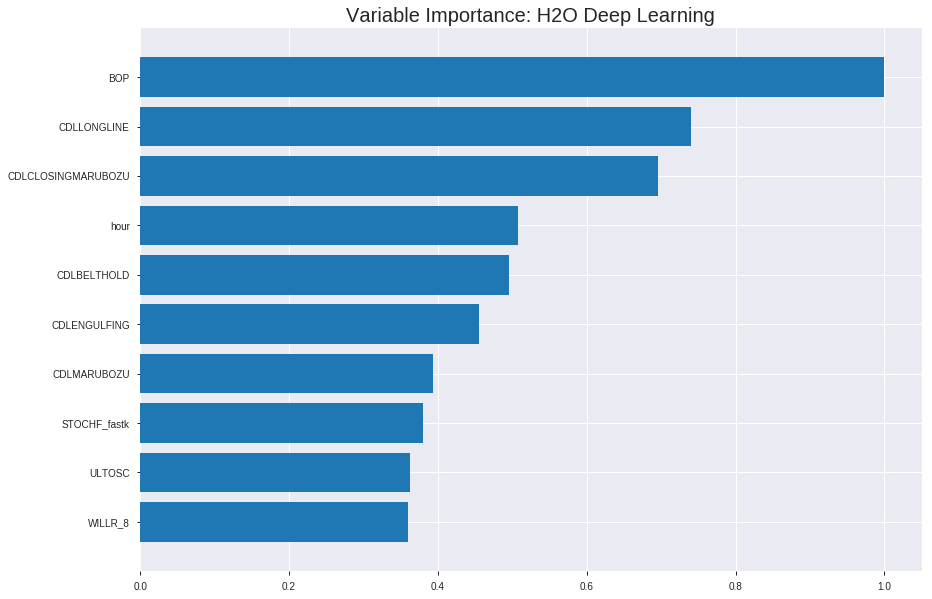

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_040614_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19954913547844758
RMSE: 0.4467092292290899
LogLoss: 0.5802227522449537
Mean Per-Class Error: 0.27395833926831625
AUC: 0.8016713861651275
pr_auc: 0.8068462022354377
Gini: 0.6033427723302549
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4405745336452381: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      272  326  0.5452   (326.0/598.0)
1      55   532  0.0937   (55.0/587.0)
Total  327  858  0.3215   (381.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440575     0.736332  246
max f2                       0.295581     0.845276  326
max f0point5                 0.467468     0.738283  204
max accuracy                 0.460466     0.726582  213
max precision                0.982462     1         0
max recall                   0.116893     1         382
max specificity              0.982462     1         0
max absolute_mcc             0.460466     0.455392  213
max min_per_class_accuracy   0.4537       0.714047  223
max mean_per_class_accuracy  0.460466     0.726042  213

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 47.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.955214           2.01874   2.01874            1                0.966076  1                           0.966076            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.932891           2.01874   2.01874            1                0.942577  1                           0.954326            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.918205           1.85051   1.96266            0.916667         0.927444  0.972222                    0.945366            0.0187394       0.0596252                  85.0511   96.2663
    4        0.0405063                   0.883644           2.01874   1.97668            1                0.900263  0.979167                    0.93409             0.0204429       0.0800681                  101.874   97.6682
    5        0.0506329                   0.835286           2.01874   1.98509            1                0.858869  0.983333                    0.919046            0.0204429       0.100511                   101.874   98.5094
    6        0.100422                    0.676338           1.88188   1.93392            0.932203         0.752774  0.957983                    0.836609            0.0936968       0.194208                   88.1876   93.3918
    7        0.150211                    0.60203            1.7108    1.85996            0.847458         0.635562  0.921348                    0.76997             0.0851789       0.279387                   71.0796   85.9962
    8        0.2                         0.543625           1.57393   1.78876            0.779661         0.570134  0.886076                    0.720222            0.0783646       0.357751                   57.3932   78.8756
    9        0.300422                    0.483661           1.44196   1.67283            0.714286         0.508955  0.828652                    0.649601            0.144804        0.502555                   44.1957   67.2832
    10       0.4                         0.464818           1.19756   1.55451            0.59322          0.473043  0.770042                    0.605648            0.11925         0.621806                   19.7557   55.4514
    11       0.500422                    0.453278           0.966959  1.43661            0.478992         0.458776  0.711636                    0.576174            0.0971039       0.71891                    -3.30408  43.6607
    12       0.6                         0.448263           0.906722  1.34867            0.449153         0.450219  0.668073                    0.555271            0.0902896       0.809199                   -9.32781  34.8666
    13       0.699578                    0.443937           0.701426  1.25654            0.347458         0.44668   0.622437                    0.539814            0.0698467       0.879046                   -29.8574  25.6537
    14       0.8                         0.416114           0.661604  1.18186            0.327731         0.43155   0.585443                    0.526224            0.0664395       0.945486                   -33.8396  18.1857
    15       0.899578                    0.302841           0.376375  1.09269            0.186441         0.366164  0.541276                    0.508506            0.0374787       0.982964                   -62.3625  9.26948
    16       1                           0.0243526          0.169642  1                  0.0840336        0.188892  0.495359                    0.47641          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24274238811517734
RMSE: 0.492688936465167
LogLoss: 0.6785789602602791
Mean Per-Class Error: 0.3328025477707006
AUC: 0.7082662560369566
pr_auc: 0.6363371100671232
Gini: 0.4165325120739132
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4633239949805616: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      85   97   0.533    (97.0/182.0)
1      22   135  0.1401   (22.0/157.0)
Total  107  232  0.351    (119.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463324     0.694087  231
max f2                       0.449898     0.82265   307
max f0point5                 0.479631     0.628141  109
max accuracy                 0.479631     0.654867  109
max precision                0.620047     1         0
max recall                   0.446025     1         321
max specificity              0.620047     1         0
max absolute_mcc             0.464669     0.350732  221
max min_per_class_accuracy   0.472686     0.648352  165
max mean_per_class_accuracy  0.464669     0.667197  221

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 47.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.528214           1.07962   1.07962            0.5              0.567611  0.5                         0.567611            0.0127389       0.0127389                  7.96178   7.96178
    2        0.020649                    0.521942           2.15924   1.54231            1                0.522976  0.714286                    0.548482            0.0191083       0.0318471                  115.924   54.2311
    3        0.0324484                   0.518542           1.07962   1.37406            0.5              0.52069   0.636364                    0.538376            0.0127389       0.044586                   7.96178   37.4059
    4        0.0412979                   0.514349           2.15924   1.54231            1                0.515748  0.714286                    0.533527            0.0191083       0.0636943                  115.924   54.2311
    5        0.0501475                   0.505895           2.15924   1.65118            1                0.510801  0.764706                    0.529517            0.0191083       0.0828025                  115.924   65.118
    6        0.100295                    0.497178           1.39715   1.52417            0.647059         0.500787  0.705882                    0.515152            0.0700637       0.152866                   39.7152   52.4166
    7        0.150442                    0.490498           1.65118   1.5665             0.764706         0.492605  0.72549                     0.507636            0.0828025       0.235669                   65.118    56.6504
    8        0.20059                     0.486237           1.65118   1.58767            0.764706         0.488604  0.735294                    0.502878            0.0828025       0.318471                   65.118    58.7673
    9        0.300885                    0.480785           1.20663   1.46066            0.558824         0.483284  0.676471                    0.496347            0.121019        0.43949                    20.6632   46.0659
    10       0.40118                     0.476339           1.07962   1.3654             0.5              0.478356  0.632353                    0.491849            0.10828         0.547771                   7.96178   36.5399
    11       0.501475                    0.472486           1.14312   1.32094            0.529412         0.474127  0.611765                    0.488305            0.11465         0.66242                    14.3125   32.0944
    12       0.59882                     0.467257           1.0469    1.2764             0.484848         0.470245  0.591133                    0.485369            0.101911        0.764331                   4.69021   27.6395
    13       0.699115                    0.462588           0.952604  1.22994            0.441176         0.464953  0.56962                     0.48244             0.0955414       0.859873                   -4.7396   22.9944
    14       0.79941                     0.456677           0.508055  1.13938            0.235294         0.459262  0.527675                    0.479532            0.0509554       0.910828                   -49.1945  13.9375
    15       0.899705                    0.451321           0.635069  1.08316            0.294118         0.454509  0.501639                    0.476743            0.0636943       0.974522                   -36.4931  8.31576
    16       1                           0.438696           0.254028  1                  0.117647         0.446623  0.463127                    0.473722          


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:26:42  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:26:44  5 min 53.048 sec   253 obs/sec       0.501266  1             594        0.670657         1.83453             -0.799278      0.593942        0.606428           1.85051          0.504641                         0.654385           1.86351               -0.722247        0.609855          0.554766             1.61943            0.516224
    2019-07-25 04:27:24  6 min 33.014 sec   220 obs/sec       7.09114   14            8403       0.504314         0.702604            -0.0174179     0.625894        0.652437           2.01874          0.499578                         0.517599           0.732501              -0.0774944       0.580808          0.524289             2.15924            0.486726
    2019-07-25 04:28:08  7 min 17.079 sec   232 obs/sec       15.2641   30            18088      0.471107         0.633169            0.112157       0.729348        0.732964           1.85051          0.362025                         0.498784           0.690714              -0.000582804     0.590362          0.531823             1.07962            0.433628
    2019-07-25 04:28:50  7 min 59.436 sec   239 obs/sec       23.4177   46            27750      0.457752         0.602279            0.161782       0.747107        0.754318           1.85051          0.362025                         0.495861           0.684872              0.0111086        0.622944          0.611364             1.61943            0.510324
    2019-07-25 04:29:35  8 min 44.352 sec   245 obs/sec       32.4177   64            38415      0.44772          0.582385            0.198118       0.773547        0.778712           2.01874          0.331646                         0.49843            0.690008              0.000837754      0.533282          0.570424             1.61943            0.536873
    2019-07-25 04:30:20  9 min 29.403 sec   249 obs/sec       41.5325   82            49216      0.444647         0.572679            0.209087       0.789526        0.796589           2.01874          0.307173                         0.497662           0.688455              0.00391244       0.613565          0.605474             1.61943            0.533923
    2019-07-25 04:31:06  10 min 15.456 sec  251 obs/sec       50.6996   100           60079      0.446709         0.580223            0.201735       0.801671        0.806846           2.01874          0.321519                         0.492689           0.678579              0.0237209        0.708266          0.636337             1.07962            0.351032

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.006624793470807145
CDLLONGLINE               0.7407116293907166     0.7407116293907166   0.004907061566138541
CDLCLOSINGMARUBOZU        0.6956131458282471     0.6956131458282471   0.004608293426690589
hour                      0.5075774192810059     0.5075774192810059   0.0033625955731819484
CDLBELTHOLD               0.49515843391418457    0.49515843391418457  0.003280322360009781
---                       ---                    ---                  ---
MAVP_20_2                 0.11610619723796844    0.11610619723796844  0.00076917957738234
BBANDS_upperband_8_2_3    0.11593634635210037    0.11593634635210037  0.0007680543503426303
BBANDS_middleband_20_6_4  0.11562981456518173    0.11562981456518173  0.0007660236405620569
T3_8_8                    0.11552458256483078    0.11552458256483078  0.0007653265002932119
BBANDS_upperband_8_4_2    0.11529950052499771    0.11529950052499771  0.0007638353782653299


See the whole table with table.as_data_frame()


('accuracy', 0.6588235294117647)

('F1', 0.6343612334801761)

('auc', 0.6526315789473685)

('logloss', 0.666074347352337)

('mean_per_class_error', 0.35964912280701755)

('rmse', 0.4856669948203602)

('mse', 0.2358724298578398)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


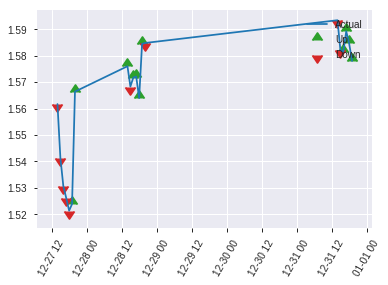


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2358724298578398
RMSE: 0.4856669948203602
LogLoss: 0.666074347352337
Mean Per-Class Error: 0.35964912280701755
AUC: 0.6526315789473685
pr_auc: 0.5667834947876591
Gini: 0.3052631578947369
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4428248845699664: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      15   80   0.8421   (80.0/95.0)
1      3    72   0.04     (3.0/75.0)
Total  18   152  0.4882   (83.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442825     0.634361  151
max f2                       0.354835     0.804721  165
max f0point5                 0.573177     0.607287  42
max accuracy                 0.573177     0.658824  42
max precision                0.583151     0.7       39
max recall                   0.354835     1         165
max specificity              0.840591     0.989474  0
max absolute_mcc             0.573177     0.300589  42
max min_per_class_accuracy   0.499688     0.6       77
max mean_per_class_accuracy  0.527336     0.640351  63

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 51.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.825644           1.13333   1.13333            0.5              0.838552  0.5                         0.838552            0.0133333       0.0133333                  13.3333   13.3333
    2        0.0235294                   0.784877           1.13333   1.13333            0.5              0.804187  0.5                         0.821369            0.0133333       0.0266667                  13.3333   13.3333
    3        0.0352941                   0.772704           1.13333   1.13333            0.5              0.777084  0.5                         0.806607            0.0133333       0.04                       13.3333   13.3333
    4        0.0411765                   0.752411           2.26667   1.29524            1                0.758747  0.571429                    0.79977             0.0133333       0.0533333                  126.667   29.5238
    5        0.0529412                   0.747399           2.26667   1.51111            1                0.750156  0.666667                    0.788745            0.0266667       0.08                       126.667   51.1111
    6        0.1                         0.687128           1.13333   1.33333            0.5              0.721583  0.588235                    0.757139            0.0533333       0.133333                   13.3333   33.3333
    7        0.152941                    0.626104           1.76296   1.48205            0.777778         0.657705  0.653846                    0.722719            0.0933333       0.226667                   76.2963   48.2051
    8        0.2                         0.604547           1.7       1.53333            0.75             0.614122  0.676471                    0.697167            0.08            0.306667                   70        53.3333
    9        0.3                         0.540684           1.33333   1.46667            0.588235         0.569955  0.647059                    0.654763            0.133333        0.44                       33.3333   46.6667
    10       0.4                         0.520518           1.06667   1.36667            0.470588         0.532668  0.602941                    0.624239            0.106667        0.546667                   6.66667   36.6667
    11       0.5                         0.48039            0.666667  1.22667            0.294118         0.499925  0.541176                    0.599376            0.0666667       0.613333                   -33.3333  22.6667
    12       0.6                         0.463115           0.666667  1.13333            0.294118         0.470684  0.5                         0.577928            0.0666667       0.68                       -33.3333  13.3333
    13       0.7                         0.451865           1.06667   1.12381            0.470588         0.4559    0.495798                    0.560495            0.106667        0.786667                   6.66667   12.381
    14       0.8                         0.448683           0.8       1.08333            0.352941         0.450401  0.477941                    0.546733            0.08            0.866667                   -20       8.33333
    15       0.9                         0.441414           0.933333  1.06667            0.411765         0.446584  0.470588                    0.535606            0.0933333       0.96                       -6.66667  6.66667
    16       1                           0.212852           0.4       1                  0.176471         0.365918  0.441176                    0.518637          

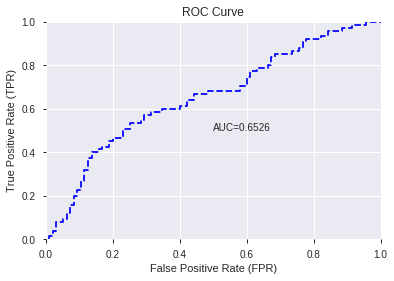

This function is available for GLM models only


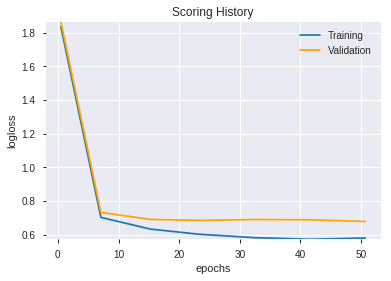

--2019-07-25 04:31:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_040614_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_040614_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_043127_model_9  0.644211  0.672558              0.413684  0.487534  0.237689
1  DeepLearning_grid_1_AutoML_20190725_043127_model_8  0.643649  0.685332              0.438246  0.490618  0.240706
2  DeepLearning_grid_1_AutoML_20190725_043127_model_7  0.628351  1.005242              0.448772  0.538794  0.290299
3  DeepLearning_grid_1_AutoML_20190725_043127_model_6  0.628070  0.719873              0.429123  0.499337  0.249338
4               DeepLearning_1_AutoML_20190725_043127  0.627930  0.793529              0.350526  0.517223  0.267519
5  DeepLearning_grid_1_AutoML_20190725_043127_model_5  0.625825  0.715532              0.438246  0.503852  0.253867
6  DeepLearning_grid_1_AutoML_20190725_043127_model_4  0.583158  1.094013              0.399649  0.568788  0.323520
7  DeepLearning_grid_1_AutoML_20190725_043127_model_2  0.578246  1.006662              0.431930  0.560500  0.314161
8  DeepLearning_grid_1_AutoML_20190725_043127_model_3  0.559579  1.017597              0.439649  0.555993  0.309129
9  DeepLearning_grid_1_AutoML_20190725_043127_model_1  0.517333  1.424478              0.403509  0.613258  0.376085

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.032467
1     CDLCLOSINGMARUBOZU             0.804818           0.804818    0.026130
2                   hour             0.714480           0.714480    0.023197
3            CDLLONGLINE             0.705871           0.705871    0.022917
4            CDLMARUBOZU             0.676393           0.676393    0.021960
5             aroonup_12             0.648102           0.648102    0.021042
6        CDLSHOOTINGSTAR             0.647785           0.647785    0.021031
7             PLUS_DI_30             0.636649           0.636649    0.020670
8                 SAREXT             0.634028           0.634028    0.020585
9                ROCP_30             0.631918           0.631918    0.020516
10         CDLHANGINGMAN             0.626467           0.626467    0.020339
11                  CEIL             0.621258           0.621258    0.020170
12            aroonup_14             0.620644           0.620644    0.020150
13             CDLTAKURI             0.617518           0.617518    0.020049
14          CDLENGULFING             0.616526           0.616526    0.020017
15      CDLDRAGONFLYDOJI             0.614788           0.614788    0.019960
16         days_in_month             0.612676           0.612676    0.019892
17          STOCHF_fastk             0.611922           0.611922    0.019867
18                ULTOSC             0.611858           0.611858    0.019865
19              WILLR_14             0.605689           0.605689    0.019665
20                ROC_30             0.605557           0.605557    0.019660
21                Volume             0.603424           0.603424    0.019591
22               WILLR_8             0.602406           0.602406    0.019558
23          aroondown_30             0.600392           0.600392    0.019493
24           HT_DCPERIOD             0.600097           0.600097    0.019483
25     HT_PHASOR_inphase             0.600087           0.600087    0.019483
26    LINEARREG_ANGLE_12             0.599696           0.599696    0.019470
27                   SUB             0.596856           0.596856    0.019378
28               ROCR_30             0.596452           0.596452    0.019365
29              WILLR_30             0.592432           0.592432    0.019234
30                TRANGE             0.592326           0.592326    0.019231
31                BETA_8             0.589784           0.589784    0.019148
32  HT_PHASOR_quadrature             0.588362           0.588362    0.019102
33                MOM_30             0.587243           0.587243    0.019066
34              CORREL_8             0.585715           0.585715    0.019016
35     CDLLONGLEGGEDDOJI             0.585628           0.585628    0.019013
36        STOCHRSI_fastd             0.582974           0.582974    0.018927
37                  DX_8             0.581248           0.581248    0.018871
38             CORREL_14             0.579571           0.579571    0.018817
39                   DIV             0.577688           0.577688    0.018756
40    LINEARREG_SLOPE_12             0.577657           0.577657    0.018755
41             CORREL_12             0.575198           0.575198    0.018675
42        CDLRICKSHAWMAN             0.574328           0.574328    0.018647
43                MFI_24             0.573769           0.573769    0.018628
44          CDLSHORTLINE             0.572264           0.572264    0.018580
45        STOCHRSI_fastk             0.568829           0.568829    0.018468
46            aroonup_30             0.567477           0.567477    0.018424
47           CDLBELTHOLD             0.566738           0.566738    0.018400
48            ROCR100_30             0.560148           0.560148    0.018186
49               CDLDOJI             0.557001           0.557001    0.018084

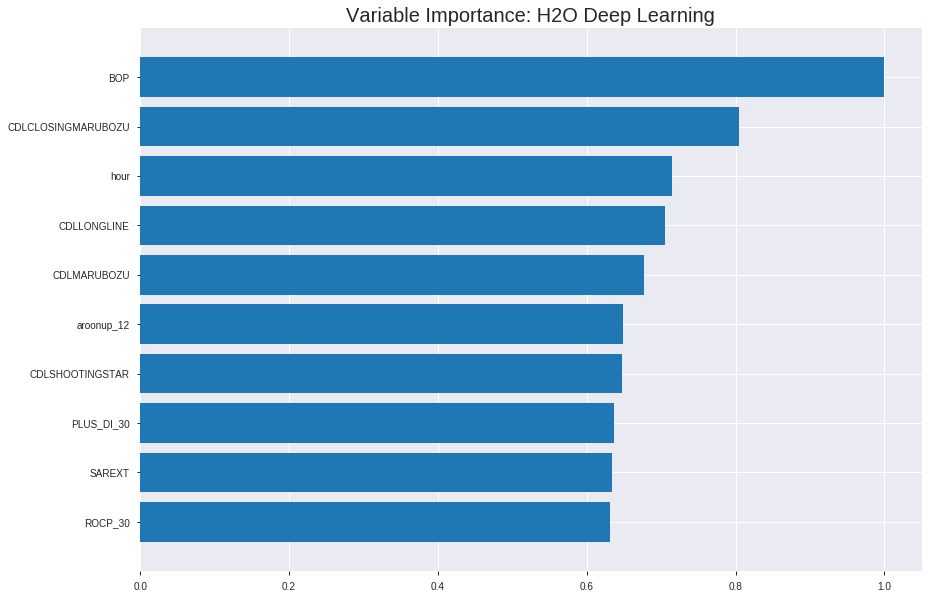

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_043127_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19729879365364117
RMSE: 0.44418328835475246
LogLoss: 0.5773194021014613
Mean Per-Class Error: 0.2742774039529836
AUC: 0.7820531812458337
pr_auc: 0.7770394117283391
Gini: 0.5641063624916673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45403412160561746: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      378  220  0.3679   (220.0/598.0)
1      121  466  0.2061   (121.0/587.0)
Total  499  686  0.2878   (341.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454034     0.732129  215
max f2                       0.282598     0.843463  316
max f0point5                 0.474222     0.723842  198
max accuracy                 0.474222     0.725738  198
max precision                0.926958     1         0
max recall                   0.0751727    1         394
max specificity              0.926958     1         0
max absolute_mcc             0.473119     0.451439  199
max min_per_class_accuracy   0.473119     0.72402   199
max mean_per_class_accuracy  0.473119     0.725723  199

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 47.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.916993           2.01874   2.01874            1                0.922566  1                           0.922566            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.904721           2.01874   2.01874            1                0.913658  1                           0.918112            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.874029           2.01874   2.01874            1                0.889855  1                           0.908693            0.0204429       0.0613288                  101.874   101.874
    4        0.0405063                   0.857191           2.01874   2.01874            1                0.864607  1                           0.897671            0.0204429       0.0817717                  101.874   101.874
    5        0.0506329                   0.832491           2.01874   2.01874            1                0.843672  1                           0.886872            0.0204429       0.102215                   101.874   101.874
    6        0.100422                    0.731219           1.60815   1.81517            0.79661          0.777568  0.89916                     0.832679            0.0800681       0.182283                   60.8148   81.5169
    7        0.150211                    0.668796           1.64236   1.75789            0.813559         0.700464  0.870787                    0.788855            0.0817717       0.264055                   64.2364   75.7891
    8        0.2                         0.599592           1.57393   1.7121             0.779661         0.633066  0.848101                    0.750072            0.0783646       0.342419                   57.3932   71.2095
    9        0.300422                    0.531866           1.30624   1.57643            0.647059         0.561441  0.780899                    0.687018            0.131175        0.473595                   30.6243   57.6431
    10       0.4                         0.497235           1.19756   1.48211            0.59322          0.513092  0.734177                    0.64372             0.11925         0.592845                   19.7557   48.2112
    11       0.500422                    0.471534           1.32321   1.45022            0.655462         0.483404  0.718381                    0.611549            0.132879        0.725724                   32.3207   45.0224
    12       0.6                         0.446831           0.821182  1.34583            0.40678          0.459783  0.666667                    0.586361            0.0817717       0.807496                   -17.8818  34.5826
    13       0.699578                    0.417322           0.66721   1.24923            0.330508         0.432545  0.618818                    0.564467            0.0664395       0.873935                   -33.279   24.9232
    14       0.8                         0.359823           0.661604  1.17547            0.327731         0.391227  0.582278                    0.542721            0.0664395       0.940375                   -33.8396  17.5468
    15       0.899578                    0.240614           0.359267  1.08512            0.177966         0.303059  0.537523                    0.516191            0.0357751       0.97615                    -64.0733  8.51197
    16       1                           0.0429694          0.237499  1                  0.117647         0.153163  0.495359                    0.479735         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2178852458842673
RMSE: 0.4667817968647313
LogLoss: 0.6234570903014548
Mean Per-Class Error: 0.3372996430321271
AUC: 0.7077413032827045
pr_auc: 0.6507779767788381
Gini: 0.4154826065654089
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4354028260005626: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      91   91   0.5      (91.0/182.0)
1      28   129  0.1783   (28.0/157.0)
Total  119  220  0.351    (119.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435403     0.68435   219
max f2                       0.175962     0.828025  313
max f0point5                 0.518806     0.640599  110
max accuracy                 0.518806     0.663717  110
max precision                0.923975     1         0
max recall                   0.111824     1         330
max specificity              0.923975     1         0
max absolute_mcc             0.441098     0.336879  214
max min_per_class_accuracy   0.475236     0.636943  165
max mean_per_class_accuracy  0.441098     0.6627    214

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 46.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.857182           1.61943   1.61943            0.75             0.88981   0.75                        0.88981             0.0191083       0.0191083                  61.9427   61.9427
    2        0.020649                    0.828132           2.15924   1.85077            1                0.840465  0.857143                    0.868662            0.0191083       0.0382166                  115.924   85.0773
    3        0.0324484                   0.811422           2.15924   1.96294            1                0.819648  0.909091                    0.850839            0.0254777       0.0636943                  115.924   96.2942
    4        0.0412979                   0.794097           1.43949   1.85077            0.666667         0.802358  0.857143                    0.84045             0.0127389       0.0764331                  43.949    85.0773
    5        0.0501475                   0.782748           1.43949   1.77819            0.666667         0.788898  0.823529                    0.831353            0.0127389       0.089172                   43.949    77.8194
    6        0.100295                    0.692657           1.39715   1.58767            0.647059         0.743187  0.735294                    0.78727             0.0700637       0.159236                   39.7152   58.7673
    7        0.150442                    0.600525           1.39715   1.52417            0.647059         0.631779  0.705882                    0.73544             0.0700637       0.229299                   39.7152   52.4166
    8        0.20059                     0.566209           1.52417   1.52417            0.705882         0.581763  0.705882                    0.69702             0.0764331       0.305732                   52.4166   52.4166
    9        0.300885                    0.529906           1.33365   1.46066            0.617647         0.545654  0.676471                    0.646565            0.133758        0.43949                    33.3646   46.0659
    10       0.40118                     0.496921           1.14312   1.38128            0.529412         0.511936  0.639706                    0.612908            0.11465         0.55414                    14.3125   38.1276
    11       0.501475                    0.473809           0.889097  1.28284            0.411765         0.48393   0.594118                    0.587112            0.089172        0.643312                   -11.0903  28.284
    12       0.59882                     0.450863           1.11233   1.25512            0.515152         0.462453  0.581281                    0.566847            0.10828         0.751592                   11.2334   25.5122
    13       0.699115                    0.412308           1.01611   1.22083            0.470588         0.433286  0.565401                    0.547687            0.101911        0.853503                   1.61109   22.0834
    14       0.79941                     0.356581           0.508055  1.13141            0.235294         0.390242  0.523985                    0.527933            0.0509554       0.904459                   -49.1945  13.1408
    15       0.899705                    0.240692           0.635069  1.07608            0.294118         0.314198  0.498361                    0.504107            0.0636943       0.968153                   -36.4931  7.60781
    16       1                           0.0694963          0.317535  1                  0.147059         0.149704  0.463127                    0.468562          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:37:12  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:37:15  2 min  0.805 sec  514 obs/sec       1         1             1185       0.591599         1.15594             -0.400078      0.721441        0.706288           2.01874          0.353586                         0.575472           1.11309               -0.331916        0.672569          0.646199             1.61943            0.489676
    2019-07-25 04:37:24  2 min  9.946 sec  781 obs/sec       7         7             8295       0.444183         0.577319            0.210737       0.782053        0.777039           2.01874          0.287764                         0.466782           0.623457              0.123693         0.707741          0.650778             1.61943            0.351032
    2019-07-25 04:37:32  2 min 18.421 sec  908 obs/sec       14        14            16590      0.435663         0.560749            0.240726       0.788843        0.786038           2.01874          0.306329                         0.469985           0.63185               0.111623         0.694827          0.626211             1.07962            0.351032
    2019-07-25 04:37:41  2 min 27.154 sec  997 obs/sec       22        22            26070      0.432275         0.553828            0.252488       0.79976         0.792086           2.01874          0.269198                         0.471249           0.635482              0.106839         0.695982          0.62104              1.07962            0.356932
    2019-07-25 04:37:50  2 min 36.007 sec  1075 obs/sec      31        31            36735      0.427382         0.544783            0.269317       0.8065          0.801215           2.01874          0.27173                          0.470555           0.63327               0.109471         0.693743          0.611207             1.61943            0.353982
    2019-07-25 04:37:59  2 min 45.237 sec  1143 obs/sec      41        41            48585      0.4185           0.523769            0.29937        0.818112        0.811086           2.01874          0.270886                         0.480036           0.660469              0.0732196        0.686253          0.603074             1.07962            0.356932
    2019-07-25 04:38:08  2 min 54.124 sec  1195 obs/sec      51        51            60435      0.415785         0.516074            0.308432       0.820763        0.813073           2.01874          0.274262                         0.485608           0.679987              0.0515827        0.680549          0.601778             1.61943            0.436578
    2019-07-25 04:38:09  2 min 55.013 sec  1194 obs/sec      51        51            60435      0.444183         0.577319            0.210737       0.782053        0.777039           2.01874          0.287764                         0.466782           0.623457              0.123693         0.707741          0.650778             1.61943            0.351032

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.032466754931548915
CDLCLOSINGMARUBOZU  0.8048175573348999     0.8048175573348999   0.026129814398600015
hour                0.7144798040390015     0.7144798040390015   0.023196840701275354
CDLLONGLINE         0.7058708071708679     0.7058708071708679   0.02291733450975119
CDLMARUBOZU         0.6763933897018433     0.6763933897018433   0.02196029842076941
---                 ---                    ---                  ---
STOCHRSI_fastk      0.5688291192054749     0.5688291192054749   0.018468035611172978
aroonup_30          0.5674768686294556     0.5674768686294556   0.018424132423115313
CDLBELTHOLD         0.5667378306388855     0.5667378306388855   0.018400138257790372
ROCR100_30          0.5601482391357422     0.5601482391357422   0.0181861956053588
CDLDOJI             0.5570013523101807     0.5570013523101807   0.018084026401995974


See the whole table with table.as_data_frame()


('accuracy', 0.6470588235294118)

('F1', 0.6418604651162791)

('auc', 0.6442105263157895)

('logloss', 0.6725582905622352)

('mean_per_class_error', 0.36070175438596497)

('rmse', 0.4875335894219981)

('mse', 0.2376890008146974)

deeplearning prediction progress: |███████████████████████████████████████| 100%


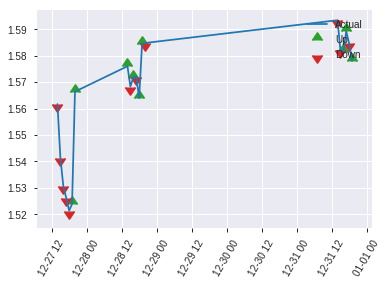


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2376890008146974
RMSE: 0.4875335894219981
LogLoss: 0.6725582905622352
Mean Per-Class Error: 0.36070175438596497
AUC: 0.6442105263157895
pr_auc: 0.5594528251828361
Gini: 0.2884210526315789
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2229850481172107: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      24   71   0.7474   (71.0/95.0)
1      6    69   0.08     (6.0/75.0)
Total  30   140  0.4529   (77.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.222985     0.64186   139
max f2                       0.0840838    0.806452  164
max f0point5                 0.452019     0.598886  70
max accuracy                 0.463127     0.647059  64
max precision                0.922185     1         0
max recall                   0.0840838    1         164
max specificity              0.922185     1         0
max absolute_mcc             0.452019     0.280493  70
max min_per_class_accuracy   0.452019     0.573333  70
max mean_per_class_accuracy  0.452019     0.639298  70

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 41.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.865305           1.13333   1.13333            0.5              0.898251   0.5                         0.898251            0.0133333       0.0133333                  13.3333   13.3333
    2        0.0235294                   0.852034           1.13333   1.13333            0.5              0.859075   0.5                         0.878663            0.0133333       0.0266667                  13.3333   13.3333
    3        0.0352941                   0.829003           2.26667   1.51111            1                0.837292   0.666667                    0.864873            0.0266667       0.0533333                  126.667   51.1111
    4        0.0411765                   0.807645           0         1.29524            0                0.809378   0.571429                    0.856945            0               0.0533333                  -100      29.5238
    5        0.0529412                   0.801505           1.13333   1.25926            0.5              0.804474   0.555556                    0.845285            0.0133333       0.0666667                  13.3333   25.9259
    6        0.1                         0.658965           1.7       1.46667            0.75             0.706648   0.647059                    0.780044            0.08            0.146667                   70        46.6667
    7        0.152941                    0.568583           1.51111   1.48205            0.666667         0.612727   0.653846                    0.722127            0.08            0.226667                   51.1111   48.2051
    8        0.2                         0.529656           1.41667   1.46667            0.625            0.545511   0.647059                    0.68057             0.0666667       0.293333                   41.6667   46.6667
    9        0.3                         0.486851           1.2       1.37778            0.529412         0.504286   0.607843                    0.621809            0.12            0.413333                   20        37.7778
    10       0.4                         0.45917            1.33333   1.36667            0.588235         0.468761   0.602941                    0.583547            0.133333        0.546667                   33.3333   36.6667
    11       0.5                         0.433549           0.266667  1.14667            0.117647         0.447113   0.505882                    0.55626             0.0266667       0.573333                   -73.3333  14.6667
    12       0.6                         0.408006           1.33333   1.17778            0.588235         0.418762   0.519608                    0.533344            0.133333        0.706667                   33.3333   17.7778
    13       0.7                         0.345013           0.533333  1.08571            0.235294         0.38637    0.478992                    0.512347            0.0533333       0.76                       -46.6667  8.57143
    14       0.8                         0.230665           1.33333   1.11667            0.588235         0.284042   0.492647                    0.483809            0.133333        0.893333                   33.3333   11.6667
    15       0.9                         0.136716           0.666667  1.06667            0.294118         0.192373   0.470588                    0.451427            0.0666667       0.96                       -33.3333  6.66667
    16       1                           0.0604884          0.4       1                  0.176471         0.0958675  0.441176                   

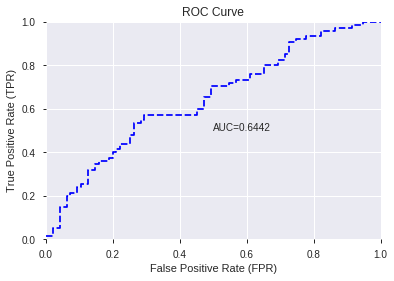

This function is available for GLM models only


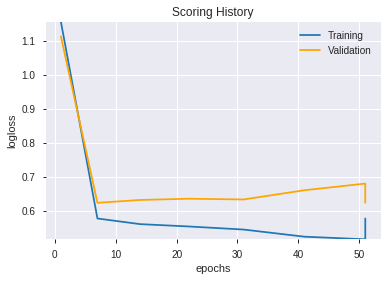

--2019-07-25 04:38:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_043127_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_043127_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'aroonup_12',
 'CDLSHOOTINGSTAR',
 'PLUS_DI_30',
 'SAREXT',
 'ROCP_30',
 'CDLHANGINGMAN',
 'CEIL',
 'aroonup_14',
 'CDLTAKURI',
 'CDLENGULFING',
 'CDLDRAGONFLYDOJI',
 'days_in_month',
 'STOCHF_fastk',
 'ULTOSC',
 'WILLR_14',
 'ROC_30',
 'Volume',
 'WILLR_8',
 'aroondown_30',
 'HT_DCPERIOD',
 'HT_PHASOR_inphase',
 'LINEARREG_ANGLE_12',
 'SUB',
 'ROCR_30',
 'WILLR_30',
 'TRANGE',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'MOM_30',
 'CORREL_8',
 'CDLLONGLEGGEDDOJI',
 'STOCHRSI_fastd',
 'DX_8',
 'CORREL_14',
 'DIV',
 'LINEARREG_SLOPE_12',
 'CORREL_12',
 'CDLRICKSHAWMAN',
 'MFI_24',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'aroonup_30',
 'CDLBELTHOLD',
 'ROCR100_30',
 'CDLDOJI']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_043824_model_1  0.648421  0.66633              0.457895  0.484357  0.234602

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.281843           1.000000    0.101080
1     CDLCLOSINGMARUBOZU             0.155335           0.551140    0.055709
2                   hour             0.127474           0.452285    0.045717
3            CDLLONGLINE             0.122575           0.434903    0.043960
4        CDLSHOOTINGSTAR             0.102042           0.362054    0.036596
5                WILLR_8             0.090006           0.319346    0.032279
6                 ULTOSC             0.086617           0.307323    0.031064
7           STOCHF_fastk             0.085251           0.302477    0.030574
8           CDLENGULFING             0.078070           0.276998    0.027999
9          CDLHANGINGMAN             0.075066           0.266338    0.026921
10              WILLR_14             0.075064           0.266332    0.026921
11            PLUS_DI_30             0.071111           0.252308    0.025503
12                SAREXT             0.069457           0.246437    0.024910
13           CDLMARUBOZU             0.067130           0.238184    0.024075
14                Volume             0.066598           0.236293    0.023884
15      CDLDRAGONFLYDOJI             0.065883           0.233758    0.023628
16             CDLTAKURI             0.061002           0.216439    0.021878
17        STOCHRSI_fastk             0.058917           0.209043    0.021130
18                   SUB             0.058081           0.206076    0.020830
19           HT_DCPERIOD             0.057749           0.204897    0.020711
20            aroonup_12             0.055551           0.197099    0.019923
21              WILLR_30             0.050414           0.178873    0.018080
22    LINEARREG_ANGLE_12             0.049430           0.175380    0.017727
23    LINEARREG_SLOPE_12             0.049394           0.175253    0.017714
24                   DIV             0.046970           0.166651    0.016845
25            aroonup_14             0.043247           0.153442    0.015510
26                  CEIL             0.042913           0.152257    0.015390
27             CORREL_14             0.041814           0.148361    0.014996
28                  DX_8             0.039605           0.140520    0.014204
29           CDLBELTHOLD             0.036866           0.130802    0.013221
30     HT_PHASOR_inphase             0.036303           0.128807    0.013020
31        STOCHRSI_fastd             0.034829           0.123576    0.012491
32                ROC_30             0.033411           0.118546    0.011983
33               ROCP_30             0.033301           0.118156    0.011943
34               ROCR_30             0.033184           0.117738    0.011901
35            ROCR100_30             0.033114           0.117493    0.011876
36  HT_PHASOR_quadrature             0.032967           0.116969    0.011823
37          aroondown_30             0.032132           0.114008    0.011524
38                BETA_8             0.029398           0.104307    0.010543
39                MOM_30             0.029178           0.103524    0.010464
40            aroonup_30             0.025785           0.091486    0.009247
41              CORREL_8             0.025450           0.090299    0.009127
42                MFI_24             0.020337           0.072156    0.007293
43        CDLRICKSHAWMAN             0.016442           0.058339    0.005897
44     CDLLONGLEGGEDDOJI             0.013392           0.047515    0.004803
45               CDLDOJI             0.013388           0.047500    0.004801
46         days_in_month             0.010193           0.036164    0.003655
47          CDLSHORTLINE             0.008721           0.030943    0.003128
48             CORREL_12             0.008494           0.030136    0.003046
49                TRANGE             0.006841           0.024272    0.002453

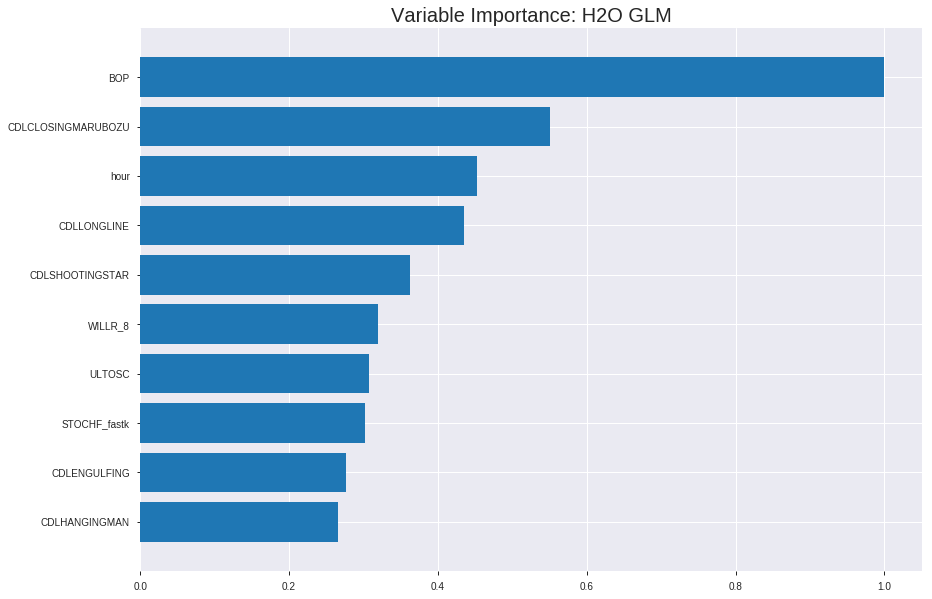

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_043824_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19642659093924153
RMSE: 0.44320039591503246
LogLoss: 0.576731177853761
Null degrees of freedom: 1184
Residual degrees of freedom: 1134
Null deviance: 1642.6567067559345
Residual deviance: 1366.8528915134136
AIC: 1468.8528915134136
AUC: 0.7746164101804425
pr_auc: 0.7737301092636797
Gini: 0.5492328203608849
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41905373882137675: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      321  277  0.4632   (277.0/598.0)
1      92   495  0.1567   (92.0/587.0)
Total  413  772  0.3114   (369.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419054     0.728477  245
max f2                       0.280373     0.837518  326
max f0point5                 0.514169     0.717292  190
max accuracy                 0.514169     0.7173    190
max precision                0.92314      1         0
max recall                   0.107749     1         387
max specificity              0.92314      1         0
max absolute_mcc             0.514169     0.434638  190
max min_per_class_accuracy   0.50182      0.713799  196
max mean_per_class_accuracy  0.514169     0.717111  190

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.874696           2.01874   2.01874            1                0.894079  1                           0.894079            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.863732           2.01874   2.01874            1                0.869017  1                           0.881548            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.840669           2.01874   2.01874            1                0.853555  1                           0.872217            0.0204429       0.0613288                  101.874   101.874
    4        0.0405063                   0.822365           2.01874   2.01874            1                0.831995  1                           0.862161            0.0204429       0.0817717                  101.874   101.874
    5        0.0506329                   0.796478           1.85051   1.98509            0.916667         0.81227   0.983333                    0.852183            0.0187394       0.100511                   85.0511   98.5094
    6        0.100422                    0.738403           1.64236   1.81517            0.813559         0.760817  0.89916                     0.806884            0.0817717       0.182283                   64.2364   81.5169
    7        0.150211                    0.696607           1.64236   1.75789            0.813559         0.717145  0.870787                    0.777139            0.0817717       0.264055                   64.2364   75.7891
    8        0.2                         0.658803           1.36864   1.66099            0.677966         0.677115  0.822785                    0.752239            0.0681431       0.332198                   36.8637   66.0988
    9        0.300422                    0.596507           1.34017   1.55375            0.663866         0.628546  0.769663                    0.710892            0.134583        0.46678                    34.0172   55.3749
    10       0.4                         0.548966           1.2831    1.48637            0.635593         0.572218  0.736287                    0.67637             0.127768        0.594549                   28.3097   48.6371
    11       0.500422                    0.495596           1.20446   1.4298             0.596639         0.524878  0.708263                    0.645969            0.120954        0.715503                   20.4458   42.9799
    12       0.6                         0.442977           0.855398  1.33447            0.423729         0.469138  0.661041                    0.616622            0.0851789       0.800681                   -14.4602  33.4469
    13       0.699578                    0.390737           0.718534  1.2468             0.355932         0.418199  0.617612                    0.588378            0.0715503       0.872232                   -28.1466  24.6797
    14       0.8                         0.3318             0.644639  1.17121            0.319328         0.361332  0.580169                    0.559878            0.0647359       0.936968                   -35.5361  17.121
    15       0.899578                    0.253064           0.325051  1.07754            0.161017         0.297366  0.533771                    0.530819            0.032368        0.969336                   -67.4949  7.75447
    16       1                           0.0620352          0.305356  1                  0.151261         0.177704  0.495359                    0.495359          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21489161488416628
RMSE: 0.46356403536530555
LogLoss: 0.6186626369033239
Null degrees of freedom: 338
Residual degrees of freedom: 288
Null deviance: 469.5188524558861
Residual deviance: 419.4532678204537
AIC: 521.4532678204537
AUC: 0.7134107930286274
pr_auc: 0.6517864493321819
Gini: 0.42682158605725484
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3987014889467266: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      80   102  0.5604   (102.0/182.0)
1      20   137  0.1274   (20.0/157.0)
Total  100  239  0.3599   (122.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398701     0.691919  238
max f2                       0.263201     0.830654  304
max f0point5                 0.551754     0.635401  125
max accuracy                 0.551754     0.660767  125
max precision                0.875432     1         0
max recall                   0.105102     1         337
max specificity              0.875432     1         0
max absolute_mcc             0.398701     0.341335  238
max min_per_class_accuracy   0.500113     0.631868  166
max mean_per_class_accuracy  0.445843     0.661388  208

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 48.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.843593           1.61943   1.61943            0.75             0.858842  0.75                        0.858842            0.0191083       0.0191083                  61.9427   61.9427
    2        0.020649                    0.820684           1.43949   1.54231            0.666667         0.834825  0.714286                    0.848549            0.0127389       0.0318471                  43.949    54.2311
    3        0.0324484                   0.80766            1.61943   1.57035            0.75             0.815105  0.727273                    0.836388            0.0191083       0.0509554                  61.9427   57.0353
    4        0.0412979                   0.793663           2.15924   1.69654            1                0.804224  0.785714                    0.829495            0.0191083       0.0700637                  115.924   69.6542
    5        0.0501475                   0.778624           0.719745  1.52417            0.333333         0.782385  0.705882                    0.821182            0.00636943      0.0764331                  -28.0255  52.4166
    6        0.100295                    0.728805           1.65118   1.58767            0.764706         0.757218  0.735294                    0.7892              0.0828025       0.159236                   65.118    58.7673
    7        0.150442                    0.664942           1.77819   1.65118            0.823529         0.693119  0.764706                    0.757173            0.089172        0.248408                   77.8194   65.118
    8        0.20059                     0.625188           1.39715   1.58767            0.647059         0.644719  0.735294                    0.72906             0.0700637       0.318471                   39.7152   58.7673
    9        0.300885                    0.576886           1.27014   1.48183            0.588235         0.603485  0.686275                    0.687202            0.127389        0.44586                    27.0139   48.1828
    10       0.40118                     0.542788           1.14312   1.39715            0.529412         0.560326  0.647059                    0.655483            0.11465         0.56051                    14.3125   39.7152
    11       0.501475                    0.490537           0.889097  1.29554            0.411765         0.515772  0.6                         0.62754             0.089172        0.649682                   -11.0903  29.5541
    12       0.59882                     0.448562           1.11233   1.26576            0.515152         0.473058  0.586207                    0.602427            0.10828         0.757962                   11.2334   26.5759
    13       0.699115                    0.400588           1.01611   1.22994            0.470588         0.42367   0.56962                     0.576783            0.101911        0.859873                   1.61109   22.9944
    14       0.79941                     0.337303           0.635069  1.15531            0.294118         0.371219  0.535055                    0.550993            0.0636943       0.923567                   -36.4931  15.5311
    15       0.899705                    0.263087           0.635069  1.09732            0.294118         0.300096  0.508197                    0.523024            0.0636943       0.987261                   -36.4931  9.73165
    16       1                           0.086654           0.127014  1                  0.0588235        0.186809  0.463127                    0.489303          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:38:24  0.000 sec   2            20        50            1.36503           1.36865
    2019-07-25 04:38:24  0.051 sec   4            13        51            1.35431           1.36046
    2019-07-25 04:38:24  0.091 sec   6            7.9       51            1.33954           1.34928
    2019-07-25 04:38:24  0.110 sec   8            4.9       51            1.32039           1.33491
    2019-07-25 04:38:24  0.128 sec   10           3         51            1.29722           1.31772
    2019-07-25 04:38:24  0.146 sec   12           1.9       51            1.27118           1.29877
    2019-07-25 04:38:24  0.163 sec   14           1.2       51            1.24406           1.27978
    2019-07-25 04:38:24  0.180 sec   16           0.73      51            1.21762           1.26268
    2019-07-25 04:38:24  0.198 sec   18           0.45      51            1.19327           1.24922
    2019-07-25 04:38:24  0.218 sec   20           0.28      51            1.17182           1.24057
    2019-07-25 04:38:24  0.240 sec   22           0.17      51            1.15346           1.23733
    2019-07-25 04:38:24  0.256 sec   24           0.11      51            1.13807           1.23981
    2019-07-25 04:38:24  0.272 sec   26           0.067     51            1.12538           1.24823
    2019-07-25 04:38:25  0.288 sec   28           0.042     51            1.11518           1.26275
    2019-07-25 04:38:25  0.301 sec   30           0.026     51            1.10731           1.28291
    2019-07-25 04:38:25  0.318 sec   32           0.016     51            1.10162           1.30707

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6705882352941176)

('F1', 0.6329113924050632)

('auc', 0.648421052631579)

('logloss', 0.6663295956844648)

('mean_per_class_error', 0.34807017543859653)

('rmse', 0.4843573453078704)

('mse', 0.23460203795368761)

glm prediction progress: |████████████████████████████████████████████████| 100%


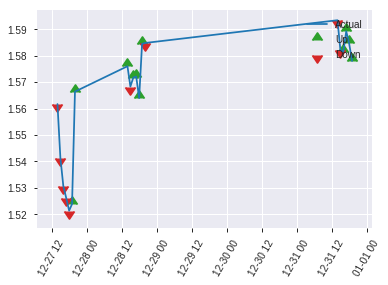


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23460203795368761
RMSE: 0.4843573453078704
LogLoss: 0.6663295956844648
Null degrees of freedom: 169
Residual degrees of freedom: 119
Null deviance: 235.31337198870415
Residual deviance: 226.55206253271805
AIC: 328.5520625327181
AUC: 0.648421052631579
pr_auc: 0.576444192449217
Gini: 0.296842105263158
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12308582867352721: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      8    87   0.9158   (87.0/95.0)
1      0    75   0        (0.0/75.0)
Total  8    162  0.5118   (87.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.123086     0.632911  161
max f2                       0.123086     0.811688  161
max f0point5                 0.49707      0.627119  54
max accuracy                 0.49707      0.670588  54
max precision                0.626224     0.724138  28
max recall                   0.123086     1         161
max specificity              0.857278     0.989474  0
max absolute_mcc             0.49707      0.322504  54
max min_per_class_accuracy   0.413835     0.589474  83
max mean_per_class_accuracy  0.49707      0.65193   54

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 41.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.843867           1.13333   1.13333            0.5              0.852736  0.5                         0.852736            0.0133333       0.0133333                  13.3333   13.3333
    2        0.0235294                   0.82853            1.13333   1.13333            0.5              0.837182  0.5                         0.844959            0.0133333       0.0266667                  13.3333   13.3333
    3        0.0352941                   0.805964           2.26667   1.51111            1                0.814068  0.666667                    0.834662            0.0266667       0.0533333                  126.667   51.1111
    4        0.0411765                   0.799554           2.26667   1.61905            1                0.805646  0.714286                    0.830517            0.0133333       0.0666667                  126.667   61.9048
    5        0.0529412                   0.77603            1.13333   1.51111            0.5              0.792172  0.666667                    0.821996            0.0133333       0.08                       13.3333   51.1111
    6        0.1                         0.688022           1.41667   1.46667            0.625            0.724472  0.647059                    0.776102            0.0666667       0.146667                   41.6667   46.6667
    7        0.152941                    0.636945           1.76296   1.56923            0.777778         0.655571  0.692308                    0.73438             0.0933333       0.24                       76.2963   56.9231
    8        0.2                         0.609793           1.41667   1.53333            0.625            0.622638  0.676471                    0.708088            0.0666667       0.306667                   41.6667   53.3333
    9        0.3                         0.505403           1.46667   1.51111            0.647059         0.547472  0.666667                    0.654549            0.146667        0.453333                   46.6667   51.1111
    10       0.4                         0.455378           0.933333  1.36667            0.411765         0.480099  0.602941                    0.610937            0.0933333       0.546667                   -6.66667  36.6667
    11       0.5                         0.410148           0.533333  1.2                0.235294         0.430095  0.529412                    0.574768            0.0533333       0.6                        -46.6667  20
    12       0.6                         0.355883           0.933333  1.15556            0.411765         0.380251  0.509804                    0.542349            0.0933333       0.693333                   -6.66667  15.5556
    13       0.7                         0.309525           0.933333  1.12381            0.411765         0.330045  0.495798                    0.51202             0.0933333       0.786667                   -6.66667  12.381
    14       0.8                         0.229506           0.8       1.08333            0.352941         0.283141  0.477941                    0.48341             0.08            0.866667                   -20       8.33333
    15       0.9                         0.155256           0.8       1.05185            0.352941         0.195265  0.464052                    0.451394            0.08            0.946667                   -20       5.18519
    16       1                           0.0505072          0.533333  1                  0.235294         0.114995  0.441176                    0.417754            0.0

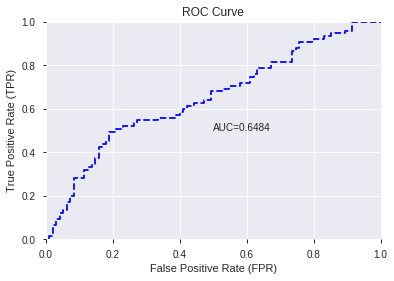

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


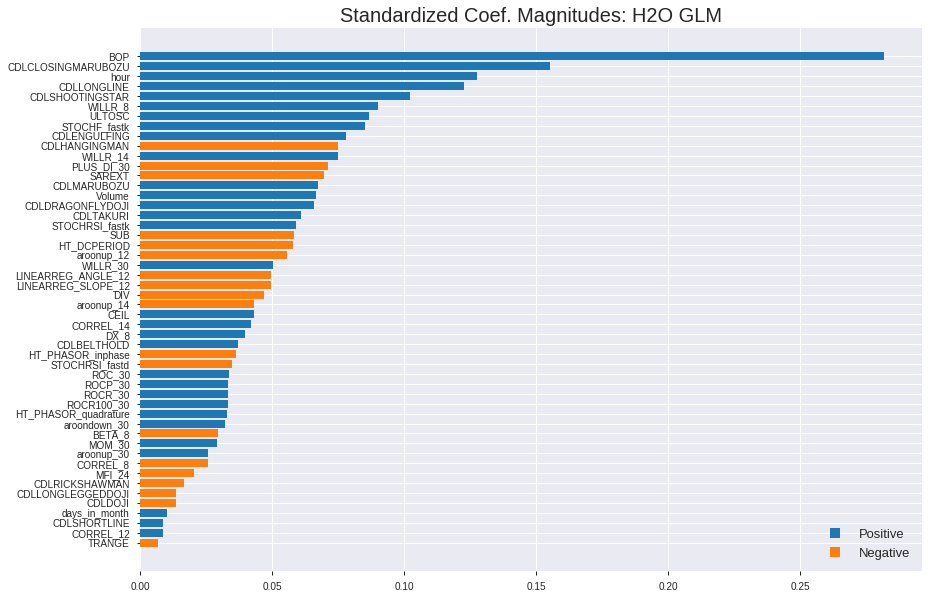

'log_likelihood'
--2019-07-25 04:38:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_043824_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_043824_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'CDLLONGLINE',
 'CDLSHOOTINGSTAR',
 'WILLR_8',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'WILLR_14',
 'PLUS_DI_30',
 'SAREXT',
 'CDLMARUBOZU',
 'Volume',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCHRSI_fastk',
 'SUB',
 'HT_DCPERIOD',
 'aroonup_12',
 'WILLR_30',
 'LINEARREG_ANGLE_12',
 'LINEARREG_SLOPE_12',
 'DIV',
 'aroonup_14',
 'CEIL',
 'CORREL_14',
 'DX_8',
 'CDLBELTHOLD',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastd',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'HT_PHASOR_quadrature',
 'aroondown_30',
 'BETA_8',
 'MOM_30',
 'aroonup_30',
 'CORREL_8',
 'MFI_24',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'days_in_month',
 'CDLSHORTLINE',
 'CORREL_12',
 'TRANGE']

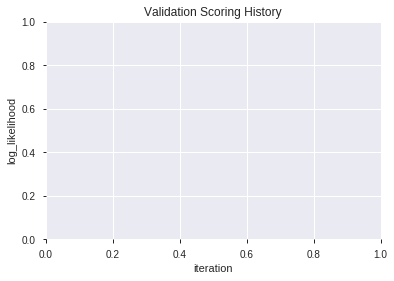

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_043837_model_6  0.701333  0.643862              0.389825  0.472640  0.223389
1  XGBoost_grid_1_AutoML_20190725_043837_model_1  0.693333  0.664417              0.372632  0.479105  0.229541
2  XGBoost_grid_1_AutoML_20190725_043837_model_4  0.690807  0.641562              0.341754  0.473009  0.223737
3               XGBoost_3_AutoML_20190725_043837  0.688281  0.663535              0.322807  0.479507  0.229927
4               XGBoost_2_AutoML_20190725_043837  0.687719  0.654178              0.343158  0.478228  0.228702
5  XGBoost_grid_1_AutoML_20190725_043837_model_2  0.675509  0.658135              0.406667  0.480411  0.230795
6               XGBoost_1_AutoML_20190725_043837  0.672702  0.674906              0.408070  0.486371  0.236557
7  XGBoost_grid_1_AutoML_20190725_043837_model_3  0.672281  0.677541              0.333333  0.485358  0.235572
8  XGBoost_grid_1_AutoML_20190725_043837_model_7  0.670175  0.690926              0.369474  0.488968  0.239090
9  XGBoost_grid_1_AutoML_20190725_043837_model_5  0.656982  0.709440              0.357544  0.497563  0.247569

variable  relative_importance  scaled_importance  percentage
0                    BOP          1466.243652           1.000000    0.198836
1           STOCHF_fastk           525.322266           0.358278    0.071238
2                WILLR_8           339.767334           0.231726    0.046076
3      HT_PHASOR_inphase           293.414032           0.200113    0.039790
4   HT_PHASOR_quadrature           282.640411           0.192765    0.038329
5                 SAREXT           260.802368           0.177871    0.035367
6                   DX_8           232.442230           0.158529    0.031521
7                   hour           231.671997           0.158004    0.031417
8                    DIV           221.320557           0.150944    0.030013
9                 BETA_8           215.168365           0.146748    0.029179
10           HT_DCPERIOD           200.055420           0.136441    0.027129
11            PLUS_DI_30           187.626495           0.127964    0.025444
12                ULTOSC           185.148773           0.126274    0.025108
13                MOM_30           183.836029           0.125379    0.024930
14                Volume           180.475128           0.123087    0.024474
15              WILLR_14           175.601074           0.119763    0.023813
16        STOCHRSI_fastd           175.248123           0.119522    0.023765
17                TRANGE           171.135818           0.116717    0.023208
18             CORREL_12           167.874863           0.114493    0.022765
19        STOCHRSI_fastk           160.505569           0.109467    0.021766
20              CORREL_8           158.266724           0.107940    0.021462
21                MFI_24           139.992416           0.095477    0.018984
22                ROC_30           139.496231           0.095139    0.018917
23            aroonup_12           138.348068           0.094355    0.018761
24             CORREL_14           129.826996           0.088544    0.017606
25              WILLR_30           128.857437           0.087883    0.017474
26            aroonup_30            93.743690           0.063935    0.012712
27    LINEARREG_ANGLE_12            77.854637           0.053098    0.010558
28                   SUB            77.166893           0.052629    0.010465
29          aroondown_30            66.671799           0.045471    0.009041
30            aroonup_14            54.060875           0.036870    0.007331
31    LINEARREG_SLOPE_12            52.956345           0.036117    0.007181
32    CDLCLOSINGMARUBOZU            52.763813           0.035986    0.007155
33       CDLSHOOTINGSTAR            46.376274           0.031629    0.006289
34          CDLSHORTLINE            34.772640           0.023715    0.004715
35      CDLDRAGONFLYDOJI            32.268360           0.022008    0.004376
36               ROCP_30            26.572750           0.018123    0.003604
37           CDLLONGLINE            17.037521           0.011620    0.002310
38               ROCR_30            13.932322           0.009502    0.001889
39             CDLTAKURI            12.561207           0.008567    0.001703
40                  CEIL            10.938547           0.007460    0.001483
41         days_in_month             5.119262           0.003491    0.000694
42           CDLBELTHOLD             4.767580           0.003252    0.000647
43          CDLENGULFING             2.620799           0.001787    0.000355
44        CDLRICKSHAWMAN             0.864751           0.000590    0.000117

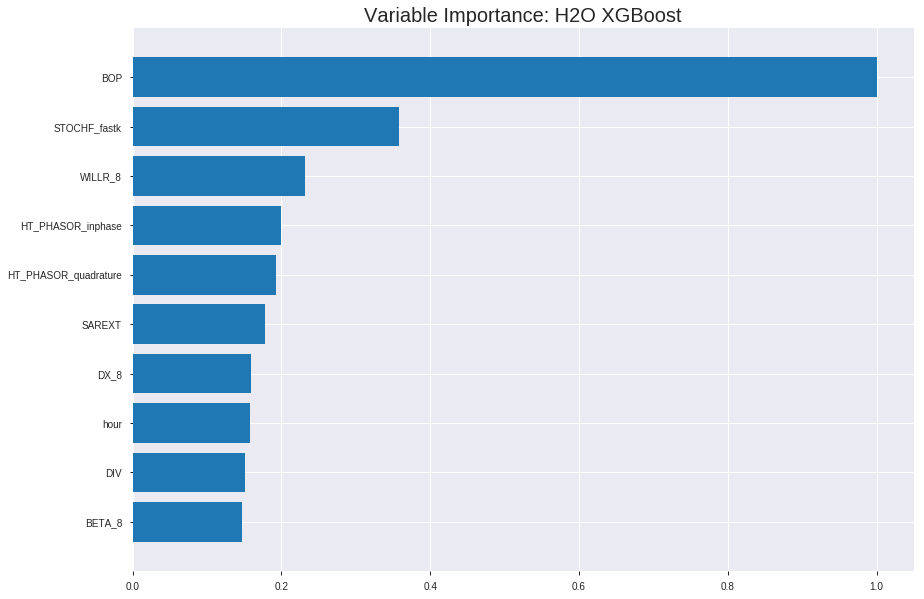

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_043837_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12908813691058135
RMSE: 0.35928837569643324
LogLoss: 0.42280374106470986
Mean Per-Class Error: 0.13955803843589942
AUC: 0.9396412231572591
pr_auc: 0.9410112022459094
Gini: 0.8792824463145181
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46687036752700806: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      495  103  0.1722   (103.0/598.0)
1      66   521  0.1124   (66.0/587.0)
Total  561  624  0.1426   (169.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46687      0.860446  212
max f2                       0.332155     0.898841  284
max f0point5                 0.588156     0.893553  151
max accuracy                 0.509336     0.860759  188
max precision                0.948321     1         0
max recall                   0.237483     1         329
max specificity              0.948321     1         0
max absolute_mcc             0.509336     0.723391  188
max min_per_class_accuracy   0.484956     0.856187  201
max mean_per_class_accuracy  0.506782     0.860442  189

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.26 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.931407           2.01874    2.01874            1                0.940749  1                           0.940749            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.919597           2.01874    2.01874            1                0.924846  1                           0.932798            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.907353           2.01874    2.01874            1                0.91499   1                           0.926862            0.0204429       0.0613288                  101.874   101.874
    4        0.0405063                   0.898257           2.01874    2.01874            1                0.902458  1                           0.920761            0.0204429       0.0817717                  101.874   101.874
    5        0.0506329                   0.889675           2.01874    2.01874            1                0.893895  1                           0.915388            0.0204429       0.102215                   101.874   101.874
    6        0.100422                    0.82801            2.01874    2.01874            1                0.858234  1                           0.887051            0.100511        0.202726                   101.874   101.874
    7        0.150211                    0.768528           2.01874    2.01874            1                0.796509  1                           0.85704             0.100511        0.303237                   101.874   101.874
    8        0.2                         0.712626           1.98452    2.01022            0.983051         0.738512  0.995781                    0.827533            0.0988075       0.402044                   98.4523   101.022
    9        0.300422                    0.633778           1.86606    1.96203            0.92437          0.672789  0.97191                     0.775807            0.187394        0.589438                   86.6062   96.2033
    10       0.4                         0.566003           1.64236    1.88245            0.813559         0.598774  0.932489                    0.731735            0.163543        0.752981                   64.2364   88.2453
    11       0.500422                    0.484029           1.08571    1.72257            0.537815         0.517544  0.853288                    0.688753            0.109029        0.86201                    8.57086   72.2567
    12       0.6                         0.416115           0.632995   1.54174            0.313559         0.448629  0.763713                    0.648901            0.0630324       0.925043                   -36.7005  54.1738
    13       0.699578                    0.339544           0.427699   1.38317            0.211864         0.379735  0.685163                    0.610588            0.0425894       0.967632                   -57.2301  38.3165
    14       0.8                         0.246626           0.288391   1.24574            0.142857         0.294443  0.617089                    0.570903            0.0289608       0.996593                   -71.1609  24.5741
    15       0.899578                    0.180371           0.0342159  1.11163            0.0169492        0.213235  0.550657                    0.531311            0.00340716      1                          -96.5784  11.1632
    16       1                           0.0830551          0          1                  0                0.146066  0.495359                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.205774508428056
RMSE: 0.45362375205455896
LogLoss: 0.5980130003674932
Mean Per-Class Error: 0.31189192972632473
AUC: 0.7402883740463357
pr_auc: 0.6913321663650015
Gini: 0.4805767480926715
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3256801664829254: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      73   109  0.5989   (109.0/182.0)
1      15   142  0.0955   (15.0/157.0)
Total  88   251  0.3658   (124.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.32568      0.696078  250
max f2                       0.199375     0.829787  311
max f0point5                 0.497559     0.659062  157
max accuracy                 0.497559     0.684366  157
max precision                0.9382       1         0
max recall                   0.109161     1         337
max specificity              0.9382       1         0
max absolute_mcc             0.453368     0.376216  181
max min_per_class_accuracy   0.478217     0.67033   165
max mean_per_class_accuracy  0.453368     0.688108  181

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 47.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.917113           1.61943   1.61943            0.75             0.931634  0.75                        0.931634            0.0191083       0.0191083                  61.9427   61.9427
    2        0.020649                    0.881806           2.15924   1.85077            1                0.894808  0.857143                    0.915851            0.0191083       0.0382166                  115.924   85.0773
    3        0.0324484                   0.839929           1.61943   1.76665            0.75             0.85093   0.818182                    0.892244            0.0191083       0.0573248                  61.9427   76.6647
    4        0.0412979                   0.815856           2.15924   1.85077            1                0.824387  0.857143                    0.877703            0.0191083       0.0764331                  115.924   85.0773
    5        0.0501475                   0.806263           2.15924   1.90521            1                0.811398  0.882353                    0.866002            0.0191083       0.0955414                  115.924   90.5208
    6        0.100295                    0.733248           1.65118   1.77819            0.764706         0.769583  0.823529                    0.817793            0.0828025       0.178344                   65.118    77.8194
    7        0.150442                    0.693332           1.65118   1.73586            0.764706         0.714767  0.803922                    0.783451            0.0828025       0.261146                   65.118    73.5856
    8        0.20059                     0.648074           1.01611   1.55592            0.470588         0.675112  0.720588                    0.756366            0.0509554       0.312102                   1.61109   55.592
    9        0.300885                    0.594131           1.39715   1.503              0.647059         0.619331  0.696078                    0.710688            0.140127        0.452229                   39.7152   50.2997
    10       0.40118                     0.542346           1.14312   1.41303            0.529412         0.567071  0.654412                    0.674783            0.11465         0.566879                   14.3125   41.3029
    11       0.501475                    0.473802           1.20663   1.37175            0.558824         0.504533  0.635294                    0.640733            0.121019        0.687898                   20.6632   37.175
    12       0.59882                     0.411733           1.0469    1.31894            0.484848         0.444484  0.610837                    0.608831            0.101911        0.789809                   4.69021   31.8942
    13       0.699115                    0.343302           0.762083  1.23906            0.352941         0.372538  0.57384                     0.574932            0.0764331       0.866242                   -23.7917  23.9055
    14       0.79941                     0.283074           0.635069  1.16328            0.294118         0.31853   0.538745                    0.542764            0.0636943       0.929936                   -36.4931  16.3278
    15       0.899705                    0.215015           0.444549  1.08316            0.205882         0.246582  0.501639                    0.509747            0.044586        0.974522                   -55.5451  8.31576
    16       1                           0.0841634          0.254028  1                  0.117647         0.168989  0.463127                    0.47557            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:38:47  5.697 sec   0                  0.5              0.693147            0.5             0                  1                0.504641                         0.5                0.693147              0.5               0                    1                  0.536873
    2019-07-25 04:38:47  5.758 sec   5                  0.469349         0.63329             0.862553        0.817252           2.01874          0.23038                          0.483392           0.660304              0.730507          0.676596             1.79936            0.330383
    2019-07-25 04:38:47  5.802 sec   10                 0.446056         0.588902            0.87871         0.883632           2.01874          0.238819                         0.470911           0.635707              0.737716          0.691166             2.15924            0.333333
    2019-07-25 04:38:48  5.852 sec   15                 0.429191         0.556626            0.885383        0.887573           2.01874          0.232911                         0.463623           0.620999              0.744401          0.704083             2.15924            0.336283
    2019-07-25 04:38:48  5.896 sec   20                 0.415639         0.530329            0.892591        0.896431           2.01874          0.202532                         0.457691           0.60886               0.74972           0.701972             1.61943            0.327434
    2019-07-25 04:38:48  5.949 sec   25                 0.405428         0.510358            0.900651        0.904349           2.01874          0.188186                         0.454243           0.601392              0.752082          0.701809             1.61943            0.324484
    2019-07-25 04:38:48  5.998 sec   30                 0.39661          0.493166            0.90643         0.909899           2.01874          0.190717                         0.452876           0.598352              0.752852          0.700244             1.61943            0.300885
    2019-07-25 04:38:48  6.043 sec   35                 0.387675         0.475749            0.913894        0.918887           2.01874          0.187342                         0.453886           0.599704              0.743473          0.689549             1.61943            0.318584
    2019-07-25 04:38:48  6.109 sec   40                 0.380822         0.462154            0.918644        0.919727           2.01874          0.167932                         0.453299           0.598035              0.743998          0.692514             1.61943            0.315634
    2019-07-25 04:38:48  6.165 sec   45                 0.373957         0.449157            0.924869        0.928177           2.01874          0.15865                          0.453173           0.597016              0.741093          0.692446             1.61943            0.342183
    2019-07-25 04:38:48  6.232 sec   50                 0.36504          0.433112            0.9342          0.938104           2.01874          0.151055                         0.453588           0.597652              0.739588          0.690229             1.61943            0.362832
    2019-07-25 04:38:48  6.282 sec   55                 0.359288         0.422804            0.939641        0.941011           2.01874          0.142616                         0.453624           0.598013              0.740288          0

Variable Importances: 


variable              relative_importance    scaled_importance      percentage
--------------------  ---------------------  ---------------------  ---------------------
BOP                   1466.24365234375       1.0                    0.19883592686485083
STOCHF_fastk          525.322265625          0.3582776060344997     0.07123845987078962
WILLR_8               339.767333984375       0.2317263801560309     0.04607552957736118
HT_PHASOR_inphase     293.4140319824219      0.2001127380932955     0.039789601756243555
HT_PHASOR_quadrature  282.6404113769531      0.19276496844515592    0.0383286011678663
---                   ---                    ---                    ---
CEIL                  10.938547134399414     0.007460251996258909   0.0014833661203214937
days_in_month         5.119261741638184      0.0034914127222001505  0.0006942182846863989
CDLBELTHOLD           4.767580032348633      0.003251560560707484   0.0006465270578454666
CDLENGULFING          2.6207990646362305     0.0017874239799415025  0.0003554041037521292
CDLRICKSHAWMAN        0.8647509217262268     0.0005897730028320644  0.0001172680616579798


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6941176470588235)

('F1', 0.6604651162790697)

('auc', 0.7013333333333334)

('logloss', 0.6438624336773302)

('mean_per_class_error', 0.3087719298245615)

('rmse', 0.47264024535476984)

('mse', 0.22338880152901702)

xgboost prediction progress: |████████████████████████████████████████████| 100%


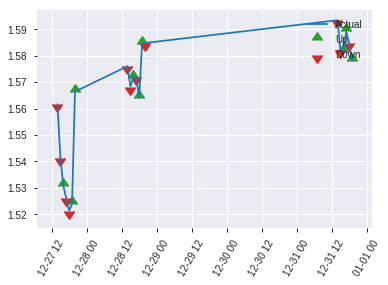


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22338880152901702
RMSE: 0.47264024535476984
LogLoss: 0.6438624336773302
Mean Per-Class Error: 0.3087719298245615
AUC: 0.7013333333333334
pr_auc: 0.5861253874284452
Gini: 0.40266666666666673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19717317819595337: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      26   69   0.7263   (69.0/95.0)
1      4    71   0.0533   (4.0/75.0)
Total  30   140  0.4294   (73.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.197173     0.660465  139
max f2                       0.17393      0.812918  148
max f0point5                 0.43709      0.652742  76
max accuracy                 0.43709      0.694118  76
max precision                0.931199     1         0
max recall                   0.127439     1         163
max specificity              0.931199     1         0
max absolute_mcc             0.43709      0.381494  76
max min_per_class_accuracy   0.43709      0.666667  76
max mean_per_class_accuracy  0.43709      0.691228  76

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 43.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.905604           1.13333   1.13333            0.5              0.919073  0.5                         0.919073            0.0133333       0.0133333                  13.3333   13.3333
    2        0.0235294                   0.883126           2.26667   1.7                1                0.897427  0.75                        0.90825             0.0266667       0.04                       126.667   70
    3        0.0352941                   0.866146           0         1.13333            0                0.869334  0.5                         0.895278            0               0.04                       -100      13.3333
    4        0.0411765                   0.860775           0         0.971429           0                0.861171  0.428571                    0.890406            0               0.04                       -100      -2.85714
    5        0.0529412                   0.844412           1.13333   1.00741            0.5              0.858713  0.444444                    0.883363            0.0133333       0.0533333                  13.3333   0.740741
    6        0.1                         0.776781           1.7       1.33333            0.75             0.796485  0.588235                    0.842479            0.08            0.133333                   70        33.3333
    7        0.152941                    0.712292           1.76296   1.48205            0.777778         0.744935  0.653846                    0.808714            0.0933333       0.226667                   76.2963   48.2051
    8        0.2                         0.64345            1.41667   1.46667            0.625            0.681348  0.647059                    0.778746            0.0666667       0.293333                   41.6667   46.6667
    9        0.3                         0.566926           1.46667   1.46667            0.647059         0.608467  0.647059                    0.721986            0.146667        0.44                       46.6667   46.6667
    10       0.4                         0.481919           1.2       1.4                0.529412         0.524817  0.617647                    0.672694            0.12            0.56                       20        40
    11       0.5                         0.407287           1.2       1.36               0.529412         0.439487  0.6                         0.626053            0.12            0.68                       20        36
    12       0.6                         0.333351           0.666667  1.24444            0.294118         0.362562  0.54902                     0.582138            0.0666667       0.746667                   -33.3333  24.4444
    13       0.7                         0.262227           0.8       1.18095            0.352941         0.294636  0.521008                    0.541066            0.08            0.826667                   -20       18.0952
    14       0.8                         0.207725           0.933333  1.15               0.411765         0.233052  0.507353                    0.502564            0.0933333       0.92                       -6.66667  15
    15       0.9                         0.162918           0.533333  1.08148            0.235294         0.187031  0.477124                    0.467505            0.0533333       0.973333                   -46.6667  8.14815
    16       1                           0.0888772          0.266667  1                  0.117647         0.137603  0.441176                    0.434515            0.0266667      

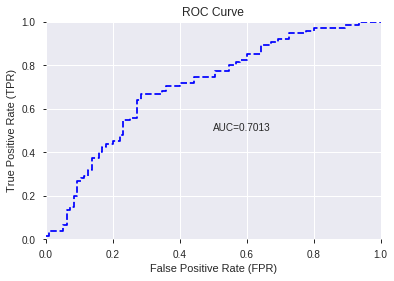

This function is available for GLM models only


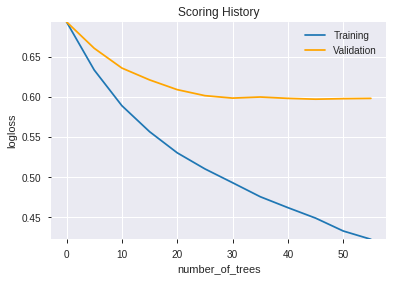

--2019-07-25 04:38:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_043837_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_043837_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'WILLR_8',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'SAREXT',
 'DX_8',
 'hour',
 'DIV',
 'BETA_8',
 'HT_DCPERIOD',
 'PLUS_DI_30',
 'ULTOSC',
 'MOM_30',
 'Volume',
 'WILLR_14',
 'STOCHRSI_fastd',
 'TRANGE',
 'CORREL_12',
 'STOCHRSI_fastk',
 'CORREL_8',
 'MFI_24',
 'ROC_30',
 'aroonup_12',
 'CORREL_14',
 'WILLR_30',
 'aroonup_30',
 'LINEARREG_ANGLE_12',
 'SUB',
 'aroondown_30',
 'aroonup_14',
 'LINEARREG_SLOPE_12',
 'CDLCLOSINGMARUBOZU',
 'CDLSHOOTINGSTAR',
 'CDLSHORTLINE',
 'CDLDRAGONFLYDOJI',
 'ROCP_30',
 'CDLLONGLINE',
 'ROCR_30',
 'CDLTAKURI',
 'CEIL',
 'days_in_month',
 'CDLBELTHOLD',
 'CDLENGULFING',
 'CDLRICKSHAWMAN']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_043903_model_1  0.658667  0.663487              0.438246  0.483928  0.234186

variable  relative_importance  scaled_importance    percentage
0                         BOP         1.360890e-01           1.000000  3.822656e-02
1          CDLCLOSINGMARUBOZU         8.641890e-02           0.635018  2.427454e-02
2                 CDLLONGLINE         8.354161e-02           0.613875  2.346633e-02
3                        hour         5.911405e-02           0.434378  1.660477e-02
4                STOCHF_fastk         5.699632e-02           0.418817  1.600992e-02
...                       ...                  ...                ...           ...
1027                 MAVP_8_6         3.582979e-06           0.000026  1.006437e-06
1028  BBANDS_lowerband_24_7_4         2.917630e-06           0.000021  8.195443e-07
1029  BBANDS_lowerband_14_5_3         1.947003e-06           0.000014  5.469011e-07
1030                   EMA_20         4.711850e-07           0.000003  1.323530e-07
1031  BBANDS_upperband_20_7_4         2.095810e-07           0.000002  5.887002e-08

[1032 rows x 4 columns]

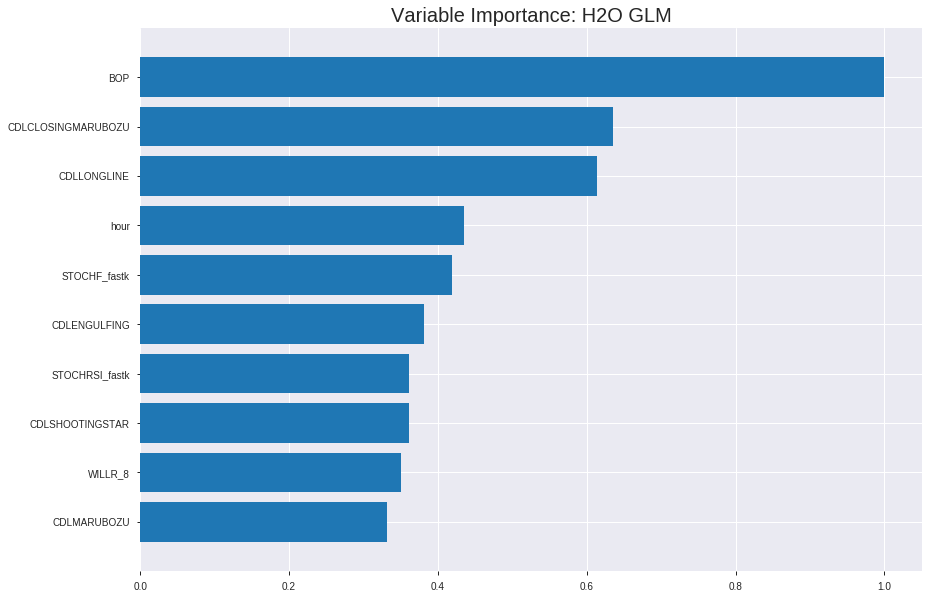

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_043903_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20251823675924183
RMSE: 0.4500202626096316
LogLoss: 0.5925122780786214
Null degrees of freedom: 1184
Residual degrees of freedom: 152
Null deviance: 1642.6567067559345
Residual deviance: 1404.2540990463326
AIC: 3470.2540990463326
AUC: 0.7726735341541652
pr_auc: 0.7736556050906327
Gini: 0.5453470683083304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41045809858975457: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      273  325  0.5435   (325.0/598.0)
1      72   515  0.1227   (72.0/587.0)
Total  345  840  0.335    (397.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410458     0.721794  268
max f2                       0.3115       0.838244  331
max f0point5                 0.53465      0.71091   170
max accuracy                 0.497941     0.703797  199
max precision                0.881558     1         0
max recall                   0.174812     1         388
max specificity              0.881558     1         0
max absolute_mcc             0.53465      0.409011  170
max min_per_class_accuracy   0.500473     0.698997  197
max mean_per_class_accuracy  0.497229     0.703889  200

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.810288           2.01874   2.01874            1                0.830505  1                           0.830505            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.786249           2.01874   2.01874            1                0.798939  1                           0.814722            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.763095           1.85051   1.96266            0.916667         0.772818  0.972222                    0.800754            0.0187394       0.0596252                  85.0511   96.2663
    4        0.0405063                   0.745556           2.01874   1.97668            1                0.753245  0.979167                    0.788877            0.0204429       0.0800681                  101.874   97.6682
    5        0.0506329                   0.72766            2.01874   1.98509            1                0.736077  0.983333                    0.778317            0.0204429       0.100511                   101.874   98.5094
    6        0.100422                    0.681164           1.7108    1.8491             0.847458         0.700794  0.915966                    0.739881            0.0851789       0.18569                    71.0796   84.9097
    7        0.150211                    0.650559           1.64236   1.78057            0.813559         0.664238  0.882022                    0.714808            0.0817717       0.267462                   64.2364   78.0573
    8        0.2                         0.624515           1.40285   1.68654            0.694915         0.63737   0.835443                    0.695531            0.0698467       0.337308                   40.2853   68.6542
    9        0.300422                    0.580158           1.30624   1.55942            0.647059         0.601337  0.772472                    0.664044            0.131175        0.468484                   30.6243   55.9419
    10       0.4                         0.539052           1.24888   1.48211            0.618644         0.557441  0.734177                    0.637506            0.124361        0.592845                   24.8881   48.2112
    11       0.500422                    0.499248           1.10267   1.40597            0.546218         0.51935   0.696459                    0.613795            0.110733        0.703578                   10.2673   40.5969
    12       0.6                         0.461729           0.872506  1.31743            0.432203         0.480724  0.652602                    0.59171             0.0868825       0.79046                    -12.7494  31.7433
    13       0.699578                    0.414288           0.786966  1.24193            0.389831         0.438033  0.615199                    0.569836            0.0783646       0.868825                   -21.3034  24.1927
    14       0.8                         0.363173           0.644639  1.16695            0.319328         0.389491  0.578059                    0.547198            0.0647359       0.93356                    -35.5361  16.6951
    15       0.899578                    0.300109           0.376375  1.07944            0.186441         0.332125  0.534709                    0.52339             0.0374787       0.971039                   -62.3625  7.94385
    16       1                           0.13076            0.288391  1                  0.142857         0.244252  0.495359                    0.495359         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.22493580827028434
RMSE: 0.47427398017420724
LogLoss: 0.6414106529014082
Null degrees of freedom: 338
Residual degrees of freedom: -694
Null deviance: 469.5188524558861
Residual deviance: 434.87642266715477
AIC: 2500.8764226671547
AUC: 0.728424441800238
pr_auc: 0.6645550375227666
Gini: 0.45684888360047604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4170994647486896: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      45   137  0.7527   (137.0/182.0)
1      3    154  0.0191   (3.0/157.0)
Total  48   291  0.413    (140.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417099     0.6875    290
max f2                       0.417099     0.837867  290
max f0point5                 0.593936     0.663601  150
max accuracy                 0.593936     0.687316  150
max precision                0.828558     1         0
max recall                   0.231881     1         337
max specificity              0.828558     1         0
max absolute_mcc             0.593936     0.369792  150
max min_per_class_accuracy   0.585533     0.681319  164
max mean_per_class_accuracy  0.584979     0.684608  165

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 56.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.818881           1.61943   1.61943            0.75             0.824722  0.75                        0.824722            0.0191083       0.0191083                  61.9427   61.9427
    2        0.020649                    0.804062           2.15924   1.85077            1                0.810249  0.857143                    0.81852             0.0191083       0.0382166                  115.924   85.0773
    3        0.0324484                   0.792616           2.15924   1.96294            1                0.796767  0.909091                    0.81061             0.0254777       0.0636943                  115.924   96.2942
    4        0.0412979                   0.778924           0.719745  1.69654            0.333333         0.783831  0.785714                    0.804871            0.00636943      0.0700637                  -28.0255  69.6542
    5        0.0501475                   0.769191           2.15924   1.77819            1                0.777368  0.823529                    0.800018            0.0191083       0.089172                   115.924   77.8194
    6        0.100295                    0.727206           1.39715   1.58767            0.647059         0.750738  0.735294                    0.775378            0.0700637       0.159236                   39.7152   58.7673
    7        0.150442                    0.698798           1.52417   1.5665             0.705882         0.714047  0.72549                     0.754934            0.0764331       0.235669                   52.4166   56.6504
    8        0.20059                     0.67443            1.90521   1.65118            0.882353         0.683997  0.764706                    0.7372              0.0955414       0.33121                    90.5208   65.118
    9        0.300885                    0.640721           1.20663   1.503              0.558824         0.658513  0.696078                    0.710971            0.121019        0.452229                   20.6632   50.2997
    10       0.40118                     0.606848           1.14312   1.41303            0.529412         0.625597  0.654412                    0.689627            0.11465         0.566879                   14.3125   41.3029
    11       0.501475                    0.581895           1.27014   1.38445            0.588235         0.593399  0.641176                    0.670382            0.127389        0.694268                   27.0139   38.4451
    12       0.59882                     0.540049           0.850608  1.29767            0.393939         0.563433  0.600985                    0.652996            0.0828025       0.77707                    -14.9392  29.7669
    13       0.699115                    0.488031           0.571562  1.1935             0.264706         0.514204  0.552743                    0.633085            0.0573248       0.834395                   -42.8438  19.3502
    14       0.79941                     0.44772            0.952604  1.16328            0.441176         0.467775  0.538745                    0.612345            0.0955414       0.929936                   -4.7396   16.3278
    15       0.899705                    0.384249           0.508055  1.09024            0.235294         0.419768  0.504918                    0.590877            0.0509554       0.980892                   -49.1945  9.0237
    16       1                           0.181156           0.190521  1                  0.0882353        0.316612  0.463127                    0.56337            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:39:06  0.000 sec   2            20        1032          1.35357           1.36441
    2019-07-25 04:39:07  1.322 sec   4            15        1033          1.3459            1.35863
    2019-07-25 04:39:08  2.658 sec   6            11        1033          1.33672           1.35189
    2019-07-25 04:39:10  3.981 sec   8            7.9       1033          1.32583           1.34401
    2019-07-25 04:39:11  5.319 sec   10           5.7       1033          1.31304           1.33515
    2019-07-25 04:39:12  6.676 sec   12           4.2       1033          1.29832           1.32545
    2019-07-25 04:39:14  8.008 sec   14           3         1033          1.28178           1.31547
    2019-07-25 04:39:15  9.316 sec   16           2.2       1033          1.26367           1.30573
    2019-07-25 04:39:16  10.627 sec  18           1.6       1033          1.24442           1.29693
    2019-07-25 04:39:17  11.960 sec  20           1.2       1033          1.22454           1.28972
    2019-07-25 04:39:19  13.262 sec  22           0.85      1033          1.2046            1.28489
    2019-07-25 04:39:20  14.676 sec  24           0.62      1033          1.18502           1.28282
    2019-07-25 04:39:22  16.196 sec  26           0.45      1033          1.16624           1.28417
    2019-07-25 04:39:23  17.537 sec  28           0.33      1033          1.1485            1.2892
    2019-07-25 04:39:24  18.864 sec  30           0.24      1033          1.13194           1.29797
    2019-07-25 04:39:26  20.209 sec  32           0.17      1033          1.11659           1.31017
    2019-07-25 04:39:27  21.534 sec  34           0.13      1033          1.10239           1.32495

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6882352941176471)

('F1', 0.6406926406926406)

('auc', 0.6586666666666666)

('logloss', 0.6634869105297183)

('mean_per_class_error', 0.32666666666666666)

('rmse', 0.4839276108642879)

('mse', 0.2341859325568177)

glm prediction progress: |████████████████████████████████████████████████| 100%


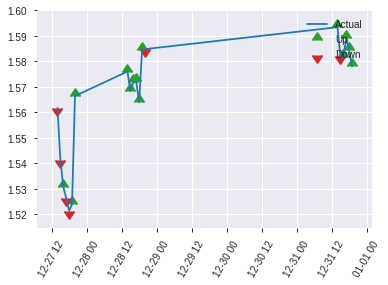


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2341859325568177
RMSE: 0.4839276108642879
LogLoss: 0.6634869105297183
Null degrees of freedom: 169
Residual degrees of freedom: -863
Null deviance: 235.31337198870415
Residual deviance: 225.58554958010427
AIC: 2291.5855495801043
AUC: 0.6586666666666666
pr_auc: 0.5672939753275329
Gini: 0.31733333333333325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2829018471945597: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      13   82   0.8632   (82.0/95.0)
1      1    74   0.0133   (1.0/75.0)
Total  14   156  0.4882   (83.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.282902     0.640693  155
max f2                       0.282902     0.811404  155
max f0point5                 0.58037      0.652174  55
max accuracy                 0.58037      0.688235  55
max precision                0.58037      0.696429  55
max recall                   0.232562     1         164
max specificity              0.899871     0.989474  0
max absolute_mcc             0.58037      0.360303  55
max min_per_class_accuracy   0.514431     0.6       81
max mean_per_class_accuracy  0.570008     0.673333  59

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 50.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.840871           0         0                  0                0.878252  0                           0.878252            0               0                          -100      -100
    2        0.0235294                   0.809376           2.26667   1.13333            1                0.826172  0.5                         0.852212            0.0266667       0.0266667                  126.667   13.3333
    3        0.0352941                   0.791052           1.13333   1.13333            0.5              0.793063  0.5                         0.832496            0.0133333       0.04                       13.3333   13.3333
    4        0.0411765                   0.772832           2.26667   1.29524            1                0.782083  0.571429                    0.825294            0.0133333       0.0533333                  126.667   29.5238
    5        0.0529412                   0.751751           1.13333   1.25926            0.5              0.765752  0.555556                    0.812063            0.0133333       0.0666667                  13.3333   25.9259
    6        0.1                         0.707809           1.7       1.46667            0.75             0.725769  0.647059                    0.771454            0.08            0.146667                   70        46.6667
    7        0.152941                    0.681873           1.25926   1.39487            0.555556         0.693239  0.615385                    0.744379            0.0666667       0.213333                   25.9259   39.4872
    8        0.2                         0.657289           1.7       1.46667            0.75             0.669621  0.647059                    0.726789            0.08            0.293333                   70        46.6667
    9        0.3                         0.586853           1.73333   1.55556            0.764706         0.616657  0.686275                    0.690078            0.173333        0.466667                   73.3333   55.5556
    10       0.4                         0.550511           0.8       1.36667            0.352941         0.57212   0.602941                    0.660589            0.08            0.546667                   -20       36.6667
    11       0.5                         0.510102           0.8       1.25333            0.352941         0.528913  0.552941                    0.634254            0.08            0.626667                   -20       25.3333
    12       0.6                         0.464534           0.933333  1.2                0.411765         0.487495  0.529412                    0.609794            0.0933333       0.72                       -6.66667  20
    13       0.7                         0.420235           0.266667  1.06667            0.117647         0.443884  0.470588                    0.586093            0.0266667       0.746667                   -73.3333  6.66667
    14       0.8                         0.366107           1.33333   1.1                0.588235         0.396104  0.485294                    0.562344            0.133333        0.88                       33.3333   10
    15       0.9                         0.301069           0.933333  1.08148            0.411765         0.331492  0.477124                    0.536694            0.0933333       0.973333                   -6.66667  8.14815
    16       1                           0.17366            0.266667  1                  0.117647         0.244912  0.441176                    0.507516            0.0266667 

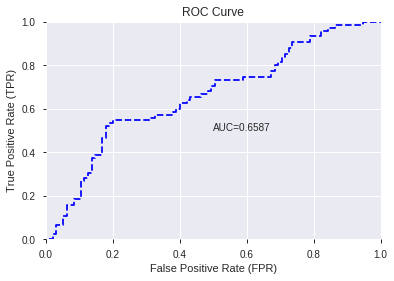

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


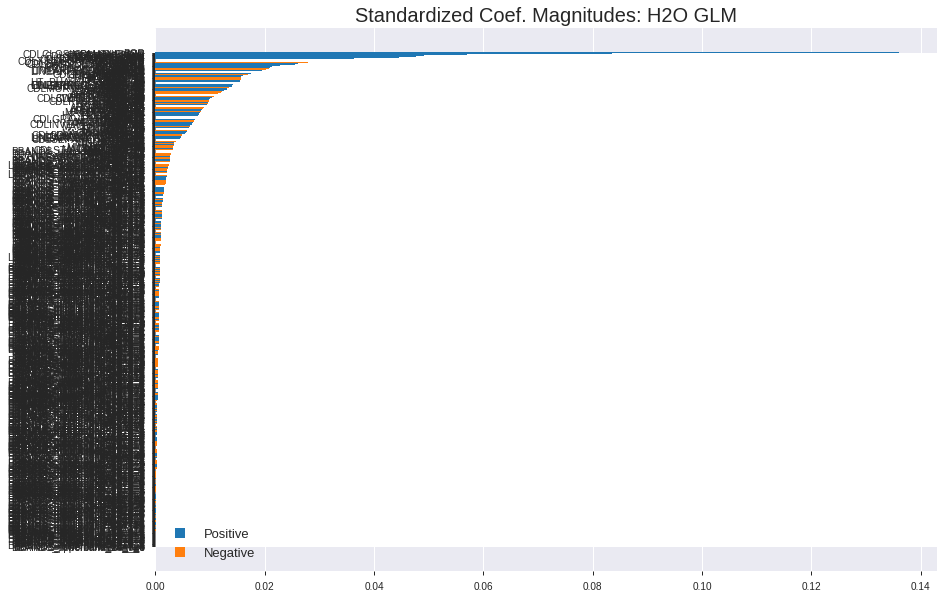

'log_likelihood'
--2019-07-25 04:39:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.36
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.36|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_043903_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_043903_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

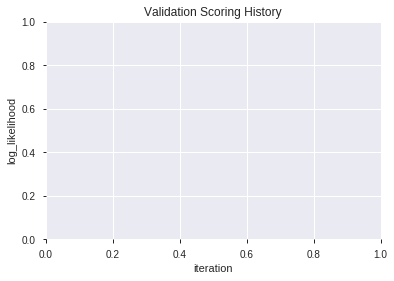

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_043957_model_6  0.692070  0.643742              0.329474  0.473383  0.224091
1  XGBoost_grid_1_AutoML_20190725_043957_model_1  0.686596  0.660813              0.384561  0.478255  0.228728
2  XGBoost_grid_1_AutoML_20190725_043957_model_2  0.685895  0.646549              0.309825  0.474599  0.225245
3  XGBoost_grid_1_AutoML_20190725_043957_model_4  0.685895  0.642975              0.360000  0.474298  0.224959
4               XGBoost_2_AutoML_20190725_043957  0.678877  0.652736              0.407018  0.477644  0.228144
5               XGBoost_3_AutoML_20190725_043957  0.675930  0.665874              0.436842  0.480293  0.230681
6  XGBoost_grid_1_AutoML_20190725_043957_model_7  0.665684  0.672400              0.432982  0.485590  0.235797
7  XGBoost_grid_1_AutoML_20190725_043957_model_3  0.661333  0.673275              0.426316  0.485755  0.235958
8               XGBoost_1_AutoML_20190725_043957  0.657544  0.672372              0.420000  0.485928  0.236126
9  XGBoost_grid_1_AutoML_20190725_043957_model_5  0.652912  0.695270              0.429123  0.493314  0.243359

variable  relative_importance  scaled_importance  percentage
0                        BOP          1436.572266           1.000000    0.187229
1               STOCHF_fastk           400.792023           0.278992    0.052235
2                       hour           159.979843           0.111362    0.020850
3       HT_PHASOR_quadrature           142.508911           0.099201    0.018573
4                        DIV           130.641922           0.090940    0.017027
..                       ...                  ...                ...         ...
256  BBANDS_upperband_24_0_4             2.433491           0.001694    0.000317
257                 TRIMA_30             2.381003           0.001657    0.000310
258          MACDFIX_hist_24             2.375174           0.001653    0.000310
259                      Low             2.015402           0.001403    0.000263
260                   CMO_24             1.512021           0.001053    0.000197

[261 rows x 4 columns]

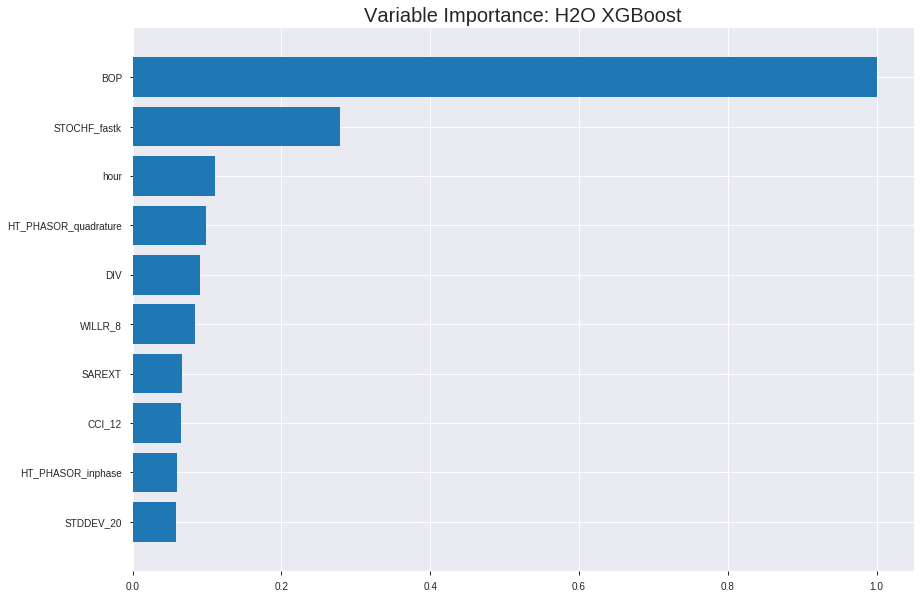

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_043957_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12516966606939064
RMSE: 0.3537932532841612
LogLoss: 0.41626183100512737
Mean Per-Class Error: 0.11908377157247618
AUC: 0.9526844165389459
pr_auc: 0.9543365558265355
Gini: 0.9053688330778917
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5007952451705933: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      533  65   0.1087   (65.0/598.0)
1      76   511  0.1295   (76.0/587.0)
Total  609  576  0.119    (141.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500795     0.878762  203
max f2                       0.381579     0.909818  263
max f0point5                 0.571371     0.907985  169
max accuracy                 0.523375     0.881013  192
max precision                0.933814     1         0
max recall                   0.233348     1         335
max specificity              0.933814     1         0
max absolute_mcc             0.523375     0.764445  192
max min_per_class_accuracy   0.494309     0.875639  206
max mean_per_class_accuracy  0.500795     0.880916  203

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.921743           2.01874   2.01874            1                0.927831  1                           0.927831            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.912485           2.01874   2.01874            1                0.918152  1                           0.922992            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.903043           2.01874   2.01874            1                0.908073  1                           0.918019            0.0204429       0.0613288                  101.874   101.874
    4        0.0405063                   0.890608           2.01874   2.01874            1                0.896639  1                           0.912674            0.0204429       0.0817717                  101.874   101.874
    5        0.0506329                   0.877828           2.01874   2.01874            1                0.885295  1                           0.907198            0.0204429       0.102215                   101.874   101.874
    6        0.100422                    0.807951           2.01874   2.01874            1                0.843078  1                           0.875408            0.100511        0.202726                   101.874   101.874
    7        0.150211                    0.752632           2.01874   2.01874            1                0.779132  1                           0.843496            0.100511        0.303237                   101.874   101.874
    8        0.2                         0.710002           1.95031   2.0017             0.966102         0.730581  0.991561                    0.815387            0.0971039       0.400341                   95.0308   100.17
    9        0.300422                    0.644318           1.95088   1.98472            0.966387         0.676652  0.983146                    0.769012            0.195911        0.596252                   95.0883   98.4716
    10       0.4                         0.566156           1.7108    1.91652            0.847458         0.60782   0.949367                    0.728884            0.170358        0.76661                    71.0796   91.6525
    11       0.500422                    0.489686           1.1366    1.76001            0.563025         0.526388  0.871838                    0.688248            0.11414         0.88075                    13.6601   76.0014
    12       0.6                         0.431306           0.650103  1.57581            0.322034         0.459058  0.780591                    0.650211            0.0647359       0.945486                   -34.9897  57.5809
    13       0.699578                    0.345659           0.325051  1.39778            0.161017         0.387502  0.6924                      0.612817            0.032368        0.977853                   -67.4949  39.7776
    14       0.8                         0.246758           0.20357   1.24787            0.10084          0.293428  0.618143                    0.572725            0.0204429       0.998296                   -79.643   24.7871
    15       0.899578                    0.186251           0.017108  1.11163            0.00847458       0.215716  0.550657                    0.533206            0.00170358      1                          -98.2892  11.1632
    16       1                           0.0995064          0         1                  0                0.154134  0.495359                    0.495139          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2155367337801312
RMSE: 0.46425933892613425
LogLoss: 0.6206612361689512
Mean Per-Class Error: 0.33226009659130673
AUC: 0.7182403583677469
pr_auc: 0.6729843303248885
Gini: 0.4364807167354938
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4167952835559845: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      82   100  0.5495   (100.0/182.0)
1      22   135  0.1401   (22.0/157.0)
Total  104  235  0.3599   (122.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416795     0.688776  234
max f2                       0.23698      0.815047  328
max f0point5                 0.57467      0.660225  115
max accuracy                 0.57467      0.678466  115
max precision                0.914826     1         0
max recall                   0.212777     1         336
max specificity              0.914826     1         0
max absolute_mcc             0.57467      0.35259   115
max min_per_class_accuracy   0.510251     0.649682  161
max mean_per_class_accuracy  0.57467      0.66774   115

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 50.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.886168           1.61943   1.61943            0.75             0.900367  0.75                        0.900367            0.0191083       0.0191083                  61.9427   61.9427
    2        0.020649                    0.869671           2.15924   1.85077            1                0.877036  0.857143                    0.890368            0.0191083       0.0382166                  115.924   85.0773
    3        0.0324484                   0.834644           2.15924   1.96294            1                0.857006  0.909091                    0.878236            0.0254777       0.0636943                  115.924   96.2942
    4        0.0412979                   0.788481           2.15924   2.005              1                0.810794  0.928571                    0.863784            0.0191083       0.0828025                  115.924   100.5
    5        0.0501475                   0.756393           1.43949   1.90521            0.666667         0.769059  0.882353                    0.847068            0.0127389       0.0955414                  43.949    90.5208
    6        0.100295                    0.705887           1.52417   1.71469            0.705882         0.729171  0.794118                    0.78812             0.0764331       0.171975                   52.4166   71.4687
    7        0.150442                    0.672793           1.39715   1.60884            0.647059         0.692705  0.745098                    0.756315            0.0700637       0.242038                   39.7152   60.8842
    8        0.20059                     0.642461           1.65118   1.61943            0.764706         0.659885  0.75                        0.732207            0.0828025       0.324841                   65.118    61.9427
    9        0.300885                    0.589631           1.27014   1.503              0.588235         0.615004  0.696078                    0.69314             0.127389        0.452229                   27.0139   50.2997
    10       0.40118                     0.543317           1.07962   1.39715            0.5              0.569278  0.647059                    0.662174            0.10828         0.56051                    7.96178   39.7152
    11       0.501475                    0.498093           1.01611   1.32094            0.470588         0.521414  0.611765                    0.634022            0.101911        0.66242                    1.61109   32.0944
    12       0.59882                     0.44059            0.850608  1.24449            0.393939         0.467239  0.576355                    0.60691             0.0828025       0.745223                   -14.9392  24.4486
    13       0.699115                    0.412882           1.14312   1.22994            0.529412         0.426425  0.56962                     0.581017            0.11465         0.859873                   14.3125   22.9944
    14       0.79941                     0.358263           0.444549  1.13141            0.205882         0.389205  0.523985                    0.556952            0.044586        0.904459                   -55.5451  13.1408
    15       0.899705                    0.300492           0.571562  1.069              0.264706         0.327805  0.495082                    0.531408            0.0573248       0.961783                   -42.8438  6.89986
    16       1                           0.185366           0.381042  1                  0.176471         0.256492  0.463127                    0.503835           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:40:27  18.541 sec  0                  0.5              0.693147            0.5             0                  1                0.504641                         0.5                0.693147              0.5               0                    1                  0.536873
    2019-07-25 04:40:28  19.106 sec  5                  0.468126         0.630956            0.863573        0.85531            2.01874          0.218565                         0.485396           0.664233              0.717068          0.665546             1.61943            0.294985
    2019-07-25 04:40:28  19.271 sec  10                 0.44297          0.583293            0.892635        0.896863           2.01874          0.199156                         0.477592           0.648708              0.708301          0.664145             1.61943            0.345133
    2019-07-25 04:40:28  19.427 sec  15                 0.423687         0.546757            0.901248        0.905163           2.01874          0.200844                         0.469949           0.633463              0.725467          0.681363             1.61943            0.348083
    2019-07-25 04:40:28  19.577 sec  20                 0.408527         0.518272            0.914556        0.919004           2.01874          0.172152                         0.470269           0.633946              0.719203          0.677109             1.61943            0.339233
    2019-07-25 04:40:28  19.727 sec  25                 0.396456         0.495088            0.921013        0.92494            2.01874          0.167089                         0.466793           0.626712              0.724732          0.680993             1.61943            0.342183
    2019-07-25 04:40:28  19.877 sec  30                 0.385265         0.4734              0.924997        0.928472           2.01874          0.172996                         0.466532           0.625907              0.71929           0.679545             1.61943            0.386431
    2019-07-25 04:40:28  20.038 sec  35                 0.376365         0.457253            0.933734        0.937084           2.01874          0.151899                         0.465638           0.623948              0.720795          0.674262             1.61943            0.389381
    2019-07-25 04:40:29  20.200 sec  40                 0.367484         0.441343            0.943631        0.944589           2.01874          0.138397                         0.465457           0.623228              0.715126          0.670345             1.61943            0.39823
    2019-07-25 04:40:29  20.361 sec  45                 0.360355         0.4281              0.947995        0.95003            2.01874          0.12827                          0.465378           0.622788              0.714986          0.668717             1.61943            0.365782
    2019-07-25 04:40:29  20.517 sec  50                 0.353793         0.416262            0.952684        0.954337           2.01874          0.118987                         0.464259           0.620661              0.71824           0.672984             1.61943            0.359882

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1436.572265625         1.0                    0.18722903848771827
STOCHF_fastk             400.7920227050781      0.27899189779409267    0.052235384769851734
hour                     159.97984313964844     0.11136219664525339    0.020850237001770997
HT_PHASOR_quadrature     142.5089111328125      0.09920065599401788    0.018573243439110872
DIV                      130.6419219970703      0.09094002795622175    0.017026613994289615
---                      ---                    ---                    ---
BBANDS_upperband_24_0_4  2.433490753173828      0.0016939563789470106  0.0003171578240703857
TRIMA_30                 2.3810031414031982     0.001657419677643095   0.00031031709261574066
MACDFIX_hist_24          2.375173568725586      0.0016533617038000069  0.0003095573220748909
Low                      2.01540207862854       0.0014029242571738723  0.0002626681597417605
CMO_24                   1.5120210647583008     0.0010525200165273105  0.00019706231068348566


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6705882352941176)

('F1', 0.6545454545454547)

('auc', 0.6920701754385965)

('logloss', 0.6437422118290531)

('mean_per_class_error', 0.32561403508771924)

('rmse', 0.4733825961887951)

('mse', 0.22409108237444383)

xgboost prediction progress: |████████████████████████████████████████████| 100%


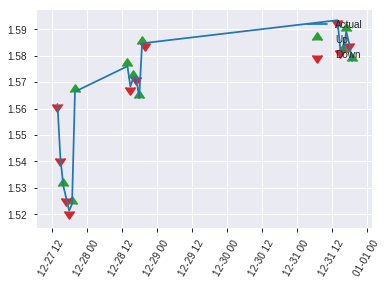


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22409108237444383
RMSE: 0.4733825961887951
LogLoss: 0.6437422118290531
Mean Per-Class Error: 0.32561403508771924
AUC: 0.6920701754385965
pr_auc: 0.5854133135119862
Gini: 0.384140350877193
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4466378390789032: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   36   0.3789   (36.0/95.0)
1      21   54   0.28     (21.0/75.0)
Total  80   90   0.3353   (57.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446638     0.654545  89
max f2                       0.169289     0.815217  159
max f0point5                 0.461051     0.626478  86
max accuracy                 0.461051     0.670588  86
max precision                0.925151     1         0
max recall                   0.169289     1         159
max specificity              0.925151     1         0
max absolute_mcc             0.461051     0.346446  86
max min_per_class_accuracy   0.482977     0.642105  82
max mean_per_class_accuracy  0.461051     0.674386  86

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 47.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.880778           2.26667   2.26667            1                0.903499  1                           0.903499            0.0266667       0.0266667                  126.667   126.667
    2        0.0235294                   0.86383            0         1.13333            0                0.872871  0.5                         0.888185            0               0.0266667                  -100      13.3333
    3        0.0352941                   0.85808            1.13333   1.13333            0.5              0.859958  0.5                         0.878776            0.0133333       0.04                       13.3333   13.3333
    4        0.0411765                   0.842752           2.26667   1.29524            1                0.849592  0.571429                    0.874607            0.0133333       0.0533333                  126.667   29.5238
    5        0.0529412                   0.832973           0         1.00741            0                0.840166  0.444444                    0.866953            0               0.0533333                  -100      0.740741
    6        0.1                         0.766457           1.7       1.33333            0.75             0.797732  0.588235                    0.834379            0.08            0.133333                   70        33.3333
    7        0.152941                    0.71917            2.01481   1.56923            0.888889         0.741112  0.692308                    0.802094            0.106667        0.24                       101.481   56.9231
    8        0.2                         0.677009           1.41667   1.53333            0.625            0.696579  0.676471                    0.777267            0.0666667       0.306667                   41.6667   53.3333
    9        0.3                         0.609644           1.46667   1.51111            0.647059         0.646053  0.666667                    0.733529            0.146667        0.453333                   46.6667   51.1111
    10       0.4                         0.521114           1.06667   1.4                0.470588         0.564888  0.617647                    0.691369            0.106667        0.56                       6.66667   40
    11       0.5                         0.469008           1.2       1.36               0.529412         0.499165  0.6                         0.652928            0.12            0.68                       20        36
    12       0.6                         0.382453           0.666667  1.24444            0.294118         0.421546  0.54902                     0.614364            0.0666667       0.746667                   -33.3333  24.4444
    13       0.7                         0.30715            0.8       1.18095            0.352941         0.344874  0.521008                    0.575866            0.08            0.826667                   -20       18.0952
    14       0.8                         0.254054           0.933333  1.15               0.411765         0.282114  0.507353                    0.539147            0.0933333       0.92                       -6.66667  15
    15       0.9                         0.200278           0.533333  1.08148            0.235294         0.22983   0.477124                    0.504778            0.0533333       0.973333                   -46.6667  8.14815
    16       1                           0.143992           0.266667  1                  0.117647         0.167771  0.441176                    0.471077            0.0266667  

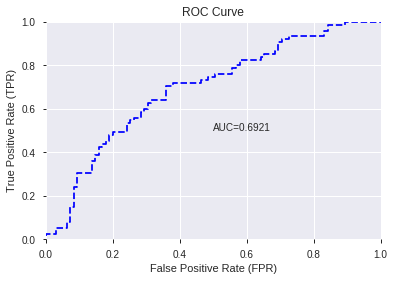

This function is available for GLM models only


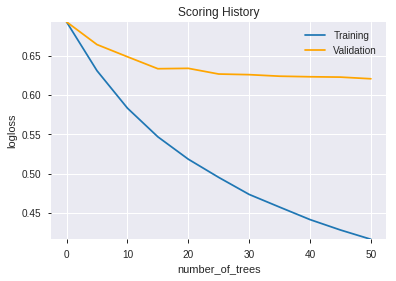

--2019-07-25 04:40:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTr

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_043957_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_043957_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_044044_model_8  0.652632  0.654033              0.433333  0.480197  0.230590
1  DeepLearning_grid_1_AutoML_20190725_044044_model_9  0.639018  0.668663              0.423860  0.486877  0.237049
2  DeepLearning_grid_1_AutoML_20190725_044044_model_6  0.634105  0.762294              0.420000  0.505009  0.255034
3  DeepLearning_grid_1_AutoML_20190725_044044_model_4  0.623439  1.524371              0.371228  0.588454  0.346278
4  DeepLearning_grid_1_AutoML_20190725_044044_model_7  0.615719  0.985357              0.439649  0.541929  0.293687
5               DeepLearning_1_AutoML_20190725_044044  0.614596  0.786061              0.407719  0.517344  0.267645
6  DeepLearning_grid_1_AutoML_20190725_044044_model_5  0.606596  0.690189              0.454035  0.493870  0.243908
7  DeepLearning_grid_1_AutoML_20190725_044044_model_3  0.564491  1.023927              0.444912  0.556311  0.309482
8  DeepLearning_grid_1_AutoML_20190725_044044_model_2  0.556211  0.987425              0.437193  0.562734  0.316670
9  DeepLearning_grid_1_AutoML_20190725_044044_model_1  0.544561  1.323203              0.441053  0.595852  0.355040

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.027655
1                   hour             0.798181           0.798181    0.022074
2     CDLCLOSINGMARUBOZU             0.782450           0.782450    0.021639
3            CDLMARUBOZU             0.780087           0.780087    0.021573
4                 Volume             0.773969           0.773969    0.021404
5            CDLLONGLINE             0.756368           0.756368    0.020917
6      CDLLONGLEGGEDDOJI             0.750178           0.750178    0.020746
7          CDLHANGINGMAN             0.748963           0.748963    0.020713
8             aroonup_14             0.748469           0.748469    0.020699
9         STOCHRSI_fastk             0.746951           0.746951    0.020657
10      CDLDRAGONFLYDOJI             0.745101           0.745101    0.020606
11              WILLR_14             0.742567           0.742567    0.020536
12            aroonup_30             0.739711           0.739711    0.020457
13          CDLSHORTLINE             0.739606           0.739606    0.020454
14                BETA_8             0.739418           0.739418    0.020449
15                SAREXT             0.730947           0.730947    0.020214
16         days_in_month             0.729174           0.729174    0.020165
17     HT_PHASOR_inphase             0.727112           0.727112    0.020108
18           HT_DCPERIOD             0.724166           0.724166    0.020027
19                  CEIL             0.721532           0.721532    0.019954
20          STOCHF_fastk             0.720581           0.720581    0.019928
21             CDLTAKURI             0.718724           0.718724    0.019876
22               ROCR_30             0.718075           0.718075    0.019858
23             CORREL_14             0.715156           0.715156    0.019778
24               CDLDOJI             0.712240           0.712240    0.019697
25                ROC_30             0.712139           0.712139    0.019694
26               ROCP_30             0.711362           0.711362    0.019673
27                TRANGE             0.709671           0.709671    0.019626
28                  DX_8             0.709650           0.709650    0.019625
29        CDLRICKSHAWMAN             0.708729           0.708729    0.019600
30              CORREL_8             0.705767           0.705767    0.019518
31          aroondown_30             0.705662           0.705662    0.019515
32    LINEARREG_ANGLE_12             0.705173           0.705173    0.019502
33             CORREL_12             0.704623           0.704623    0.019486
34              WILLR_30             0.701461           0.701461    0.019399
35                MFI_24             0.698722           0.698722    0.019323
36                   DIV             0.698406           0.698406    0.019314
37        STOCHRSI_fastd             0.696842           0.696842    0.019271
38       CDLSHOOTINGSTAR             0.694465           0.694465    0.019206
39          CDLENGULFING             0.694214           0.694214    0.019199
40                ULTOSC             0.693851           0.693851    0.019189
41            PLUS_DI_30             0.690508           0.690508    0.019096
42            ROCR100_30             0.690142           0.690142    0.019086
43            aroonup_12             0.687344           0.687344    0.019009
44                   SUB             0.683348           0.683348    0.018898
45               WILLR_8             0.680492           0.680492    0.018819
46                MOM_30             0.680380           0.680380    0.018816
47    LINEARREG_SLOPE_12             0.675376           0.675376    0.018678
48  HT_PHASOR_quadrature             0.668576           0.668576    0.018490
49           CDLBELTHOLD             0.643059           0.643059    0.017784

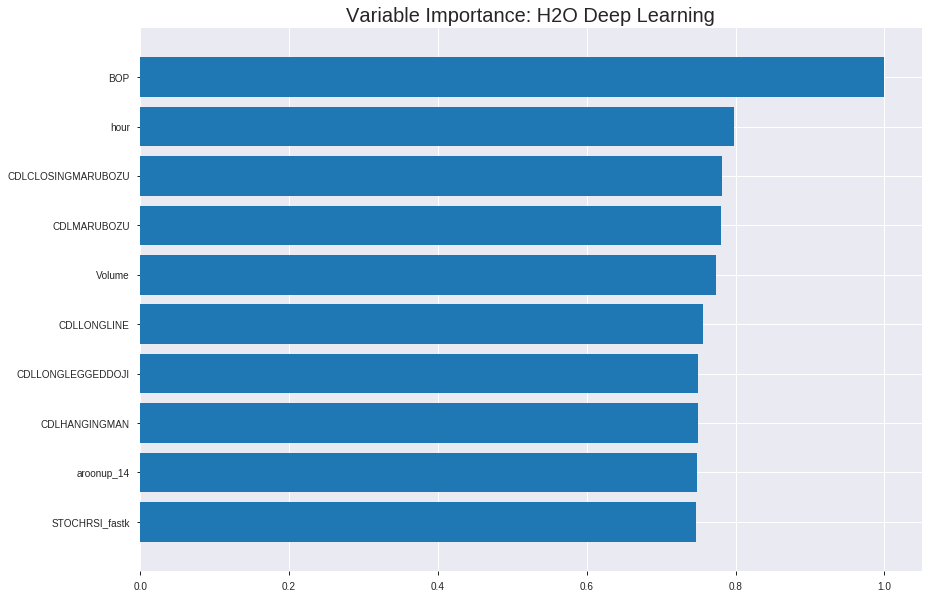

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_044044_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19647642131271603
RMSE: 0.4432566088765243
LogLoss: 0.577102801672729
Mean Per-Class Error: 0.27560494094454535
AUC: 0.7765592862067198
pr_auc: 0.772163860677699
Gini: 0.5531185724134395
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44054902182634753: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      382  216  0.3612   (216.0/598.0)
1      117  470  0.1993   (117.0/587.0)
Total  499  686  0.281    (333.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440549     0.738413  237
max f2                       0.302731     0.837563  325
max f0point5                 0.477814     0.716706  212
max accuracy                 0.4623       0.724051  223
max precision                0.922867     1         0
max recall                   0.167231     1         388
max specificity              0.922867     1         0
max absolute_mcc             0.4623       0.449876  223
max min_per_class_accuracy   0.477814     0.719064  212
max mean_per_class_accuracy  0.4623       0.724395  223

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.900149           2.01874   2.01874            1                0.912026  1                           0.912026            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.882733           2.01874   2.01874            1                0.892089  1                           0.902058            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.857684           2.01874   2.01874            1                0.868537  1                           0.890884            0.0204429       0.0613288                  101.874   101.874
    4        0.0405063                   0.833098           2.01874   2.01874            1                0.846829  1                           0.87987             0.0204429       0.0817717                  101.874   101.874
    5        0.0506329                   0.814372           1.85051   1.98509            0.916667         0.822079  0.983333                    0.868312            0.0187394       0.100511                   85.0511   98.5094
    6        0.100422                    0.739311           1.57393   1.78124            0.779661         0.771136  0.882353                    0.820132            0.0783646       0.178876                   57.3932   78.1241
    7        0.150211                    0.698866           1.64236   1.73521            0.813559         0.718165  0.859551                    0.786334            0.0817717       0.260647                   64.2364   73.5209
    8        0.2                         0.656158           1.53972   1.68654            0.762712         0.678183  0.835443                    0.75941             0.076661        0.337308                   53.9716   68.6542
    9        0.300422                    0.590357           1.32321   1.56509            0.655462         0.623689  0.775281                    0.714043            0.132879        0.470187                   32.3207   56.509
    10       0.4                         0.532917           1.21467   1.47785            0.601695         0.56218   0.732068                    0.676237            0.120954        0.591141                   21.4665   47.7853
    11       0.500422                    0.476866           1.30624   1.44342            0.647059         0.504547  0.715008                    0.641784            0.131175        0.722317                   30.6243   44.3416
    12       0.6                         0.42905            0.83829   1.34299            0.415254         0.454101  0.66526                     0.610635            0.0834753       0.805792                   -16.171   34.2987
    13       0.699578                    0.382444           0.701426  1.25167            0.347458         0.40553   0.620024                    0.58144             0.0698467       0.875639                   -29.8574  25.1667
    14       0.8                         0.33263            0.576783  1.16695            0.285714         0.357402  0.578059                    0.553317            0.0579216       0.93356                    -42.3217  16.6951
    15       0.899578                    0.26291            0.376375  1.07944            0.186441         0.299603  0.534709                    0.525233            0.0374787       0.971039                   -62.3625  7.94385
    16       1                           0.121515           0.288391  1                  0.142857         0.209267  0.495359                    0.493503          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.219400140307622
RMSE: 0.4684016869179935
LogLoss: 0.6299747864994006
Mean Per-Class Error: 0.3241933226009659
AUC: 0.7062014418702317
pr_auc: 0.6476235765382399
Gini: 0.4124028837404634
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39638311160783957: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      74   108  0.5934   (108.0/182.0)
1      21   136  0.1338   (21.0/157.0)
Total  95   244  0.3805   (129.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396383     0.678304  243
max f2                       0.25045      0.823654  318
max f0point5                 0.490946     0.644242  179
max accuracy                 0.490946     0.672566  179
max precision                0.865609     0.833333  5
max recall                   0.204897     1         327
max specificity              0.914391     0.994505  0
max absolute_mcc             0.490946     0.351331  179
max min_per_class_accuracy   0.513071     0.656051  162
max mean_per_class_accuracy  0.490946     0.675807  179

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 51.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.8785             1.61943   1.61943            0.75             0.897173  0.75                        0.897173            0.0191083       0.0191083                  61.9427   61.9427
    2        0.020649                    0.854219           1.43949   1.54231            0.666667         0.867294  0.714286                    0.884367            0.0127389       0.0318471                  43.949    54.2311
    3        0.0324484                   0.836043           1.61943   1.57035            0.75             0.846206  0.727273                    0.87049             0.0191083       0.0509554                  61.9427   57.0353
    4        0.0412979                   0.824326           1.43949   1.54231            0.666667         0.829317  0.714286                    0.861668            0.0127389       0.0636943                  43.949    54.2311
    5        0.0501475                   0.806368           1.43949   1.52417            0.666667         0.816913  0.705882                    0.85377             0.0127389       0.0764331                  43.949    52.4166
    6        0.100295                    0.74212            1.77819   1.65118            0.823529         0.772482  0.764706                    0.813126            0.089172        0.165605                   77.8194   65.118
    7        0.150442                    0.6939             1.52417   1.60884            0.705882         0.716695  0.745098                    0.780982            0.0764331       0.242038                   52.4166   60.8842
    8        0.20059                     0.655301           1.77819   1.65118            0.823529         0.677017  0.764706                    0.754991            0.089172        0.33121                    77.8194   65.118
    9        0.300885                    0.60265            1.01611   1.43949            0.470588         0.631193  0.666667                    0.713725            0.101911        0.433121                   1.61109   43.949
    10       0.40118                     0.562609           1.27014   1.39715            0.588235         0.584587  0.647059                    0.68144             0.127389        0.56051                    27.0139   39.7152
    11       0.501475                    0.503289           1.07962   1.33365            0.5              0.527964  0.617647                    0.650745            0.10828         0.66879                    7.96178   33.3646
    12       0.59882                     0.45486            0.785177  1.24449            0.363636         0.481923  0.576355                    0.623301            0.0764331       0.745223                   -21.4823  24.4486
    13       0.699115                    0.416453           1.01611   1.21172            0.470588         0.43698   0.561181                    0.596571            0.101911        0.847134                   1.61109   21.1723
    14       0.79941                     0.351729           0.508055  1.12344            0.235294         0.383289  0.520295                    0.569813            0.0509554       0.898089                   -49.1945  12.344
    15       0.899705                    0.29272            0.571562  1.06192            0.264706         0.323265  0.491803                    0.542329            0.0573248       0.955414                   -42.8438  6.19192
    16       1                           0.160734           0.444549  1                  0.205882         0.225845  0.463127                    0.510587            0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:45:27  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:45:30  1 min  6.267 sec  754 obs/sec       1.91055   1             2264       0.443257         0.577103            0.214027       0.776559        0.772164           2.01874          0.281013                         0.468402           0.629975              0.1176           0.706201          0.647624             1.61943            0.380531
    2019-07-25 04:45:40  1 min 16.763 sec  894 obs/sec       9.55359   5             11321      0.440991         0.568093            0.222041       0.782683        0.791147           2.01874          0.324051                         0.477545           0.645308              0.0828162        0.672989          0.609699             1.61943            0.418879
    2019-07-25 04:45:50  1 min 26.958 sec  1025 obs/sec      19.0532   10            22578      0.419503         0.5196              0.29601        0.820129        0.808385           2.01874          0.296203                         0.488761           0.710141              0.0392258        0.677084          0.59908              1.07962            0.410029
    2019-07-25 04:46:00  1 min 36.755 sec  1102 obs/sec      28.5831   15            33871      0.410805         0.497601            0.324898       0.838428        0.808952           2.01874          0.279325                         0.485062           0.699237              0.0537144        0.673094          0.596291             1.07962            0.418879
    2019-07-25 04:46:11  1 min 47.807 sec  1157 obs/sec      40.0042   21            47405      0.397893         0.466253            0.36667        0.852833        0.831664           2.01874          0.259072                         0.495781           0.753837              0.0114301        0.672849          0.595964             1.07962            0.421829
    2019-07-25 04:46:21  1 min 57.155 sec  1186 obs/sec      49.5063   26            58665      0.384304         0.435692            0.409192       0.873079        0.833137           2.01874          0.257384                         0.495942           0.770021              0.0107882        0.663033          0.579414             1.07962            0.40708
    2019-07-25 04:46:22  1 min 58.029 sec  1186 obs/sec      49.5063   26            58665      0.443257         0.577103            0.214027       0.776559        0.772164           2.01874          0.281013                         0.468402           0.629975              0.1176           0.706201          0.647624             1.61943            0.380531

Variable Importances: 


variable              relative_importance    scaled_importance    percentage
--------------------  ---------------------  -------------------  --------------------
BOP                   1.0                    1.0                  0.027655108611984346
hour                  0.7981808185577393     0.7981808185577393   0.02207377722921685
CDLCLOSINGMARUBOZU    0.7824501991271973     0.7824501991271973   0.021638745240331422
CDLMARUBOZU           0.7800869345664978     0.7800869345664978   0.021573388902226424
Volume                0.7739691734313965     0.7739691734313965   0.02140420155357302
---                   ---                    ---                  ---
WILLR_8               0.6804915070533752     0.6804915070533752   0.018819066537094004
MOM_30                0.6803803443908691     0.6803803443908691   0.0188159923215888
LINEARREG_SLOPE_12    0.6753755807876587     0.6753755807876587   0.01867758504056471
HT_PHASOR_quadrature  0.6685757040977478     0.6685757040977478   0.018489533712157124
CDLBELTHOLD           0.6430587768554688     0.6430587768554688   0.017783860317827794


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6588235294117647)

('F1', 0.6334841628959276)

('auc', 0.6526315789473685)

('logloss', 0.6540325030318999)

('mean_per_class_error', 0.3543859649122807)

('rmse', 0.48019745332530833)

('mse', 0.23058959418011168)

deeplearning prediction progress: |███████████████████████████████████████| 100%


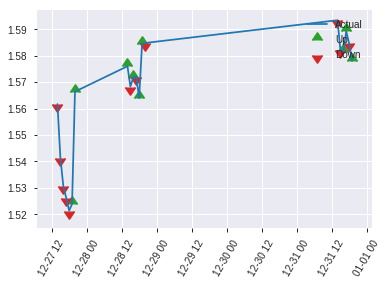


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23058959418011168
RMSE: 0.48019745332530833
LogLoss: 0.6540325030318999
Mean Per-Class Error: 0.3543859649122807
AUC: 0.6526315789473685
pr_auc: 0.5824074170354117
Gini: 0.3052631578947369
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24862140378710448: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      19   76   0.8      (76.0/95.0)
1      5    70   0.0667   (5.0/75.0)
Total  24   146  0.4765   (81.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.248621     0.633484  145
max f2                       0.168953     0.80819   163
max f0point5                 0.458961     0.611621  62
max accuracy                 0.458961     0.658824  62
max precision                0.904901     1         0
max recall                   0.168953     1         163
max specificity              0.904901     1         0
max absolute_mcc             0.458961     0.299408  62
max min_per_class_accuracy   0.424814     0.613333  80
max mean_per_class_accuracy  0.458961     0.645614  62

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 43.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.82908            2.26667   2.26667            1                0.867471  1                           0.867471            0.0266667       0.0266667                  126.667   126.667
    2        0.0235294                   0.799104           1.13333   1.7                0.5              0.818944  0.75                        0.843207            0.0133333       0.04                       13.3333   70
    3        0.0352941                   0.78095            0         1.13333            0                0.781939  0.5                         0.822784            0               0.04                       -100      13.3333
    4        0.0411765                   0.764787           0         0.971429           0                0.776182  0.428571                    0.816127            0               0.04                       -100      -2.85714
    5        0.0529412                   0.75031            2.26667   1.25926            1                0.757608  0.555556                    0.803123            0.0266667       0.0666667                  126.667   25.9259
    6        0.1                         0.684389           1.98333   1.6                0.875            0.713979  0.705882                    0.761173            0.0933333       0.16                       98.3333   60
    7        0.152941                    0.627216           1.51111   1.56923            0.666667         0.656823  0.692308                    0.725052            0.08            0.24                       51.1111   56.9231
    8        0.2                         0.587548           1.41667   1.53333            0.625            0.601501  0.676471                    0.695981            0.0666667       0.306667                   41.6667   53.3333
    9        0.3                         0.505407           1.2       1.42222            0.529412         0.548239  0.627451                    0.646734            0.12            0.426667                   20        42.2222
    10       0.4                         0.443381           1.2       1.36667            0.529412         0.47162   0.602941                    0.602955            0.12            0.546667                   20        36.6667
    11       0.5                         0.413822           0.8       1.25333            0.352941         0.429205  0.552941                    0.568205            0.08            0.626667                   -20       25.3333
    12       0.6                         0.373113           0.533333  1.13333            0.235294         0.399669  0.5                         0.540116            0.0533333       0.68                       -46.6667  13.3333
    13       0.7                         0.331052           0.933333  1.10476            0.411765         0.350013  0.487395                    0.512958            0.0933333       0.773333                   -6.66667  10.4762
    14       0.8                         0.274914           0.933333  1.08333            0.411765         0.298753  0.477941                    0.486183            0.0933333       0.866667                   -6.66667  8.33333
    15       0.9                         0.202305           0.8       1.05185            0.352941         0.241491  0.464052                    0.458995            0.08            0.946667                   -20       5.18519
    16       1                           0.118321           0.533333  1                  0.235294         0.172479  0.441176                    0.430343            0.0533

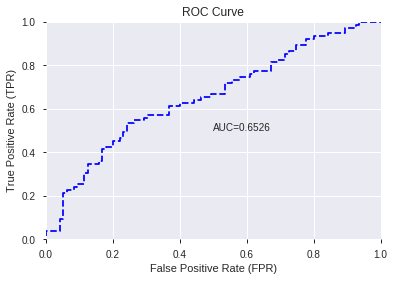

This function is available for GLM models only


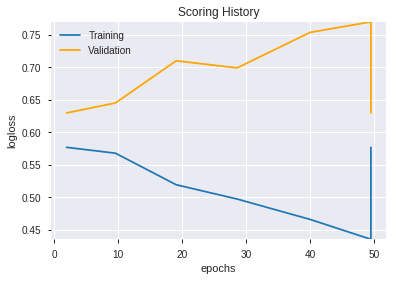

--2019-07-25 04:47:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_044044_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_044044_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'CDLMARUBOZU',
 'Volume',
 'CDLLONGLINE',
 'CDLLONGLEGGEDDOJI',
 'CDLHANGINGMAN',
 'aroonup_14',
 'STOCHRSI_fastk',
 'CDLDRAGONFLYDOJI',
 'WILLR_14',
 'aroonup_30',
 'CDLSHORTLINE',
 'BETA_8',
 'SAREXT',
 'days_in_month',
 'HT_PHASOR_inphase',
 'HT_DCPERIOD',
 'CEIL',
 'STOCHF_fastk',
 'CDLTAKURI',
 'ROCR_30',
 'CORREL_14',
 'CDLDOJI',
 'ROC_30',
 'ROCP_30',
 'TRANGE',
 'DX_8',
 'CDLRICKSHAWMAN',
 'CORREL_8',
 'aroondown_30',
 'LINEARREG_ANGLE_12',
 'CORREL_12',
 'WILLR_30',
 'MFI_24',
 'DIV',
 'STOCHRSI_fastd',
 'CDLSHOOTINGSTAR',
 'CDLENGULFING',
 'ULTOSC',
 'PLUS_DI_30',
 'ROCR100_30',
 'aroonup_12',
 'SUB',
 'WILLR_8',
 'MOM_30',
 'LINEARREG_SLOPE_12',
 'HT_PHASOR_quadrature',
 'CDLBELTHOLD']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_044724_model_1  0.648421  0.66633              0.457895  0.484357  0.234602

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.281843           1.000000    0.101080
1     CDLCLOSINGMARUBOZU             0.155335           0.551140    0.055709
2                   hour             0.127474           0.452285    0.045717
3            CDLLONGLINE             0.122575           0.434903    0.043960
4        CDLSHOOTINGSTAR             0.102042           0.362054    0.036596
5                WILLR_8             0.090006           0.319346    0.032279
6                 ULTOSC             0.086617           0.307323    0.031064
7           STOCHF_fastk             0.085251           0.302477    0.030574
8           CDLENGULFING             0.078070           0.276998    0.027999
9          CDLHANGINGMAN             0.075066           0.266338    0.026921
10              WILLR_14             0.075064           0.266332    0.026921
11            PLUS_DI_30             0.071111           0.252308    0.025503
12                SAREXT             0.069457           0.246437    0.024910
13           CDLMARUBOZU             0.067130           0.238184    0.024075
14                Volume             0.066598           0.236293    0.023884
15      CDLDRAGONFLYDOJI             0.065883           0.233758    0.023628
16             CDLTAKURI             0.061002           0.216439    0.021878
17        STOCHRSI_fastk             0.058917           0.209043    0.021130
18                   SUB             0.058081           0.206076    0.020830
19           HT_DCPERIOD             0.057749           0.204897    0.020711
20            aroonup_12             0.055551           0.197099    0.019923
21              WILLR_30             0.050414           0.178873    0.018080
22    LINEARREG_ANGLE_12             0.049430           0.175380    0.017727
23    LINEARREG_SLOPE_12             0.049394           0.175253    0.017714
24                   DIV             0.046970           0.166651    0.016845
25            aroonup_14             0.043247           0.153442    0.015510
26                  CEIL             0.042913           0.152257    0.015390
27             CORREL_14             0.041814           0.148361    0.014996
28                  DX_8             0.039605           0.140520    0.014204
29           CDLBELTHOLD             0.036866           0.130802    0.013221
30     HT_PHASOR_inphase             0.036303           0.128807    0.013020
31        STOCHRSI_fastd             0.034829           0.123576    0.012491
32                ROC_30             0.033411           0.118546    0.011983
33               ROCP_30             0.033301           0.118156    0.011943
34               ROCR_30             0.033184           0.117738    0.011901
35            ROCR100_30             0.033114           0.117493    0.011876
36  HT_PHASOR_quadrature             0.032967           0.116969    0.011823
37          aroondown_30             0.032132           0.114008    0.011524
38                BETA_8             0.029398           0.104307    0.010543
39                MOM_30             0.029178           0.103524    0.010464
40            aroonup_30             0.025785           0.091486    0.009247
41              CORREL_8             0.025450           0.090299    0.009127
42                MFI_24             0.020337           0.072156    0.007293
43        CDLRICKSHAWMAN             0.016442           0.058339    0.005897
44     CDLLONGLEGGEDDOJI             0.013392           0.047515    0.004803
45               CDLDOJI             0.013388           0.047500    0.004801
46         days_in_month             0.010193           0.036164    0.003655
47          CDLSHORTLINE             0.008721           0.030943    0.003128
48             CORREL_12             0.008494           0.030136    0.003046
49                TRANGE             0.006841           0.024272    0.002453

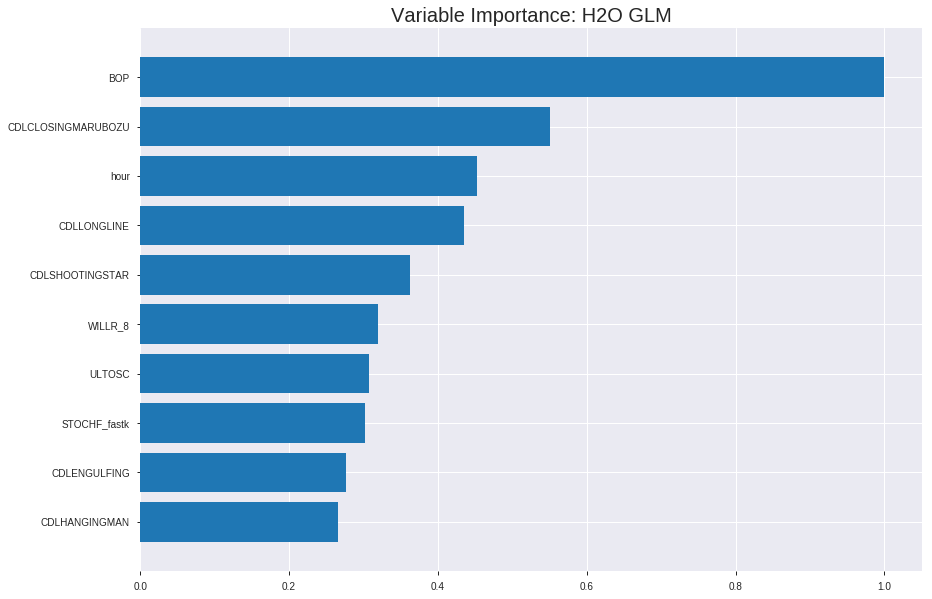

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_044724_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19642659093924153
RMSE: 0.44320039591503246
LogLoss: 0.576731177853761
Null degrees of freedom: 1184
Residual degrees of freedom: 1134
Null deviance: 1642.6567067559345
Residual deviance: 1366.8528915134136
AIC: 1468.8528915134136
AUC: 0.7746164101804425
pr_auc: 0.7737301092636797
Gini: 0.5492328203608849
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41905373882137675: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      321  277  0.4632   (277.0/598.0)
1      92   495  0.1567   (92.0/587.0)
Total  413  772  0.3114   (369.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419054     0.728477  245
max f2                       0.280373     0.837518  326
max f0point5                 0.514169     0.717292  190
max accuracy                 0.514169     0.7173    190
max precision                0.92314      1         0
max recall                   0.107749     1         387
max specificity              0.92314      1         0
max absolute_mcc             0.514169     0.434638  190
max min_per_class_accuracy   0.50182      0.713799  196
max mean_per_class_accuracy  0.514169     0.717111  190

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.874696           2.01874   2.01874            1                0.894079  1                           0.894079            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.863732           2.01874   2.01874            1                0.869017  1                           0.881548            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.840669           2.01874   2.01874            1                0.853555  1                           0.872217            0.0204429       0.0613288                  101.874   101.874
    4        0.0405063                   0.822365           2.01874   2.01874            1                0.831995  1                           0.862161            0.0204429       0.0817717                  101.874   101.874
    5        0.0506329                   0.796478           1.85051   1.98509            0.916667         0.81227   0.983333                    0.852183            0.0187394       0.100511                   85.0511   98.5094
    6        0.100422                    0.738403           1.64236   1.81517            0.813559         0.760817  0.89916                     0.806884            0.0817717       0.182283                   64.2364   81.5169
    7        0.150211                    0.696607           1.64236   1.75789            0.813559         0.717145  0.870787                    0.777139            0.0817717       0.264055                   64.2364   75.7891
    8        0.2                         0.658803           1.36864   1.66099            0.677966         0.677115  0.822785                    0.752239            0.0681431       0.332198                   36.8637   66.0988
    9        0.300422                    0.596507           1.34017   1.55375            0.663866         0.628546  0.769663                    0.710892            0.134583        0.46678                    34.0172   55.3749
    10       0.4                         0.548966           1.2831    1.48637            0.635593         0.572218  0.736287                    0.67637             0.127768        0.594549                   28.3097   48.6371
    11       0.500422                    0.495596           1.20446   1.4298             0.596639         0.524878  0.708263                    0.645969            0.120954        0.715503                   20.4458   42.9799
    12       0.6                         0.442977           0.855398  1.33447            0.423729         0.469138  0.661041                    0.616622            0.0851789       0.800681                   -14.4602  33.4469
    13       0.699578                    0.390737           0.718534  1.2468             0.355932         0.418199  0.617612                    0.588378            0.0715503       0.872232                   -28.1466  24.6797
    14       0.8                         0.3318             0.644639  1.17121            0.319328         0.361332  0.580169                    0.559878            0.0647359       0.936968                   -35.5361  17.121
    15       0.899578                    0.253064           0.325051  1.07754            0.161017         0.297366  0.533771                    0.530819            0.032368        0.969336                   -67.4949  7.75447
    16       1                           0.0620352          0.305356  1                  0.151261         0.177704  0.495359                    0.495359          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21489161488416628
RMSE: 0.46356403536530555
LogLoss: 0.6186626369033239
Null degrees of freedom: 338
Residual degrees of freedom: 288
Null deviance: 469.5188524558861
Residual deviance: 419.4532678204537
AIC: 521.4532678204537
AUC: 0.7134107930286274
pr_auc: 0.6517864493321819
Gini: 0.42682158605725484
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3987014889467266: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      80   102  0.5604   (102.0/182.0)
1      20   137  0.1274   (20.0/157.0)
Total  100  239  0.3599   (122.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398701     0.691919  238
max f2                       0.263201     0.830654  304
max f0point5                 0.551754     0.635401  125
max accuracy                 0.551754     0.660767  125
max precision                0.875432     1         0
max recall                   0.105102     1         337
max specificity              0.875432     1         0
max absolute_mcc             0.398701     0.341335  238
max min_per_class_accuracy   0.500113     0.631868  166
max mean_per_class_accuracy  0.445843     0.661388  208

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 48.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.843593           1.61943   1.61943            0.75             0.858842  0.75                        0.858842            0.0191083       0.0191083                  61.9427   61.9427
    2        0.020649                    0.820684           1.43949   1.54231            0.666667         0.834825  0.714286                    0.848549            0.0127389       0.0318471                  43.949    54.2311
    3        0.0324484                   0.80766            1.61943   1.57035            0.75             0.815105  0.727273                    0.836388            0.0191083       0.0509554                  61.9427   57.0353
    4        0.0412979                   0.793663           2.15924   1.69654            1                0.804224  0.785714                    0.829495            0.0191083       0.0700637                  115.924   69.6542
    5        0.0501475                   0.778624           0.719745  1.52417            0.333333         0.782385  0.705882                    0.821182            0.00636943      0.0764331                  -28.0255  52.4166
    6        0.100295                    0.728805           1.65118   1.58767            0.764706         0.757218  0.735294                    0.7892              0.0828025       0.159236                   65.118    58.7673
    7        0.150442                    0.664942           1.77819   1.65118            0.823529         0.693119  0.764706                    0.757173            0.089172        0.248408                   77.8194   65.118
    8        0.20059                     0.625188           1.39715   1.58767            0.647059         0.644719  0.735294                    0.72906             0.0700637       0.318471                   39.7152   58.7673
    9        0.300885                    0.576886           1.27014   1.48183            0.588235         0.603485  0.686275                    0.687202            0.127389        0.44586                    27.0139   48.1828
    10       0.40118                     0.542788           1.14312   1.39715            0.529412         0.560326  0.647059                    0.655483            0.11465         0.56051                    14.3125   39.7152
    11       0.501475                    0.490537           0.889097  1.29554            0.411765         0.515772  0.6                         0.62754             0.089172        0.649682                   -11.0903  29.5541
    12       0.59882                     0.448562           1.11233   1.26576            0.515152         0.473058  0.586207                    0.602427            0.10828         0.757962                   11.2334   26.5759
    13       0.699115                    0.400588           1.01611   1.22994            0.470588         0.42367   0.56962                     0.576783            0.101911        0.859873                   1.61109   22.9944
    14       0.79941                     0.337303           0.635069  1.15531            0.294118         0.371219  0.535055                    0.550993            0.0636943       0.923567                   -36.4931  15.5311
    15       0.899705                    0.263087           0.635069  1.09732            0.294118         0.300096  0.508197                    0.523024            0.0636943       0.987261                   -36.4931  9.73165
    16       1                           0.086654           0.127014  1                  0.0588235        0.186809  0.463127                    0.489303          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:47:24  0.000 sec   2            20        50            1.36503           1.36865
    2019-07-25 04:47:24  0.015 sec   4            13        51            1.35431           1.36046
    2019-07-25 04:47:24  0.031 sec   6            7.9       51            1.33954           1.34928
    2019-07-25 04:47:24  0.045 sec   8            4.9       51            1.32039           1.33491
    2019-07-25 04:47:24  0.059 sec   10           3         51            1.29722           1.31772
    2019-07-25 04:47:24  0.069 sec   12           1.9       51            1.27118           1.29877
    2019-07-25 04:47:24  0.077 sec   14           1.2       51            1.24406           1.27978
    2019-07-25 04:47:24  0.087 sec   16           0.73      51            1.21762           1.26268
    2019-07-25 04:47:24  0.096 sec   18           0.45      51            1.19327           1.24922
    2019-07-25 04:47:24  0.108 sec   20           0.28      51            1.17182           1.24057
    2019-07-25 04:47:24  0.116 sec   22           0.17      51            1.15346           1.23733
    2019-07-25 04:47:24  0.127 sec   24           0.11      51            1.13807           1.23981
    2019-07-25 04:47:24  0.141 sec   26           0.067     51            1.12538           1.24823
    2019-07-25 04:47:24  0.150 sec   28           0.042     51            1.11518           1.26275
    2019-07-25 04:47:24  0.158 sec   30           0.026     51            1.10731           1.28291
    2019-07-25 04:47:24  0.169 sec   32           0.016     51            1.10162           1.30707

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6705882352941176)

('F1', 0.6329113924050632)

('auc', 0.648421052631579)

('logloss', 0.6663295956844648)

('mean_per_class_error', 0.34807017543859653)

('rmse', 0.4843573453078704)

('mse', 0.23460203795368761)

glm prediction progress: |████████████████████████████████████████████████| 100%


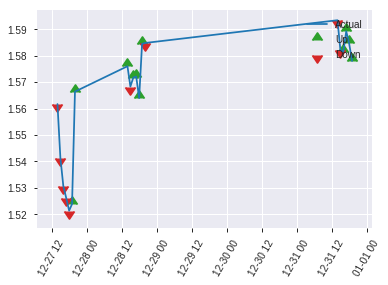


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23460203795368761
RMSE: 0.4843573453078704
LogLoss: 0.6663295956844648
Null degrees of freedom: 169
Residual degrees of freedom: 119
Null deviance: 235.31337198870415
Residual deviance: 226.55206253271805
AIC: 328.5520625327181
AUC: 0.648421052631579
pr_auc: 0.576444192449217
Gini: 0.296842105263158
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12308582867352721: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      8    87   0.9158   (87.0/95.0)
1      0    75   0        (0.0/75.0)
Total  8    162  0.5118   (87.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.123086     0.632911  161
max f2                       0.123086     0.811688  161
max f0point5                 0.49707      0.627119  54
max accuracy                 0.49707      0.670588  54
max precision                0.626224     0.724138  28
max recall                   0.123086     1         161
max specificity              0.857278     0.989474  0
max absolute_mcc             0.49707      0.322504  54
max min_per_class_accuracy   0.413835     0.589474  83
max mean_per_class_accuracy  0.49707      0.65193   54

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 41.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.843867           1.13333   1.13333            0.5              0.852736  0.5                         0.852736            0.0133333       0.0133333                  13.3333   13.3333
    2        0.0235294                   0.82853            1.13333   1.13333            0.5              0.837182  0.5                         0.844959            0.0133333       0.0266667                  13.3333   13.3333
    3        0.0352941                   0.805964           2.26667   1.51111            1                0.814068  0.666667                    0.834662            0.0266667       0.0533333                  126.667   51.1111
    4        0.0411765                   0.799554           2.26667   1.61905            1                0.805646  0.714286                    0.830517            0.0133333       0.0666667                  126.667   61.9048
    5        0.0529412                   0.77603            1.13333   1.51111            0.5              0.792172  0.666667                    0.821996            0.0133333       0.08                       13.3333   51.1111
    6        0.1                         0.688022           1.41667   1.46667            0.625            0.724472  0.647059                    0.776102            0.0666667       0.146667                   41.6667   46.6667
    7        0.152941                    0.636945           1.76296   1.56923            0.777778         0.655571  0.692308                    0.73438             0.0933333       0.24                       76.2963   56.9231
    8        0.2                         0.609793           1.41667   1.53333            0.625            0.622638  0.676471                    0.708088            0.0666667       0.306667                   41.6667   53.3333
    9        0.3                         0.505403           1.46667   1.51111            0.647059         0.547472  0.666667                    0.654549            0.146667        0.453333                   46.6667   51.1111
    10       0.4                         0.455378           0.933333  1.36667            0.411765         0.480099  0.602941                    0.610937            0.0933333       0.546667                   -6.66667  36.6667
    11       0.5                         0.410148           0.533333  1.2                0.235294         0.430095  0.529412                    0.574768            0.0533333       0.6                        -46.6667  20
    12       0.6                         0.355883           0.933333  1.15556            0.411765         0.380251  0.509804                    0.542349            0.0933333       0.693333                   -6.66667  15.5556
    13       0.7                         0.309525           0.933333  1.12381            0.411765         0.330045  0.495798                    0.51202             0.0933333       0.786667                   -6.66667  12.381
    14       0.8                         0.229506           0.8       1.08333            0.352941         0.283141  0.477941                    0.48341             0.08            0.866667                   -20       8.33333
    15       0.9                         0.155256           0.8       1.05185            0.352941         0.195265  0.464052                    0.451394            0.08            0.946667                   -20       5.18519
    16       1                           0.0505072          0.533333  1                  0.235294         0.114995  0.441176                    0.417754            0.0

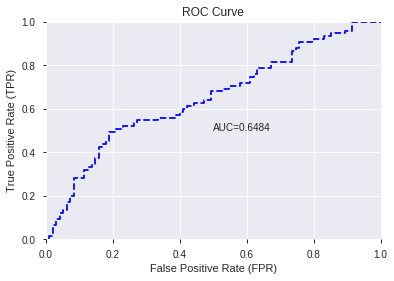

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


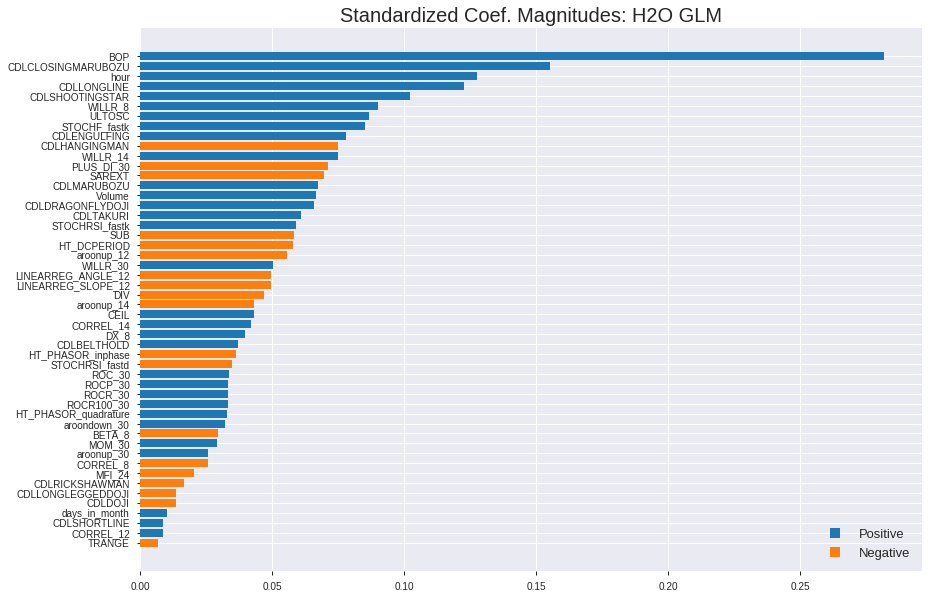

'log_likelihood'
--2019-07-25 04:47:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.111.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.111.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_044724_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_044724_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'CDLLONGLINE',
 'CDLSHOOTINGSTAR',
 'WILLR_8',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'WILLR_14',
 'PLUS_DI_30',
 'SAREXT',
 'CDLMARUBOZU',
 'Volume',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCHRSI_fastk',
 'SUB',
 'HT_DCPERIOD',
 'aroonup_12',
 'WILLR_30',
 'LINEARREG_ANGLE_12',
 'LINEARREG_SLOPE_12',
 'DIV',
 'aroonup_14',
 'CEIL',
 'CORREL_14',
 'DX_8',
 'CDLBELTHOLD',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastd',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'HT_PHASOR_quadrature',
 'aroondown_30',
 'BETA_8',
 'MOM_30',
 'aroonup_30',
 'CORREL_8',
 'MFI_24',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'days_in_month',
 'CDLSHORTLINE',
 'CORREL_12',
 'TRANGE']

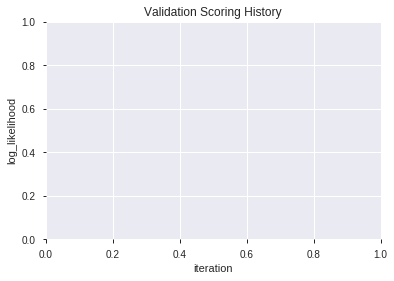

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_044739_model_6  0.701333  0.643862              0.389825  0.472640  0.223389
1  XGBoost_grid_1_AutoML_20190725_044739_model_1  0.693333  0.664417              0.372632  0.479105  0.229541
2  XGBoost_grid_1_AutoML_20190725_044739_model_4  0.690807  0.641562              0.341754  0.473009  0.223737
3               XGBoost_3_AutoML_20190725_044739  0.688281  0.663535              0.322807  0.479507  0.229927
4               XGBoost_2_AutoML_20190725_044739  0.687719  0.654178              0.343158  0.478228  0.228702
5  XGBoost_grid_1_AutoML_20190725_044739_model_2  0.675509  0.658135              0.406667  0.480411  0.230795
6               XGBoost_1_AutoML_20190725_044739  0.672702  0.674906              0.408070  0.486371  0.236557
7  XGBoost_grid_1_AutoML_20190725_044739_model_3  0.672281  0.677541              0.333333  0.485358  0.235572
8  XGBoost_grid_1_AutoML_20190725_044739_model_7  0.670175  0.690926              0.369474  0.488968  0.239090
9  XGBoost_grid_1_AutoML_20190725_044739_model_5  0.656982  0.709440              0.357544  0.497563  0.247569

variable  relative_importance  scaled_importance  percentage
0                    BOP          1466.243652           1.000000    0.198836
1           STOCHF_fastk           525.322266           0.358278    0.071238
2                WILLR_8           339.767334           0.231726    0.046076
3      HT_PHASOR_inphase           293.414032           0.200113    0.039790
4   HT_PHASOR_quadrature           282.640411           0.192765    0.038329
5                 SAREXT           260.802368           0.177871    0.035367
6                   DX_8           232.442230           0.158529    0.031521
7                   hour           231.671997           0.158004    0.031417
8                    DIV           221.320557           0.150944    0.030013
9                 BETA_8           215.168365           0.146748    0.029179
10           HT_DCPERIOD           200.055420           0.136441    0.027129
11            PLUS_DI_30           187.626495           0.127964    0.025444
12                ULTOSC           185.148773           0.126274    0.025108
13                MOM_30           183.836029           0.125379    0.024930
14                Volume           180.475128           0.123087    0.024474
15              WILLR_14           175.601074           0.119763    0.023813
16        STOCHRSI_fastd           175.248123           0.119522    0.023765
17                TRANGE           171.135818           0.116717    0.023208
18             CORREL_12           167.874863           0.114493    0.022765
19        STOCHRSI_fastk           160.505569           0.109467    0.021766
20              CORREL_8           158.266724           0.107940    0.021462
21                MFI_24           139.992416           0.095477    0.018984
22                ROC_30           139.496231           0.095139    0.018917
23            aroonup_12           138.348068           0.094355    0.018761
24             CORREL_14           129.826996           0.088544    0.017606
25              WILLR_30           128.857437           0.087883    0.017474
26            aroonup_30            93.743690           0.063935    0.012712
27    LINEARREG_ANGLE_12            77.854637           0.053098    0.010558
28                   SUB            77.166893           0.052629    0.010465
29          aroondown_30            66.671799           0.045471    0.009041
30            aroonup_14            54.060875           0.036870    0.007331
31    LINEARREG_SLOPE_12            52.956345           0.036117    0.007181
32    CDLCLOSINGMARUBOZU            52.763813           0.035986    0.007155
33       CDLSHOOTINGSTAR            46.376274           0.031629    0.006289
34          CDLSHORTLINE            34.772640           0.023715    0.004715
35      CDLDRAGONFLYDOJI            32.268360           0.022008    0.004376
36               ROCP_30            26.572750           0.018123    0.003604
37           CDLLONGLINE            17.037521           0.011620    0.002310
38               ROCR_30            13.932322           0.009502    0.001889
39             CDLTAKURI            12.561207           0.008567    0.001703
40                  CEIL            10.938547           0.007460    0.001483
41         days_in_month             5.119262           0.003491    0.000694
42           CDLBELTHOLD             4.767580           0.003252    0.000647
43          CDLENGULFING             2.620799           0.001787    0.000355
44        CDLRICKSHAWMAN             0.864751           0.000590    0.000117

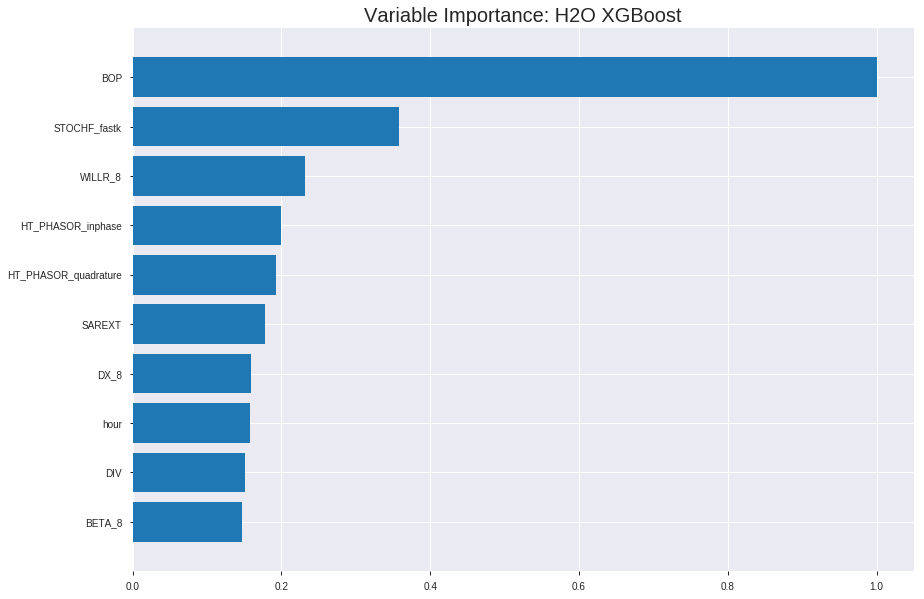

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_044739_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12908813691058135
RMSE: 0.35928837569643324
LogLoss: 0.42280374106470986
Mean Per-Class Error: 0.13955803843589942
AUC: 0.9396412231572591
pr_auc: 0.9410112022459094
Gini: 0.8792824463145181
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46687036752700806: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      495  103  0.1722   (103.0/598.0)
1      66   521  0.1124   (66.0/587.0)
Total  561  624  0.1426   (169.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46687      0.860446  212
max f2                       0.332155     0.898841  284
max f0point5                 0.588156     0.893553  151
max accuracy                 0.509336     0.860759  188
max precision                0.948321     1         0
max recall                   0.237483     1         329
max specificity              0.948321     1         0
max absolute_mcc             0.509336     0.723391  188
max min_per_class_accuracy   0.484956     0.856187  201
max mean_per_class_accuracy  0.506782     0.860442  189

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.26 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.931407           2.01874    2.01874            1                0.940749  1                           0.940749            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.919597           2.01874    2.01874            1                0.924846  1                           0.932798            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.907353           2.01874    2.01874            1                0.91499   1                           0.926862            0.0204429       0.0613288                  101.874   101.874
    4        0.0405063                   0.898257           2.01874    2.01874            1                0.902458  1                           0.920761            0.0204429       0.0817717                  101.874   101.874
    5        0.0506329                   0.889675           2.01874    2.01874            1                0.893895  1                           0.915388            0.0204429       0.102215                   101.874   101.874
    6        0.100422                    0.82801            2.01874    2.01874            1                0.858234  1                           0.887051            0.100511        0.202726                   101.874   101.874
    7        0.150211                    0.768528           2.01874    2.01874            1                0.796509  1                           0.85704             0.100511        0.303237                   101.874   101.874
    8        0.2                         0.712626           1.98452    2.01022            0.983051         0.738512  0.995781                    0.827533            0.0988075       0.402044                   98.4523   101.022
    9        0.300422                    0.633778           1.86606    1.96203            0.92437          0.672789  0.97191                     0.775807            0.187394        0.589438                   86.6062   96.2033
    10       0.4                         0.566003           1.64236    1.88245            0.813559         0.598774  0.932489                    0.731735            0.163543        0.752981                   64.2364   88.2453
    11       0.500422                    0.484029           1.08571    1.72257            0.537815         0.517544  0.853288                    0.688753            0.109029        0.86201                    8.57086   72.2567
    12       0.6                         0.416115           0.632995   1.54174            0.313559         0.448629  0.763713                    0.648901            0.0630324       0.925043                   -36.7005  54.1738
    13       0.699578                    0.339544           0.427699   1.38317            0.211864         0.379735  0.685163                    0.610588            0.0425894       0.967632                   -57.2301  38.3165
    14       0.8                         0.246626           0.288391   1.24574            0.142857         0.294443  0.617089                    0.570903            0.0289608       0.996593                   -71.1609  24.5741
    15       0.899578                    0.180371           0.0342159  1.11163            0.0169492        0.213235  0.550657                    0.531311            0.00340716      1                          -96.5784  11.1632
    16       1                           0.0830551          0          1                  0                0.146066  0.495359                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.205774508428056
RMSE: 0.45362375205455896
LogLoss: 0.5980130003674932
Mean Per-Class Error: 0.31189192972632473
AUC: 0.7402883740463357
pr_auc: 0.6913321663650015
Gini: 0.4805767480926715
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3256801664829254: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      73   109  0.5989   (109.0/182.0)
1      15   142  0.0955   (15.0/157.0)
Total  88   251  0.3658   (124.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.32568      0.696078  250
max f2                       0.199375     0.829787  311
max f0point5                 0.497559     0.659062  157
max accuracy                 0.497559     0.684366  157
max precision                0.9382       1         0
max recall                   0.109161     1         337
max specificity              0.9382       1         0
max absolute_mcc             0.453368     0.376216  181
max min_per_class_accuracy   0.478217     0.67033   165
max mean_per_class_accuracy  0.453368     0.688108  181

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 47.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.917113           1.61943   1.61943            0.75             0.931634  0.75                        0.931634            0.0191083       0.0191083                  61.9427   61.9427
    2        0.020649                    0.881806           2.15924   1.85077            1                0.894808  0.857143                    0.915851            0.0191083       0.0382166                  115.924   85.0773
    3        0.0324484                   0.839929           1.61943   1.76665            0.75             0.85093   0.818182                    0.892244            0.0191083       0.0573248                  61.9427   76.6647
    4        0.0412979                   0.815856           2.15924   1.85077            1                0.824387  0.857143                    0.877703            0.0191083       0.0764331                  115.924   85.0773
    5        0.0501475                   0.806263           2.15924   1.90521            1                0.811398  0.882353                    0.866002            0.0191083       0.0955414                  115.924   90.5208
    6        0.100295                    0.733248           1.65118   1.77819            0.764706         0.769583  0.823529                    0.817793            0.0828025       0.178344                   65.118    77.8194
    7        0.150442                    0.693332           1.65118   1.73586            0.764706         0.714767  0.803922                    0.783451            0.0828025       0.261146                   65.118    73.5856
    8        0.20059                     0.648074           1.01611   1.55592            0.470588         0.675112  0.720588                    0.756366            0.0509554       0.312102                   1.61109   55.592
    9        0.300885                    0.594131           1.39715   1.503              0.647059         0.619331  0.696078                    0.710688            0.140127        0.452229                   39.7152   50.2997
    10       0.40118                     0.542346           1.14312   1.41303            0.529412         0.567071  0.654412                    0.674783            0.11465         0.566879                   14.3125   41.3029
    11       0.501475                    0.473802           1.20663   1.37175            0.558824         0.504533  0.635294                    0.640733            0.121019        0.687898                   20.6632   37.175
    12       0.59882                     0.411733           1.0469    1.31894            0.484848         0.444484  0.610837                    0.608831            0.101911        0.789809                   4.69021   31.8942
    13       0.699115                    0.343302           0.762083  1.23906            0.352941         0.372538  0.57384                     0.574932            0.0764331       0.866242                   -23.7917  23.9055
    14       0.79941                     0.283074           0.635069  1.16328            0.294118         0.31853   0.538745                    0.542764            0.0636943       0.929936                   -36.4931  16.3278
    15       0.899705                    0.215015           0.444549  1.08316            0.205882         0.246582  0.501639                    0.509747            0.044586        0.974522                   -55.5451  8.31576
    16       1                           0.0841634          0.254028  1                  0.117647         0.168989  0.463127                    0.47557            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:47:46  4.514 sec   0                  0.5              0.693147            0.5             0                  1                0.504641                         0.5                0.693147              0.5               0                    1                  0.536873
    2019-07-25 04:47:47  4.574 sec   5                  0.469349         0.63329             0.862553        0.817252           2.01874          0.23038                          0.483392           0.660304              0.730507          0.676596             1.79936            0.330383
    2019-07-25 04:47:47  4.607 sec   10                 0.446056         0.588902            0.87871         0.883632           2.01874          0.238819                         0.470911           0.635707              0.737716          0.691166             2.15924            0.333333
    2019-07-25 04:47:47  4.640 sec   15                 0.429191         0.556626            0.885383        0.887573           2.01874          0.232911                         0.463623           0.620999              0.744401          0.704083             2.15924            0.336283
    2019-07-25 04:47:47  4.678 sec   20                 0.415639         0.530329            0.892591        0.896431           2.01874          0.202532                         0.457691           0.60886               0.74972           0.701972             1.61943            0.327434
    2019-07-25 04:47:47  4.715 sec   25                 0.405428         0.510358            0.900651        0.904349           2.01874          0.188186                         0.454243           0.601392              0.752082          0.701809             1.61943            0.324484
    2019-07-25 04:47:47  4.749 sec   30                 0.39661          0.493166            0.90643         0.909899           2.01874          0.190717                         0.452876           0.598352              0.752852          0.700244             1.61943            0.300885
    2019-07-25 04:47:47  4.794 sec   35                 0.387675         0.475749            0.913894        0.918887           2.01874          0.187342                         0.453886           0.599704              0.743473          0.689549             1.61943            0.318584
    2019-07-25 04:47:47  4.846 sec   40                 0.380822         0.462154            0.918644        0.919727           2.01874          0.167932                         0.453299           0.598035              0.743998          0.692514             1.61943            0.315634
    2019-07-25 04:47:47  4.889 sec   45                 0.373957         0.449157            0.924869        0.928177           2.01874          0.15865                          0.453173           0.597016              0.741093          0.692446             1.61943            0.342183
    2019-07-25 04:47:47  4.928 sec   50                 0.36504          0.433112            0.9342          0.938104           2.01874          0.151055                         0.453588           0.597652              0.739588          0.690229             1.61943            0.362832
    2019-07-25 04:47:47  4.970 sec   55                 0.359288         0.422804            0.939641        0.941011           2.01874          0.142616                         0.453624           0.598013              0.740288          0

Variable Importances: 


variable              relative_importance    scaled_importance      percentage
--------------------  ---------------------  ---------------------  ---------------------
BOP                   1466.24365234375       1.0                    0.19883592686485083
STOCHF_fastk          525.322265625          0.3582776060344997     0.07123845987078962
WILLR_8               339.767333984375       0.2317263801560309     0.04607552957736118
HT_PHASOR_inphase     293.4140319824219      0.2001127380932955     0.039789601756243555
HT_PHASOR_quadrature  282.6404113769531      0.19276496844515592    0.0383286011678663
---                   ---                    ---                    ---
CEIL                  10.938547134399414     0.007460251996258909   0.0014833661203214937
days_in_month         5.119261741638184      0.0034914127222001505  0.0006942182846863989
CDLBELTHOLD           4.767580032348633      0.003251560560707484   0.0006465270578454666
CDLENGULFING          2.6207990646362305     0.0017874239799415025  0.0003554041037521292
CDLRICKSHAWMAN        0.8647509217262268     0.0005897730028320644  0.0001172680616579798


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6941176470588235)

('F1', 0.6604651162790697)

('auc', 0.7013333333333334)

('logloss', 0.6438624336773302)

('mean_per_class_error', 0.3087719298245615)

('rmse', 0.47264024535476984)

('mse', 0.22338880152901702)

xgboost prediction progress: |████████████████████████████████████████████| 100%


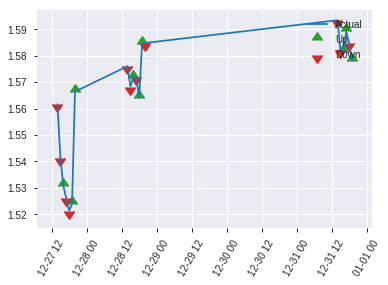


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22338880152901702
RMSE: 0.47264024535476984
LogLoss: 0.6438624336773302
Mean Per-Class Error: 0.3087719298245615
AUC: 0.7013333333333334
pr_auc: 0.5861253874284452
Gini: 0.40266666666666673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19717317819595337: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      26   69   0.7263   (69.0/95.0)
1      4    71   0.0533   (4.0/75.0)
Total  30   140  0.4294   (73.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.197173     0.660465  139
max f2                       0.17393      0.812918  148
max f0point5                 0.43709      0.652742  76
max accuracy                 0.43709      0.694118  76
max precision                0.931199     1         0
max recall                   0.127439     1         163
max specificity              0.931199     1         0
max absolute_mcc             0.43709      0.381494  76
max min_per_class_accuracy   0.43709      0.666667  76
max mean_per_class_accuracy  0.43709      0.691228  76

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 43.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.905604           1.13333   1.13333            0.5              0.919073  0.5                         0.919073            0.0133333       0.0133333                  13.3333   13.3333
    2        0.0235294                   0.883126           2.26667   1.7                1                0.897427  0.75                        0.90825             0.0266667       0.04                       126.667   70
    3        0.0352941                   0.866146           0         1.13333            0                0.869334  0.5                         0.895278            0               0.04                       -100      13.3333
    4        0.0411765                   0.860775           0         0.971429           0                0.861171  0.428571                    0.890406            0               0.04                       -100      -2.85714
    5        0.0529412                   0.844412           1.13333   1.00741            0.5              0.858713  0.444444                    0.883363            0.0133333       0.0533333                  13.3333   0.740741
    6        0.1                         0.776781           1.7       1.33333            0.75             0.796485  0.588235                    0.842479            0.08            0.133333                   70        33.3333
    7        0.152941                    0.712292           1.76296   1.48205            0.777778         0.744935  0.653846                    0.808714            0.0933333       0.226667                   76.2963   48.2051
    8        0.2                         0.64345            1.41667   1.46667            0.625            0.681348  0.647059                    0.778746            0.0666667       0.293333                   41.6667   46.6667
    9        0.3                         0.566926           1.46667   1.46667            0.647059         0.608467  0.647059                    0.721986            0.146667        0.44                       46.6667   46.6667
    10       0.4                         0.481919           1.2       1.4                0.529412         0.524817  0.617647                    0.672694            0.12            0.56                       20        40
    11       0.5                         0.407287           1.2       1.36               0.529412         0.439487  0.6                         0.626053            0.12            0.68                       20        36
    12       0.6                         0.333351           0.666667  1.24444            0.294118         0.362562  0.54902                     0.582138            0.0666667       0.746667                   -33.3333  24.4444
    13       0.7                         0.262227           0.8       1.18095            0.352941         0.294636  0.521008                    0.541066            0.08            0.826667                   -20       18.0952
    14       0.8                         0.207725           0.933333  1.15               0.411765         0.233052  0.507353                    0.502564            0.0933333       0.92                       -6.66667  15
    15       0.9                         0.162918           0.533333  1.08148            0.235294         0.187031  0.477124                    0.467505            0.0533333       0.973333                   -46.6667  8.14815
    16       1                           0.0888772          0.266667  1                  0.117647         0.137603  0.441176                    0.434515            0.0266667      

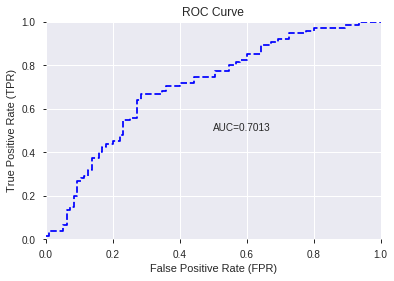

This function is available for GLM models only


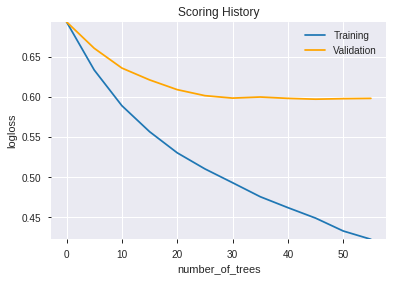

--2019-07-25 04:47:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_044739_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_044739_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'WILLR_8',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'SAREXT',
 'DX_8',
 'hour',
 'DIV',
 'BETA_8',
 'HT_DCPERIOD',
 'PLUS_DI_30',
 'ULTOSC',
 'MOM_30',
 'Volume',
 'WILLR_14',
 'STOCHRSI_fastd',
 'TRANGE',
 'CORREL_12',
 'STOCHRSI_fastk',
 'CORREL_8',
 'MFI_24',
 'ROC_30',
 'aroonup_12',
 'CORREL_14',
 'WILLR_30',
 'aroonup_30',
 'LINEARREG_ANGLE_12',
 'SUB',
 'aroondown_30',
 'aroonup_14',
 'LINEARREG_SLOPE_12',
 'CDLCLOSINGMARUBOZU',
 'CDLSHOOTINGSTAR',
 'CDLSHORTLINE',
 'CDLDRAGONFLYDOJI',
 'ROCP_30',
 'CDLLONGLINE',
 'ROCR_30',
 'CDLTAKURI',
 'CEIL',
 'days_in_month',
 'CDLBELTHOLD',
 'CDLENGULFING',
 'CDLRICKSHAWMAN']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 914 917 926 932] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


50

['BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DI_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MINUS_DI_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_044800_model_9  0.683228  0.658241              0.337193  0.479104  0.229540
1  DeepLearning_grid_1_AutoML_20190725_044800_model_6  0.671439  0.766637              0.347719  0.495003  0.245028
2  DeepLearning_grid_1_AutoML_20190725_044800_model_8  0.653053  0.692547              0.422807  0.489811  0.239915
3  DeepLearning_grid_1_AutoML_20190725_044800_model_4  0.622737  0.836795              0.422807  0.516234  0.266497
4  DeepLearning_grid_1_AutoML_20190725_044800_model_2  0.622035  0.857560              0.454035  0.516411  0.266680
5  DeepLearning_grid_1_AutoML_20190725_044800_model_5  0.614596  0.681136              0.420351  0.491000  0.241081
6  DeepLearning_grid_1_AutoML_20190725_044800_model_3  0.611368  0.902000              0.417895  0.519142  0.269508
7  DeepLearning_grid_1_AutoML_20190725_044800_model_7  0.603930  0.952947              0.411930  0.532182  0.283218
8  DeepLearning_grid_1_AutoML_20190725_044800_model_1  0.580772  1.019524              0.480351  0.550951  0.303548
9               DeepLearning_1_AutoML_20190725_044800  0.566316  0.782553              0.473684  0.524561  0.275164

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.047425
1   CDLCLOSINGMARUBOZU             0.902103           0.902103    0.042782
2          CDLLONGLINE             0.846051           0.846051    0.040124
3          CDLMARUBOZU             0.629227           0.629227    0.029841
4         CDLENGULFING             0.573615           0.573615    0.027203
5          CDLBELTHOLD             0.500066           0.500066    0.023715
6         STOCHF_fastk             0.488404           0.488404    0.023162
7                CCI_8             0.486011           0.486011    0.023049
8               ULTOSC             0.459675           0.459675    0.021800
9              WILLR_8             0.453580           0.453580    0.021511
10      STOCHRSI_fastk             0.440614           0.440614    0.020896
11              CCI_24             0.420309           0.420309    0.019933
12            WILLR_30             0.412468           0.412468    0.019561
13              CCI_12             0.406193           0.406193    0.019264
14              CCI_30             0.396135           0.396135    0.018787
15            WILLR_12             0.386017           0.386017    0.018307
16         STOCH_slowd             0.379026           0.379026    0.017975
17              CCI_20             0.378989           0.378989    0.017973
18              RSI_24             0.375858           0.375858    0.017825
19              CCI_14             0.374290           0.374290    0.017751
20         MINUS_DI_14             0.370926           0.370926    0.017591
21            WILLR_14             0.370452           0.370452    0.017569
22        STOCHF_fastd             0.369093           0.369093    0.017504
23          ROCR100_12             0.368560           0.368560    0.017479
24               MOM_8             0.368170           0.368170    0.017460
25              CMO_20             0.367992           0.367992    0.017452
26              CMO_14             0.367978           0.367978    0.017451
27               CMO_8             0.366896           0.366896    0.017400
28             ROCR_12             0.365639           0.365639    0.017340
29   LINEARREG_ANGLE_8             0.365051           0.365051    0.017312
30              CMO_24             0.364072           0.364072    0.017266
31         STOCH_slowk             0.364017           0.364017    0.017263
32              RSI_20             0.363908           0.363908    0.017258
33              CMO_12             0.362087           0.362087    0.017172
34               RSI_8             0.361840           0.361840    0.017160
35            WILLR_20             0.360539           0.360539    0.017098
36           ROCR100_8             0.359775           0.359775    0.017062
37         MINUS_DI_12             0.359548           0.359548    0.017051
38          MINUS_DI_8             0.359547           0.359547    0.017051
39               ROC_8             0.358846           0.358846    0.017018
40              ROC_12             0.353861           0.353861    0.016782
41              RSI_12             0.352487           0.352487    0.016717
42            WILLR_24             0.351822           0.351822    0.016685
43               ADOSC             0.351464           0.351464    0.016668
44   LINEARREG_SLOPE_8             0.350856           0.350856    0.016639
45      STOCHRSI_fastd             0.349817           0.349817    0.016590
46              RSI_14             0.349563           0.349563    0.016578
47             ROCP_12             0.346945           0.346945    0.016454
48              ROCP_8             0.338373           0.338373    0.016047
49              ROCR_8             0.337333           0.337333    0.015998

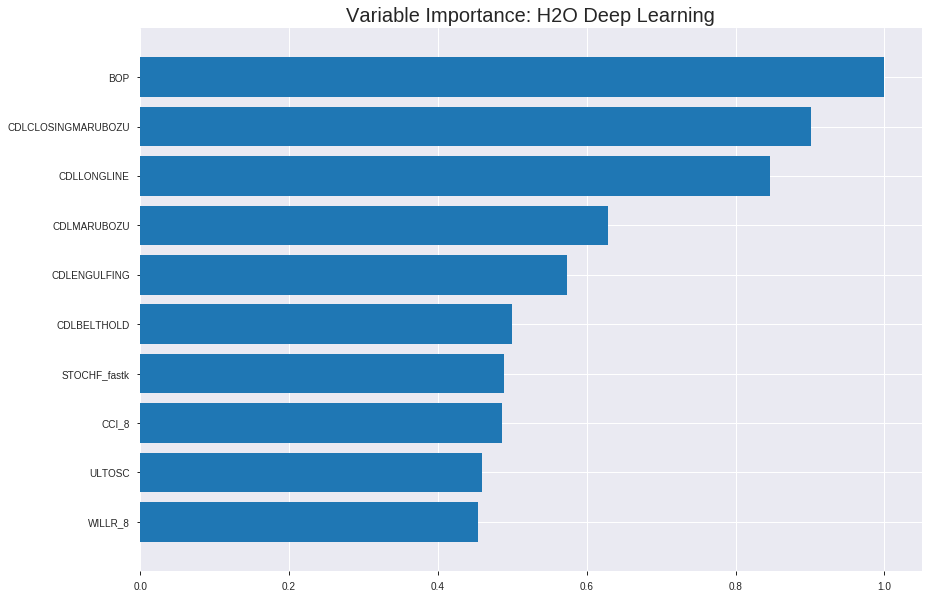

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_044800_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20271685186669222
RMSE: 0.45024088204725726
LogLoss: 0.5910219595226178
Mean Per-Class Error: 0.3016186835163207
AUC: 0.7547674531231305
pr_auc: 0.7549885547115668
Gini: 0.5095349062462611
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4160445044391658: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      358  240  0.4013   (240.0/598.0)
1      126  461  0.2147   (126.0/587.0)
Total  484  701  0.3089   (366.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416045     0.715839  235
max f2                       0.215629     0.834551  351
max f0point5                 0.513803     0.696554  175
max accuracy                 0.464005     0.69789   206
max precision                0.911456     1         0
max recall                   0.112011     1         395
max specificity              0.911456     1         0
max absolute_mcc             0.448832     0.39883   216
max min_per_class_accuracy   0.482583     0.690635  194
max mean_per_class_accuracy  0.448832     0.698381  216

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 46.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.903114           2.01874   2.01874            1                0.906228  1                           0.906228            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.89542            2.01874   2.01874            1                0.900632  1                           0.90343             0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.849277           2.01874   2.01874            1                0.870255  1                           0.892372            0.0204429       0.0613288                  101.874   101.874
    4        0.0405063                   0.837862           1.85051   1.97668            0.916667         0.845121  0.979167                    0.880559            0.0187394       0.0800681                  85.0511   97.6682
    5        0.0506329                   0.815391           1.51405   1.88416            0.75             0.826579  0.933333                    0.869763            0.0153322       0.0954003                  51.4055   88.4157
    6        0.100422                    0.731456           1.7108    1.7982             0.847458         0.769707  0.890756                    0.820155            0.0851789       0.180579                   71.0796   79.8205
    7        0.150211                    0.648005           1.60815   1.73521            0.79661          0.681888  0.859551                    0.774325            0.0800681       0.260647                   60.8148   73.5209
    8        0.2                         0.616267           1.43707   1.66099            0.711864         0.633036  0.822785                    0.739152            0.0715503       0.332198                   43.7069   66.0988
    9        0.300422                    0.566569           1.30624   1.54241            0.647059         0.591455  0.764045                    0.689781            0.131175        0.463373                   30.6243   54.2408
    10       0.4                         0.526901           1.14623   1.44378            0.567797         0.543572  0.71519                     0.653383            0.11414         0.577513                   14.6233   44.3782
    11       0.500422                    0.480838           1.15357   1.38554            0.571429         0.508797  0.686341                    0.624369            0.115843        0.693356                   15.3565   38.5543
    12       0.6                         0.408588           0.975154  1.31743            0.483051         0.44757   0.652602                    0.595026            0.0971039       0.79046                    -2.48462  31.7433
    13       0.699578                    0.342764           0.547455  1.20783            0.271186         0.376218  0.598311                    0.563881            0.0545145       0.844974                   -45.2545  20.7834
    14       0.8                         0.286413           0.678568  1.1414             0.336134         0.315138  0.565401                    0.532657            0.0681431       0.913118                   -32.1432  14.1397
    15       0.899578                    0.221181           0.564563  1.07754            0.279661         0.253654  0.533771                    0.501773            0.0562181       0.969336                   -43.5437  7.75447
    16       1                           0.0971659          0.305356  1                  0.151261         0.177799  0.495359                    0.469239         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2060386501109772
RMSE: 0.4539148049039348
LogLoss: 0.5993750148520848
Mean Per-Class Error: 0.28672919437250655
AUC: 0.7551620354168124
pr_auc: 0.7026207475917212
Gini: 0.5103240708336247
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41009103427678784: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  68   0.3736   (68.0/182.0)
1      33   124  0.2102   (33.0/157.0)
Total  147  192  0.2979   (101.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410091     0.710602  191
max f2                       0.265968     0.831498  279
max f0point5                 0.509162     0.687204  118
max accuracy                 0.439056     0.710914  170
max precision                0.900837     1         0
max recall                   0.137054     1         336
max specificity              0.900837     1         0
max absolute_mcc             0.437296     0.425604  174
max min_per_class_accuracy   0.453243     0.700637  163
max mean_per_class_accuracy  0.437296     0.713271  174

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 44.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.844015           2.15924   2.15924            1                0.87514   1                           0.87514             0.0254777       0.0254777                  115.924   115.924
    2        0.020649                    0.83748            2.15924   2.15924            1                0.8408    1                           0.860423            0.0191083       0.044586                   115.924   115.924
    3        0.0324484                   0.803083           1.61943   1.96294            0.75             0.818763  0.909091                    0.845274            0.0191083       0.0636943                  61.9427   96.2942
    4        0.0412979                   0.784322           1.43949   1.85077            0.666667         0.793845  0.857143                    0.834253            0.0127389       0.0764331                  43.949    85.0773
    5        0.0501475                   0.774617           2.15924   1.90521            1                0.781207  0.882353                    0.824892            0.0191083       0.0955414                  115.924   90.5208
    6        0.100295                    0.687186           1.39715   1.65118            0.647059         0.730588  0.764706                    0.77774             0.0700637       0.165605                   39.7152   65.118
    7        0.150442                    0.606292           1.77819   1.69352            0.823529         0.639535  0.784314                    0.731672            0.089172        0.254777                   77.8194   69.3518
    8        0.20059                     0.576725           1.52417   1.65118            0.705882         0.591597  0.764706                    0.696653            0.0764331       0.33121                    52.4166   65.118
    9        0.300885                    0.521602           1.39715   1.5665             0.647059         0.542379  0.72549                     0.645228            0.140127        0.471338                   39.7152   56.6504
    10       0.40118                     0.48668            1.33365   1.50829            0.617647         0.505726  0.698529                    0.610353            0.133758        0.605096                   33.3646   50.829
    11       0.501475                    0.441128           1.20663   1.44796            0.558824         0.467958  0.670588                    0.581874            0.121019        0.726115                   20.6632   44.7958
    12       0.59882                     0.398269           0.785177  1.34022            0.363636         0.417833  0.62069                     0.555207            0.0764331       0.802548                   -21.4823  34.0215
    13       0.699115                    0.322299           0.444549  1.21172            0.205882         0.367373  0.561181                    0.52826             0.044586        0.847134                   -55.5451  21.1723
    14       0.79941                     0.278835           0.952604  1.17921            0.441176         0.301947  0.546125                    0.499867            0.0955414       0.942675                   -4.7396   17.9214
    15       0.899705                    0.235132           0.317535  1.08316            0.147059         0.255304  0.501639                    0.472604            0.0318471       0.974522                   -68.2465  8.31576
    16       1                           0.107909           0.254028  1                  0.117647         0.190538  0.463127                    0.444314            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:54:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:54:29  2 min  4.884 sec  535 obs/sec       1         1             1185       0.610699         1.13742             -0.491943      0.691913        0.68831            1.85051          0.427848                         0.607214           1.15099               -0.482901        0.683383          0.639311             1.61943            0.430678
    2019-07-25 04:54:38  2 min 14.246 sec  773 obs/sec       7         7             8295       0.4588           0.609042            0.157938       0.743988        0.742569           2.01874          0.319831                         0.463221           0.618791              0.137013         0.741478          0.684661             1.61943            0.353982
    2019-07-25 04:54:48  2 min 23.729 sec  918 obs/sec       15        15            17775      0.458567         0.608358            0.158792       0.750568        0.750446           2.01874          0.304641                         0.460375           0.611539              0.147584         0.750927          0.696569             2.15924            0.303835
    2019-07-25 04:54:56  2 min 32.319 sec  1004 obs/sec      23        23            27255      0.450241         0.591022            0.189063       0.754767        0.754989           2.01874          0.308861                         0.453915           0.599375              0.171339         0.755162          0.702621             2.15924            0.297935
    2019-07-25 04:55:05  2 min 41.211 sec  1078 obs/sec      32        32            37920      0.454713         0.599479            0.172872       0.754658        0.75561            2.01874          0.299578                         0.464416           0.622045              0.132553         0.739343          0.697341             2.15924            0.306785
    2019-07-25 04:55:14  2 min 50.355 sec  1144 obs/sec      42        42            49770      0.448899         0.58703             0.193889       0.757816        0.761583           2.01874          0.305485                         0.456732           0.605101              0.161019         0.741093          0.696771             2.15924            0.289086
    2019-07-25 04:55:23  2 min 59.095 sec  1199 obs/sec      52        52            61620      0.446312         0.58218             0.203153       0.760821        0.763922           2.01874          0.308017                         0.453962           0.602089              0.171167         0.745153          0.705149             2.15924            0.294985
    2019-07-25 04:55:24  2 min 59.990 sec  1198 obs/sec      52        52            61620      0.450241         0.591022            0.189063       0.754767        0.754989           2.01874          0.308861                         0.453915           0.599375              0.171339         0.755162          0.702621             2.15924            0.297935

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04742462909174645
CDLCLOSINGMARUBOZU  0.9021031260490417     0.9021031260490417   0.04278190615538079
CDLLONGLINE         0.8460507392883301     0.8460507392883301   0.04012364250354693
CDLMARUBOZU         0.6292267441749573     0.6292267441749573   0.029840844957104578
CDLENGULFING        0.5736149549484253     0.5736149549484253   0.027203476479907916
---                 ---                    ---                  ---
STOCHRSI_fastd      0.34981733560562134    0.34981733560562134  0.01658995739095958
RSI_14              0.34956347942352295    0.34956347942352295  0.016577918355680916
ROCP_12             0.3469448983669281     0.3469448983669281   0.01645373312032523
ROCP_8              0.3383731245994568     0.3383731245994568   0.016047219928744545
ROCR_8              0.3373331129550934     0.3373331129550934   0.015997897762259513


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6764705882352942)

('F1', 0.6549707602339181)

('auc', 0.6832280701754386)

('logloss', 0.6582411031255813)

('mean_per_class_error', 0.3354385964912281)

('rmse', 0.4791036500449013)

('mse', 0.22954030748634727)

deeplearning prediction progress: |███████████████████████████████████████| 100%


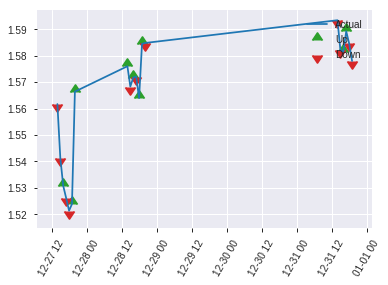


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22954030748634727
RMSE: 0.4791036500449013
LogLoss: 0.6582411031255813
Mean Per-Class Error: 0.3354385964912281
AUC: 0.6832280701754386
pr_auc: 0.5866518129250557
Gini: 0.36645614035087726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3945247819725353: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   40   0.4211   (40.0/95.0)
1      19   56   0.2533   (19.0/75.0)
Total  74   96   0.3471   (59.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394525     0.654971  95
max f2                       0.154346     0.809935  162
max f0point5                 0.53297      0.63745   43
max accuracy                 0.53297      0.676471  43
max precision                0.905109     1         0
max recall                   0.154346     1         162
max specificity              0.905109     1         0
max absolute_mcc             0.53297      0.340494  43
max min_per_class_accuracy   0.417079     0.653333  80
max mean_per_class_accuracy  0.46297      0.664561  72

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 42.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.895707           1.13333   1.13333            0.5              0.900507  0.5                         0.900507            0.0133333       0.0133333                  13.3333   13.3333
    2        0.0235294                   0.88286            2.26667   1.7                1                0.894879  0.75                        0.897693            0.0266667       0.04                       126.667   70
    3        0.0352941                   0.850333           0         1.13333            0                0.857516  0.5                         0.884301            0               0.04                       -100      13.3333
    4        0.0411765                   0.842878           0         0.971429           0                0.847107  0.428571                    0.878987            0               0.04                       -100      -2.85714
    5        0.0529412                   0.8214             2.26667   1.25926            1                0.840279  0.555556                    0.870386            0.0266667       0.0666667                  126.667   25.9259
    6        0.1                         0.660738           1.41667   1.33333            0.625            0.738377  0.588235                    0.808264            0.0666667       0.133333                   41.6667   33.3333
    7        0.152941                    0.602552           1.76296   1.48205            0.777778         0.619345  0.653846                    0.742869            0.0933333       0.226667                   76.2963   48.2051
    8        0.2                         0.551874           1.7       1.53333            0.75             0.57354   0.676471                    0.703027            0.08            0.306667                   70        53.3333
    9        0.3                         0.520476           1.46667   1.51111            0.647059         0.535493  0.666667                    0.647182            0.146667        0.453333                   46.6667   51.1111
    10       0.4                         0.481042           1.06667   1.4                0.470588         0.505244  0.617647                    0.611698            0.106667        0.56                       6.66667   40
    11       0.5                         0.409515           0.933333  1.30667            0.411765         0.439944  0.576471                    0.577347            0.0933333       0.653333                   -6.66667  30.6667
    12       0.6                         0.367156           1.06667   1.26667            0.470588         0.394056  0.558824                    0.546798            0.106667        0.76                       6.66667   26.6667
    13       0.7                         0.308007           0.533333  1.1619             0.235294         0.339129  0.512605                    0.517131            0.0533333       0.813333                   -46.6667  16.1905
    14       0.8                         0.238518           0.533333  1.08333            0.235294         0.274901  0.477941                    0.486853            0.0533333       0.866667                   -46.6667  8.33333
    15       0.9                         0.195766           0.666667  1.03704            0.294118         0.215205  0.457516                    0.45667             0.0666667       0.933333                   -33.3333  3.7037
    16       1                           0.108446           0.666667  1                  0.294118         0.15879   0.441176                    0.426882            0.06666

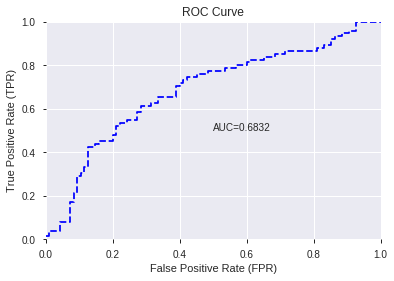

This function is available for GLM models only


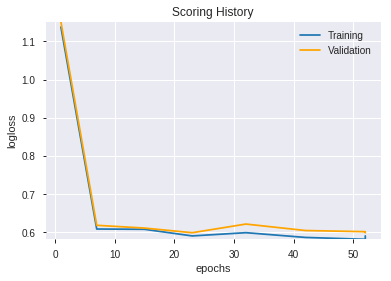

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'CCI_8',
 'ULTOSC',
 'WILLR_8',
 'STOCHRSI_fastk',
 'CCI_24',
 'WILLR_30',
 'CCI_12',
 'CCI_30',
 'WILLR_12',
 'STOCH_slowd',
 'CCI_20',
 'RSI_24',
 'CCI_14',
 'MINUS_DI_14',
 'WILLR_14',
 'STOCHF_fastd',
 'ROCR100_12',
 'MOM_8',
 'CMO_20',
 'CMO_14',
 'CMO_8',
 'ROCR_12',
 'LINEARREG_ANGLE_8',
 'CMO_24',
 'STOCH_slowk',
 'RSI_20',
 'CMO_12',
 'RSI_8',
 'WILLR_20',
 'ROCR100_8',
 'MINUS_DI_12',
 'MINUS_DI_8',
 'ROC_8',
 'ROC_12',
 'RSI_12',
 'WILLR_24',
 'ADOSC',
 'LINEARREG_SLOPE_8',
 'STOCHRSI_fastd',
 'RSI_14',
 'ROCP_12',
 'ROCP_8',
 'ROCR_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_045531_model_1  0.660351  0.683903              0.355439  0.487232  0.237395

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.563831           1.000000    0.150620
1              WILLR_8             0.310386           0.550495    0.082915
2                CCI_8             0.269394           0.477793    0.071965
3   CDLCLOSINGMARUBOZU             0.218085           0.386792    0.058258
4         STOCHF_fastk             0.195545           0.346815    0.052237
5               ULTOSC             0.185837           0.329598    0.049644
6             WILLR_30             0.180145           0.319502    0.048123
7               CCI_30             0.126255           0.223924    0.033727
8                MOM_8             0.112838           0.200127    0.030143
9         STOCHF_fastd             0.103801           0.184100    0.027729
10            WILLR_14             0.103559           0.183670    0.027664
11         STOCH_slowk             0.103365           0.183326    0.027612
12              CCI_14             0.103075           0.182813    0.027535
13         CDLLONGLINE             0.098683           0.175023    0.026362
14         CDLMARUBOZU             0.093531           0.165885    0.024986
15            WILLR_12             0.077661           0.137738    0.020746
16         MINUS_DI_14             0.075013           0.133041    0.020039
17              CCI_24             0.070846           0.125651    0.018925
18         MINUS_DI_12             0.070184           0.124477    0.018749
19         STOCH_slowd             0.060829           0.107885    0.016250
20        CDLENGULFING             0.059863           0.106172    0.015992
21         CDLBELTHOLD             0.058512           0.103776    0.015631
22            WILLR_20             0.054200           0.096127    0.014479
23   LINEARREG_ANGLE_8             0.041692           0.073944    0.011137
24   LINEARREG_SLOPE_8             0.041155           0.072992    0.010994
25              CCI_20             0.040051           0.071034    0.010699
26              CCI_12             0.032140           0.057002    0.008586
27          ROCR100_12             0.025387           0.045026    0.006782
28             ROCR_12             0.025245           0.044774    0.006744
29             ROCP_12             0.025096           0.044510    0.006704
30              ROC_12             0.024978           0.044301    0.006673
31      STOCHRSI_fastk             0.024823           0.044025    0.006631
32               ADOSC             0.023275           0.041281    0.006218
33          MINUS_DI_8             0.022641           0.040155    0.006048
34              RSI_24             0.018655           0.033087    0.004983
35               CMO_8             0.018394           0.032623    0.004914
36              CMO_24             0.018368           0.032576    0.004907
37            WILLR_24             0.014787           0.026227    0.003950
38               RSI_8             0.013305           0.023597    0.003554
39              RSI_14             0.006636           0.011769    0.001773
40              RSI_12             0.006240           0.011068    0.001667
41              CMO_12             0.005597           0.009928    0.001495
42      STOCHRSI_fastd             0.005341           0.009473    0.001427
43              CMO_14             0.004971           0.008816    0.001328
44              RSI_20             0.003717           0.006593    0.000993
45              CMO_20             0.003343           0.005929    0.000893
46               ROC_8             0.000921           0.001633    0.000246
47              ROCP_8             0.000590           0.001046    0.000158
48              ROCR_8             0.000396           0.000702    0.000106
49           ROCR100_8             0.000230           0.000407    0.000061

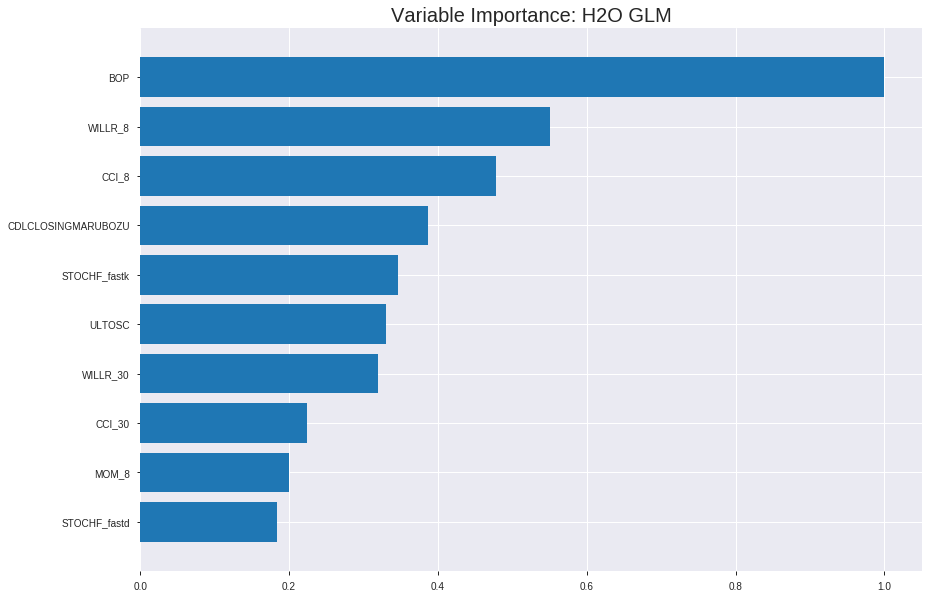

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_045531_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20143619486930814
RMSE: 0.4488164378332284
LogLoss: 0.5874400095117789
Null degrees of freedom: 1184
Residual degrees of freedom: 1134
Null deviance: 1642.6567067559345
Residual deviance: 1392.232822542916
AIC: 1494.232822542916
AUC: 0.7543971101855703
pr_auc: 0.7560724931251798
Gini: 0.5087942203711406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3978720843732005: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      304  294  0.4916   (294.0/598.0)
1      99   488  0.1687   (99.0/587.0)
Total  403  782  0.3316   (393.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397872     0.712929  255
max f2                       0.127795     0.834528  373
max f0point5                 0.541645     0.696583  174
max accuracy                 0.489196     0.697046  201
max precision                0.94739      1         0
max recall                   0.0593407    1         395
max specificity              0.94739      1         0
max absolute_mcc             0.489196     0.394707  201
max min_per_class_accuracy   0.506724     0.693356  191
max mean_per_class_accuracy  0.489196     0.697232  201

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.920271           2.01874   2.01874            1                0.929426  1                           0.929426            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.90869            2.01874   2.01874            1                0.915053  1                           0.922239            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.893003           2.01874   2.01874            1                0.900989  1                           0.915156            0.0204429       0.0613288                  101.874   101.874
    4        0.0405063                   0.872809           1.85051   1.97668            0.916667         0.883917  0.979167                    0.907346            0.0187394       0.0800681                  85.0511   97.6682
    5        0.0506329                   0.849243           2.01874   1.98509            1                0.856551  0.983333                    0.897187            0.0204429       0.100511                   101.874   98.5094
    6        0.100422                    0.764073           1.64236   1.81517            0.813559         0.801548  0.89916                     0.849769            0.0817717       0.182283                   64.2364   81.5169
    7        0.150211                    0.710958           1.40285   1.6785             0.694915         0.736251  0.831461                    0.812142            0.0698467       0.252129                   40.2853   67.8502
    8        0.2                         0.679509           1.36864   1.60136            0.677966         0.695686  0.793249                    0.783151            0.0681431       0.320273                   36.8637   60.1363
    9        0.300422                    0.614012           1.47589   1.55942            0.731092         0.645825  0.772472                    0.737247            0.148211        0.468484                   47.5885   55.9419
    10       0.4                         0.561648           1.19756   1.46934            0.59322          0.590137  0.727848                    0.700625            0.11925         0.587734                   19.7557   46.9336
    11       0.500422                    0.500921           1.06874   1.38895            0.529412         0.533962  0.688027                    0.66718             0.107325        0.69506                    6.87444   38.8947
    12       0.6                         0.431322           0.92383   1.31175            0.457627         0.466897  0.649789                    0.63394             0.0919932       0.787053                   -7.61701  31.1755
    13       0.699578                    0.365325           0.66721   1.22001            0.330508         0.401702  0.604343                    0.600883            0.0664395       0.853492                   -33.279   22.001
    14       0.8                         0.306256           0.542854  1.13501            0.268908         0.337159  0.562236                    0.567779            0.0545145       0.908007                   -45.7146  13.5009
    15       0.899578                    0.226797           0.598779  1.07565            0.29661          0.270147  0.532833                    0.534833            0.0596252       0.967632                   -40.1221  7.5651
    16       1                           0.035917           0.32232   1                  0.159664         0.141751  0.495359                    0.495359           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20321783190866433
RMSE: 0.45079688542476015
LogLoss: 0.5939123093448367
Null degrees of freedom: 338
Residual degrees of freedom: 288
Null deviance: 469.5188524558861
Residual deviance: 402.67254573579925
AIC: 504.67254573579925
AUC: 0.749807517323441
pr_auc: 0.7041993062151329
Gini: 0.49961503464688195
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35840891123138496: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      89   93   0.511    (93.0/182.0)
1      22   135  0.1401   (22.0/157.0)
Total  111  228  0.3392   (115.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358409     0.701299  227
max f2                       0.206493     0.823529  306
max f0point5                 0.485576     0.677541  159
max accuracy                 0.485576     0.702065  159
max precision                0.904475     1         0
max recall                   0.0659971    1         337
max specificity              0.904475     1         0
max absolute_mcc             0.481189     0.403046  163
max min_per_class_accuracy   0.481189     0.700637  163
max mean_per_class_accuracy  0.481189     0.701967  163

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 46.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.881045           2.15924   2.15924            1                0.891538  1                           0.891538            0.0254777       0.0254777                  115.924   115.924
    2        0.020649                    0.875605           1.43949   1.85077            0.666667         0.877878  0.857143                    0.885684            0.0127389       0.0382166                  43.949    85.0773
    3        0.0324484                   0.85754            2.15924   1.96294            1                0.863759  0.909091                    0.877711            0.0254777       0.0636943                  115.924   96.2942
    4        0.0412979                   0.828734           2.15924   2.005              1                0.840559  0.928571                    0.86975             0.0191083       0.0828025                  115.924   100.5
    5        0.0501475                   0.787856           2.15924   2.03222            1                0.80754   0.941176                    0.858772            0.0191083       0.101911                   115.924   103.222
    6        0.100295                    0.726983           1.39715   1.71469            0.647059         0.760205  0.794118                    0.809488            0.0700637       0.171975                   39.7152   71.4687
    7        0.150442                    0.679297           1.39715   1.60884            0.647059         0.702032  0.745098                    0.77367             0.0700637       0.242038                   39.7152   60.8842
    8        0.20059                     0.63953            1.52417   1.58767            0.705882         0.65714   0.735294                    0.744537            0.0764331       0.318471                   52.4166   58.7673
    9        0.300885                    0.56286            1.46066   1.54534            0.676471         0.604937  0.715686                    0.698004            0.146497        0.464968                   46.0659   54.5335
    10       0.40118                     0.53341            1.33365   1.49241            0.617647         0.550432  0.691176                    0.661111            0.133758        0.598726                   33.3646   49.2413
    11       0.501475                    0.472208           1.14312   1.42256            0.529412         0.498249  0.658824                    0.628539            0.11465         0.713376                   14.3125   42.2555
    12       0.59882                     0.414888           0.850608  1.32958            0.393939         0.43947   0.615764                    0.597803            0.0828025       0.796178                   -14.9392  32.9579
    13       0.699115                    0.340717           0.762083  1.24817            0.352941         0.37786   0.578059                    0.56625             0.0764331       0.872611                   -23.7917  24.8166
    14       0.79941                     0.299649           0.571562  1.16328            0.264706         0.319171  0.538745                    0.535251            0.0573248       0.929936                   -42.8438  16.3278
    15       0.899705                    0.210967           0.444549  1.08316            0.205882         0.256878  0.501639                    0.50422             0.044586        0.974522                   -55.5451  8.31576
    16       1                           0.0485252          0.254028  1                  0.117647         0.14672   0.463127                    0.468364           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 04:55:31  0.000 sec   2            .2E2      51            1.3588087864020761  1.3615370607800275
     2019-07-25 04:55:31  0.009 sec   4            .13E2     51            1.3484535511924887  1.3530215083182338
     2019-07-25 04:55:31  0.020 sec   6            .79E1     51            1.3360124576845305  1.3428201883215187
     2019-07-25 04:55:31  0.030 sec   8            .49E1     51            1.3214584765601598  1.3306429969194837
     2019-07-25 04:55:31  0.041 sec   10           .3E1      51            1.304708737582929   1.3160008144286692
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 04:55:31  0.154 sec   34           .1E-1     51            1.1712995099760013  1.1879938708067683
     2019-07-25 04:55:32  0.162 sec   36           .62E-2    51            1.1681168129325523  1.1895851184860273
     2019-07-25 04:55:32  0.174 sec   38           .38E-2    51            1.1654065961121516  1.1924296845649824
     2019-07-25 04:55:32  0.186 sec   40           .24E-2    51            1.163311766198628   1.1965064276933572
     2019-07-25 04:55:32  0.194 sec   42           .15E-2    51            1.1618303124242142  1.201640639697244


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6588235294117647)

('F1', 0.6480446927374302)

('auc', 0.6603508771929825)

('logloss', 0.6839027474871644)

('mean_per_class_error', 0.3431578947368421)

('rmse', 0.48723211128055793)

('mse', 0.23739513026291)

glm prediction progress: |████████████████████████████████████████████████| 100%


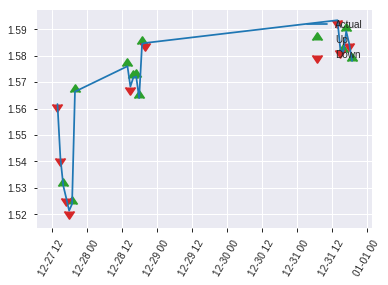


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23739513026291
RMSE: 0.48723211128055793
LogLoss: 0.6839027474871644
Null degrees of freedom: 169
Residual degrees of freedom: 119
Null deviance: 235.31337198870415
Residual deviance: 232.52693414563592
AIC: 334.5269341456359
AUC: 0.6603508771929825
pr_auc: 0.5793484319346056
Gini: 0.32070175438596493
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37696592008238483: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   46   0.4842   (46.0/95.0)
1      17   58   0.2267   (17.0/75.0)
Total  66   104  0.3706   (63.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376966     0.648045  103
max f2                       0.0852514    0.80819   163
max f0point5                 0.448936     0.613811  78
max accuracy                 0.448936     0.658824  78
max precision                0.931784     1         0
max recall                   0.0852514    1         163
max specificity              0.931784     1         0
max absolute_mcc             0.448936     0.312285  78
max min_per_class_accuracy   0.448936     0.64      78
max mean_per_class_accuracy  0.448936     0.656842  78

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 44.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.914635           2.26667   2.26667            1                0.926454  1                           0.926454            0.0266667       0.0266667                  126.667   126.667
    2        0.0235294                   0.898614           1.13333   1.7                0.5              0.908198  0.75                        0.917326            0.0133333       0.04                       13.3333   70
    3        0.0352941                   0.886798           1.13333   1.51111            0.5              0.888116  0.666667                    0.90759             0.0133333       0.0533333                  13.3333   51.1111
    4        0.0411765                   0.877074           2.26667   1.61905            1                0.877334  0.714286                    0.903267            0.0133333       0.0666667                  126.667   61.9048
    5        0.0529412                   0.865003           0         1.25926            0                0.871906  0.555556                    0.896298            0               0.0666667                  -100      25.9259
    6        0.1                         0.736321           1.41667   1.33333            0.625            0.802196  0.588235                    0.852015            0.0666667       0.133333                   41.6667   33.3333
    7        0.152941                    0.668049           2.01481   1.56923            0.888889         0.699316  0.692308                    0.799158            0.106667        0.24                       101.481   56.9231
    8        0.2                         0.639419           0.85      1.4                0.375            0.650333  0.617647                    0.76414             0.04            0.28                       -15       40
    9        0.3                         0.578722           1.46667   1.42222            0.647059         0.611117  0.627451                    0.713132            0.146667        0.426667                   46.6667   42.2222
    10       0.4                         0.505637           1.06667   1.33333            0.470588         0.547346  0.588235                    0.671686            0.106667        0.533333                   6.66667   33.3333
    11       0.5                         0.424645           1.06667   1.28               0.470588         0.459804  0.564706                    0.629309            0.106667        0.64                       6.66667   28
    12       0.6                         0.384442           1.06667   1.24444            0.470588         0.404862  0.54902                     0.591902            0.106667        0.746667                   6.66667   24.4444
    13       0.7                         0.319095           0.533333  1.14286            0.235294         0.346017  0.504202                    0.556775            0.0533333       0.8                        -46.6667  14.2857
    14       0.8                         0.22936            0.4       1.05               0.176471         0.269152  0.463235                    0.520822            0.04            0.84                       -60       5
    15       0.9                         0.16738            0.533333  0.992593           0.235294         0.192259  0.437908                    0.484315            0.0533333       0.893333                   -46.6667  -0.740741
    16       1                           0.0630254          1.06667   1                  0.470588         0.105656  0.441176                    0.446449            0.106667        

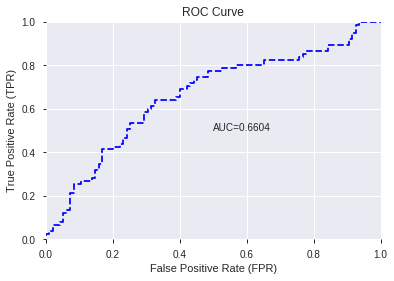

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


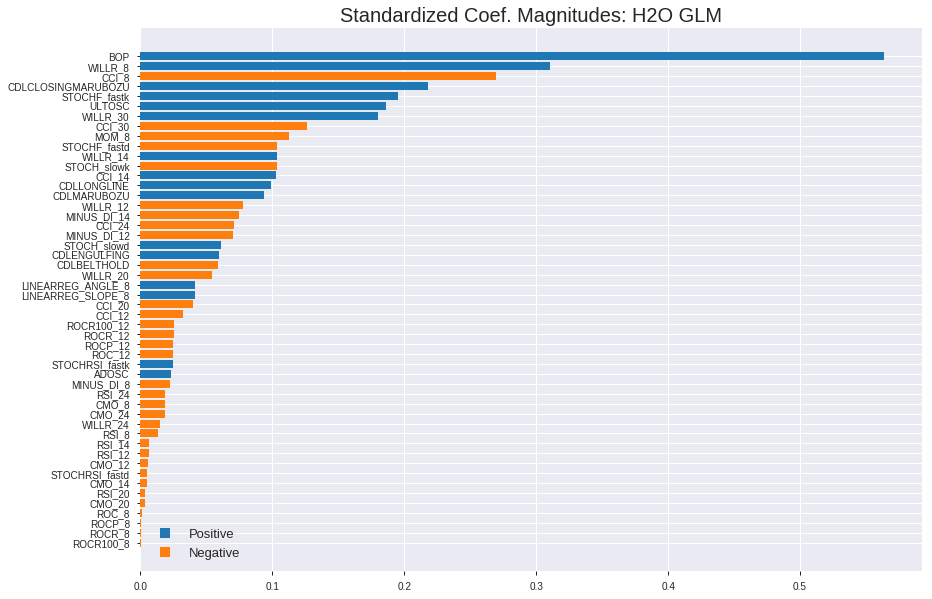

'log_likelihood'
--2019-07-25 04:55:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_045531_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_045531_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'WILLR_8',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'ULTOSC',
 'WILLR_30',
 'CCI_30',
 'MOM_8',
 'STOCHF_fastd',
 'WILLR_14',
 'STOCH_slowk',
 'CCI_14',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'WILLR_12',
 'MINUS_DI_14',
 'CCI_24',
 'MINUS_DI_12',
 'STOCH_slowd',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'WILLR_20',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'CCI_20',
 'CCI_12',
 'ROCR100_12',
 'ROCR_12',
 'ROCP_12',
 'ROC_12',
 'STOCHRSI_fastk',
 'ADOSC',
 'MINUS_DI_8',
 'RSI_24',
 'CMO_8',
 'CMO_24',
 'WILLR_24',
 'RSI_8',
 'RSI_14',
 'RSI_12',
 'CMO_12',
 'STOCHRSI_fastd',
 'CMO_14',
 'RSI_20',
 'CMO_20',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8']

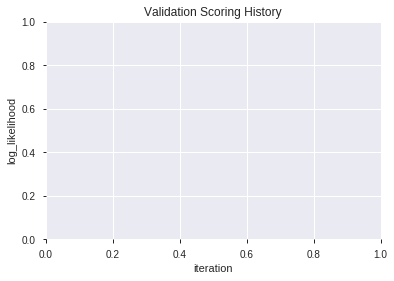

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_045547_model_4  0.672211  0.648219              0.346667  0.476645  0.227190
1  XGBoost_grid_1_AutoML_20190725_045547_model_2  0.668491  0.652625              0.357895  0.478619  0.229076
2  XGBoost_grid_1_AutoML_20190725_045547_model_6  0.658246  0.671565              0.421404  0.485907  0.236105
3               XGBoost_3_AutoML_20190725_045547  0.654596  0.687625              0.414035  0.489462  0.239573
4  XGBoost_grid_1_AutoML_20190725_045547_model_1  0.653754  0.693180              0.423158  0.490172  0.240269
5               XGBoost_2_AutoML_20190725_045547  0.648912  0.683798              0.391930  0.489739  0.239845
6  XGBoost_grid_1_AutoML_20190725_045547_model_3  0.641825  0.691024              0.463158  0.492724  0.242777
7  XGBoost_grid_1_AutoML_20190725_045547_model_7  0.635228  0.708633              0.345614  0.498201  0.248205
8  XGBoost_grid_1_AutoML_20190725_045547_model_5  0.631579  0.702509              0.428070  0.496440  0.246452
9               XGBoost_1_AutoML_20190725_045547  0.617965  0.717737              0.469825  0.503757  0.253771

variable  relative_importance  scaled_importance  percentage
0                 BOP          1313.975342           1.000000    0.407413
1        STOCHF_fastk           366.685120           0.279065    0.113695
2             WILLR_8           227.221146           0.172926    0.070452
3               CCI_8           167.715179           0.127640    0.052002
4              ULTOSC           108.769966           0.082779    0.033725
5      STOCHRSI_fastk            99.092033           0.075414    0.030725
6              CCI_12            81.330292           0.061896    0.025217
7            WILLR_30            65.100838           0.049545    0.020185
8         STOCH_slowk            63.210434           0.048106    0.019599
9               ADOSC            62.293198           0.047408    0.019315
10  LINEARREG_ANGLE_8            59.253922           0.045095    0.018372
11             CCI_24            56.375435           0.042904    0.017480
12              MOM_8            56.366508           0.042898    0.017477
13         MINUS_DI_8            54.808502           0.041712    0.016994
14              CMO_8            48.882515           0.037202    0.015157
15     STOCHRSI_fastd            43.060017           0.032771    0.013351
16           WILLR_14            38.108852           0.029003    0.011816
17             CMO_24            37.414665           0.028474    0.011601
18           WILLR_24            35.548149           0.027054    0.011022
19             CCI_20            33.093319           0.025186    0.010261
20             CCI_30            26.394600           0.020088    0.008184
21        STOCH_slowd            24.679857           0.018783    0.007652
22             ROC_12            24.379152           0.018554    0.007559
23             CMO_12            18.404152           0.014006    0.005706
24             CMO_20            17.924265           0.013641    0.005558
25           WILLR_20            16.941517           0.012893    0.005253
26              ROC_8            15.969385           0.012153    0.004951
27        MINUS_DI_12            14.979008           0.011400    0.004644
28             CCI_14            14.540422           0.011066    0.004508
29           WILLR_12            14.025206           0.010674    0.004349
30        MINUS_DI_14             9.521917           0.007247    0.002952
31             CMO_14             9.103371           0.006928    0.002823

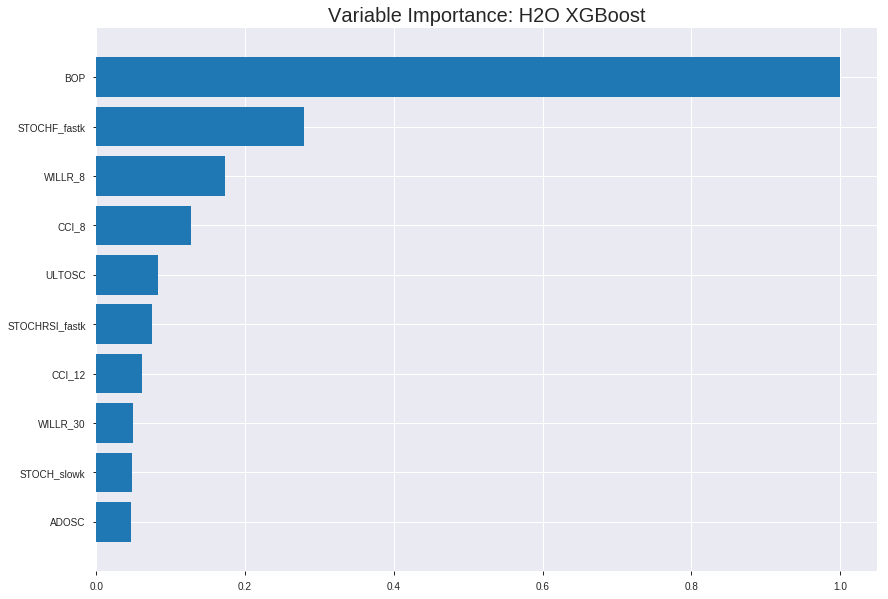

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_045547_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18187240562542303
RMSE: 0.4264650110213299
LogLoss: 0.5451982446179786
Mean Per-Class Error: 0.25978132673932985
AUC: 0.8109584475224058
pr_auc: 0.8062118704248835
Gini: 0.6219168950448115
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4583176225423813: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      412  186  0.311    (186.0/598.0)
1      126  461  0.2147   (126.0/587.0)
Total  538  647  0.2633   (312.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458318     0.747164  224
max f2                       0.255265     0.849028  346
max f0point5                 0.608259     0.752133  139
max accuracy                 0.485407     0.740084  209
max precision                0.883597     1         0
max recall                   0.187812     1         393
max specificity              0.883597     1         0
max absolute_mcc             0.483855     0.480561  210
max min_per_class_accuracy   0.491567     0.737458  204
max mean_per_class_accuracy  0.483855     0.740219  210

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.855816           2.01874   2.01874            1                0.864372  1                           0.864372            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.845298           2.01874   2.01874            1                0.851208  1                           0.85779             0.0204429       0.0408859                  101.874   101.874
    3        0.0312236                   0.837995           1.86345   1.96418            0.923077         0.8413    0.972973                    0.851996            0.0204429       0.0613288                  86.3452   96.4179
    4        0.0405063                   0.833129           1.83522   1.93463            0.909091         0.835877  0.958333                    0.848302            0.0170358       0.0783646                  83.5218   93.4625
    5        0.0506329                   0.827127           2.01874   1.95145            1                0.82946   0.966667                    0.844533            0.0204429       0.0988075                  101.874   95.1448
    6        0.100422                    0.792693           1.84766   1.89999            0.915254         0.812116  0.941176                    0.828461            0.0919932       0.190801                   84.766    89.999
    7        0.150211                    0.757023           1.47128   1.75789            0.728814         0.774416  0.870787                    0.810547            0.0732538       0.264055                   47.1285   75.7891
    8        0.2                         0.719014           1.7108    1.74617            0.847458         0.739081  0.864979                    0.792756            0.0851789       0.349233                   71.0796   74.6167
    9        0.300422                    0.637189           1.57767   1.68984            0.781513         0.67628   0.837079                    0.753822            0.158433        0.507666                   57.767    68.9844
    10       0.4                         0.570193           1.16334   1.55877            0.576271         0.603064  0.772152                    0.716291            0.115843        0.623509                   16.3341   55.8773
    11       0.500422                    0.490473           1.1366    1.47405            0.563025         0.532064  0.730185                    0.679322            0.11414         0.737649                   13.6601   47.4054
    12       0.6                         0.412931           0.804074  1.36286            0.398305         0.455654  0.675105                    0.642201            0.0800681       0.817717                   -19.5926  36.2862
    13       0.699578                    0.335336           0.735642  1.27358            0.364407         0.370073  0.630881                    0.603466            0.0732538       0.890971                   -26.4358  27.3583
    14       0.8                         0.268725           0.593747  1.18825            0.294118         0.299183  0.588608                    0.56527             0.0596252       0.950596                   -40.6253  18.8245
    15       0.899578                    0.231386           0.359267  1.09648            0.177966         0.25138   0.543152                    0.530525            0.0357751       0.986371                   -64.0733  9.64823
    16       1                           0.154326           0.135714  1                  0.0672269        0.209674  0.495359                    0.498304          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19901759846252406
RMSE: 0.446113885081516
LogLoss: 0.5832497771905026
Mean Per-Class Error: 0.2968432841044306
AUC: 0.7567718905298523
pr_auc: 0.7317070715550428
Gini: 0.5135437810597046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38482698798179626: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  76   0.4176   (76.0/182.0)
1      28   129  0.1783   (28.0/157.0)
Total  134  205  0.3068   (104.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384827     0.712707  204
max f2                       0.216063     0.81741   310
max f0point5                 0.485068     0.675676  154
max accuracy                 0.485068     0.699115  154
max precision                0.87922      1         0
max recall                   0.192055     1         330
max specificity              0.87922      1         0
max absolute_mcc             0.384827     0.412113  204
max min_per_class_accuracy   0.46525      0.697802  164
max mean_per_class_accuracy  0.436946     0.703157  182

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 46.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.851769           2.15924   2.15924            1                0.865575  1                           0.865575            0.0254777       0.0254777                  115.924   115.924
    2        0.020649                    0.846071           2.15924   2.15924            1                0.847748  1                           0.857935            0.0191083       0.044586                   115.924   115.924
    3        0.0324484                   0.837972           1.61943   1.96294            0.75             0.841486  0.909091                    0.851954            0.0191083       0.0636943                  61.9427   96.2942
    4        0.0412979                   0.827123           2.15924   2.005              1                0.832831  0.928571                    0.847856            0.0191083       0.0828025                  115.924   100.5
    5        0.0501475                   0.81116            2.15924   2.03222            1                0.819855  0.941176                    0.842915            0.0191083       0.101911                   115.924   103.222
    6        0.100295                    0.72245            1.90521   1.96871            0.882353         0.765156  0.911765                    0.804035            0.0955414       0.197452                   90.5208   96.8715
    7        0.150442                    0.673161           1.39715   1.77819            0.647059         0.695063  0.823529                    0.767711            0.0700637       0.267516                   39.7152   77.8194
    8        0.20059                     0.641624           1.65118   1.74644            0.764706         0.653904  0.808824                    0.739259            0.0828025       0.350318                   65.118    74.6441
    9        0.300885                    0.578051           1.20663   1.5665             0.558824         0.609332  0.72549                     0.69595             0.121019        0.471338                   20.6632   56.6504
    10       0.40118                     0.529875           1.14312   1.46066            0.529412         0.550492  0.676471                    0.659586            0.11465         0.585987                   14.3125   46.0659
    11       0.501475                    0.459289           1.20663   1.40985            0.558824         0.490673  0.652941                    0.625803            0.121019        0.707006                   20.6632   40.9854
    12       0.59882                     0.385781           1.0469    1.35085            0.484848         0.428759  0.625616                    0.593771            0.101911        0.808917                   4.69021   35.0852
    13       0.699115                    0.301715           0.571562  1.23906            0.264706         0.336776  0.57384                     0.556903            0.0573248       0.866242                   -42.8438  23.9055
    14       0.79941                     0.261835           0.508055  1.14734            0.235294         0.277346  0.531365                    0.521829            0.0509554       0.917197                   -49.1945  14.7343
    15       0.905605                    0.219107           0.47983   1.06907            0.222222         0.236827  0.495114                    0.488409            0.0509554       0.968153                   -52.017   6.90678
    16       1                           0.181136           0.337381  1                  0.15625          0.2064    0.463127                    0.461788           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:55:52  1.808 sec   0                  0.5              0.693147            0.5             0                  1                0.504641                         0.5                0.693147              0.5               0                    1                  0.536873
    2019-07-25 04:55:52  1.858 sec   5                  0.479912         0.653571            0.769315        0.675086           1.91609          0.335865                         0.483071           0.659692              0.732782          0.635375             1.99314            0.333333
    2019-07-25 04:55:52  1.891 sec   10                 0.466387         0.627168            0.778133        0.735983           2.01874          0.336709                         0.471775           0.637452              0.737121          0.673874             2.15924            0.342183
    2019-07-25 04:55:52  1.923 sec   15                 0.457564         0.609742            0.782375        0.740121           2.01874          0.295359                         0.464628           0.623162              0.742073          0.683963             2.15924            0.321534
    2019-07-25 04:55:52  1.954 sec   20                 0.450997         0.596592            0.785832        0.77367            2.01874          0.288608                         0.459575           0.612824              0.745065          0.720401             2.15924            0.321534
    2019-07-25 04:55:52  1.988 sec   25                 0.446126         0.58666             0.790758        0.782133           2.01874          0.329114                         0.456264           0.605818              0.746885          0.72165              2.15924            0.321534
    2019-07-25 04:55:52  2.031 sec   30                 0.442202         0.578356            0.792451        0.784236           2.01874          0.292827                         0.453327           0.599449              0.748775          0.722817             2.15924            0.315634
    2019-07-25 04:55:52  2.067 sec   35                 0.439227         0.572261            0.796385        0.788376           2.01874          0.326582                         0.452344           0.597182              0.749843          0.72167              2.15924            0.306785
    2019-07-25 04:55:52  2.117 sec   40                 0.436975         0.567494            0.797364        0.792984           2.01874          0.281013                         0.451339           0.594919              0.749545          0.7213               2.15924            0.303835
    2019-07-25 04:55:52  2.154 sec   45                 0.434545         0.562279            0.799907        0.795359           2.01874          0.269198                         0.449589           0.590975              0.751015          0.724066             2.15924            0.312684
    2019-07-25 04:55:52  2.191 sec   50                 0.432432         0.557853            0.802808        0.798621           2.01874          0.319831                         0.448409           0.588476              0.75147           0.729187             2.15924            0.306785
    2019-07-25 04:55:52  2.232 sec   55                 0.430107         0.552932            0.806442        0.80397            2.01874          0.268354                         0.446974           0.585402              0.754427          0

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
BOP           1313.975341796875      1.0                   0.40741295532839533
STOCHF_fastk  366.68511962890625     0.27906544968146857   0.1136948795847747
WILLR_8       227.2211456298828      0.1729264913899796    0.07045249291176191
CCI_8         167.71517944335938     0.127639518116076     0.05200199329236278
ULTOSC        108.76996612548828     0.08277930541431944   0.03372536145887972
---           ---                    ---                   ---
MINUS_DI_12   14.979007720947266     0.011399763180078643  0.004644411207239667
CCI_14        14.540422439575195     0.011065978163403748  0.00450842286715181
WILLR_12      14.025205612182617     0.010673872763093867  0.0043486740472113376
MINUS_DI_14   9.521917343139648      0.007246648426536169  0.0029523784516809664
CMO_14        9.103370666503906      0.006928113775753929  0.002822603308231276


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6705882352941176)

('F1', 0.6385542168674699)

('auc', 0.6722105263157895)

('logloss', 0.6482190740397235)

('mean_per_class_error', 0.33684210526315783)

('rmse', 0.4766448341437674)

('mse', 0.22719029791593956)

xgboost prediction progress: |████████████████████████████████████████████| 100%


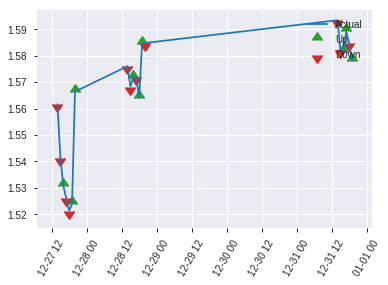


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22719029791593956
RMSE: 0.4766448341437674
LogLoss: 0.6482190740397235
Mean Per-Class Error: 0.33684210526315783
AUC: 0.6722105263157895
pr_auc: 0.5793220841955744
Gini: 0.34442105263157896
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38808104395866394: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   38   0.4      (38.0/95.0)
1      22   53   0.2933   (22.0/75.0)
Total  79   91   0.3529   (60.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388081     0.638554  90
max f2                       0.206176     0.809935  158
max f0point5                 0.479949     0.626741  70
max accuracy                 0.479949     0.670588  70
max precision                0.874824     1         0
max recall                   0.206176     1         158
max specificity              0.874824     1         0
max absolute_mcc             0.479949     0.328537  70
max min_per_class_accuracy   0.426568     0.653333  80
max mean_per_class_accuracy  0.479949     0.663158  70

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 44.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.834722           2.26667   2.26667            1                0.863617  1                           0.863617            0.0266667       0.0266667                  126.667   126.667
    2        0.0235294                   0.816073           0         1.13333            0                0.82557   0.5                         0.844594            0               0.0266667                  -100      13.3333
    3        0.0352941                   0.797637           1.13333   1.13333            0.5              0.800157  0.5                         0.829782            0.0133333       0.04                       13.3333   13.3333
    4        0.0411765                   0.778689           2.26667   1.29524            1                0.79585   0.571429                    0.824934            0.0133333       0.0533333                  126.667   29.5238
    5        0.0529412                   0.772361           2.26667   1.51111            1                0.773225  0.666667                    0.813443            0.0266667       0.08                       126.667   51.1111
    6        0.1                         0.740926           1.41667   1.46667            0.625            0.75762   0.647059                    0.787173            0.0666667       0.146667                   41.6667   46.6667
    7        0.152941                    0.696671           1.25926   1.39487            0.555556         0.719456  0.615385                    0.763733            0.0666667       0.213333                   25.9259   39.4872
    8        0.2                         0.659035           1.7       1.46667            0.75             0.677664  0.647059                    0.743481            0.08            0.293333                   70        46.6667
    9        0.3                         0.560633           1.06667   1.33333            0.470588         0.620844  0.588235                    0.702602            0.106667        0.4                        6.66667   33.3333
    10       0.4                         0.493628           1.6       1.4                0.705882         0.528577  0.617647                    0.659096            0.16            0.56                       60        40
    11       0.5                         0.410692           1.06667   1.33333            0.470588         0.452911  0.588235                    0.617859            0.106667        0.666667                   6.66667   33.3333
    12       0.6                         0.333266           0.666667  1.22222            0.294118         0.371712  0.539216                    0.576834            0.0666667       0.733333                   -33.3333  22.2222
    13       0.7                         0.281982           0.8       1.1619             0.352941         0.304616  0.512605                    0.537946            0.08            0.813333                   -20       16.1905
    14       0.8                         0.239175           0.533333  1.08333            0.235294         0.254536  0.477941                    0.50252             0.0533333       0.866667                   -46.6667  8.33333
    15       0.9                         0.218843           0.8       1.05185            0.352941         0.229134  0.464052                    0.472144            0.08            0.946667                   -20       5.18519
    16       1                           0.189146           0.533333  1                  0.235294         0.205891  0.441176                    0.445518            0.

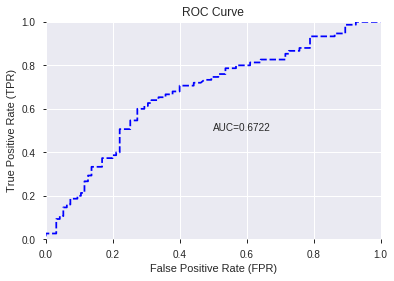

This function is available for GLM models only


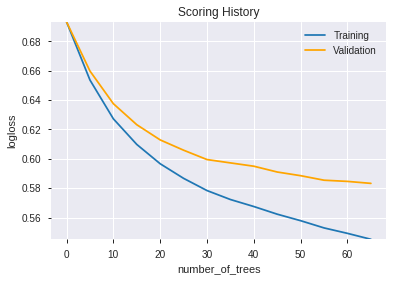

--2019-07-25 04:56:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_045547_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_045547_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'WILLR_8',
 'CCI_8',
 'ULTOSC',
 'STOCHRSI_fastk',
 'CCI_12',
 'WILLR_30',
 'STOCH_slowk',
 'ADOSC',
 'LINEARREG_ANGLE_8',
 'CCI_24',
 'MOM_8',
 'MINUS_DI_8',
 'CMO_8',
 'STOCHRSI_fastd',
 'WILLR_14',
 'CMO_24',
 'WILLR_24',
 'CCI_20',
 'CCI_30',
 'STOCH_slowd',
 'ROC_12',
 'CMO_12',
 'CMO_20',
 'WILLR_20',
 'ROC_8',
 'MINUS_DI_12',
 'CCI_14',
 'WILLR_12',
 'MINUS_DI_14',
 'CMO_14']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

53

['BBANDS_middleband_20_2_4',
 'BBANDS_middleband_20_5_4',
 'BBANDS_upperband_24_7_2',
 'MAVP_30_6',
 'ADX_8',
 'CCI_8',
 'DX_8',
 'aroonup_12',
 'CCI_12',
 'MFI_12',
 'PLUS_DM_12',
 'ROCP_12',
 'aroondown_14',
 'aroonup_14',
 'PLUS_DI_14',
 'ROCP_14',
 'ROCR_14',
 'WILLR_14',
 'PLUS_DM_20',
 'WILLR_20',
 'MACDFIX_24',
 'MOM_24',
 'PLUS_DI_24',
 'aroonup_30',
 'CCI_30',
 'DX_30',
 'MFI_30',
 'PLUS_DM_30',
 'WILLR_30',
 'APO',
 'MACD_hist',
 'MACDEXT',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'ULTOSC',
 'ATR_12',
 'TRANGE',
 'MEDPRICE',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'CDLBELTHOLD',
 'CDLDOJI',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'BETA_8',
 'LINEARREG_SLOPE_8',
 'VAR_8',
 'BETA_12',
 'CORREL_12',
 'LINEARREG_ANGLE_12',
 'BETA_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_045655_model_9  0.623298  0.676310              0.433333  0.490884  0.240967
1  DeepLearning_grid_1_AutoML_20190725_045655_model_8  0.600140  0.709917              0.468421  0.501659  0.251662
2  DeepLearning_grid_1_AutoML_20190725_045655_model_5  0.598035  0.786097              0.463158  0.510049  0.260150
3  DeepLearning_grid_1_AutoML_20190725_045655_model_2  0.587368  0.890246              0.460702  0.547648  0.299919
4  DeepLearning_grid_1_AutoML_20190725_045655_model_3  0.587228  0.999222              0.450175  0.557504  0.310810
5  DeepLearning_grid_1_AutoML_20190725_045655_model_4  0.579368  0.968927              0.463158  0.547887  0.300180
6  DeepLearning_grid_1_AutoML_20190725_045655_model_6  0.570105  0.777715              0.478947  0.517665  0.267977
7               DeepLearning_1_AutoML_20190725_045655  0.569544  0.858123              0.468421  0.537774  0.289201
8  DeepLearning_grid_1_AutoML_20190725_045655_model_1  0.555789  1.580890              0.416491  0.601139  0.361369
9  DeepLearning_grid_1_AutoML_20190725_045655_model_7  0.547789  0.959313              0.459298  0.572587  0.327855

variable  relative_importance  scaled_importance  percentage
0                CDLLONGLINE             1.000000           1.000000    0.047433
1               CDLENGULFING             0.613392           0.613392    0.029095
2                CDLBELTHOLD             0.578099           0.578099    0.027421
3                 aroonup_12             0.542048           0.542048    0.025711
4                     TRANGE             0.532891           0.532891    0.025276
5               STOCHF_fastk             0.515079           0.515079    0.024432
6                     ULTOSC             0.511818           0.511818    0.024277
7                 PLUS_DI_24             0.456976           0.456976    0.021676
8                      DX_30             0.454512           0.454512    0.021559
9                   WILLR_14             0.440747           0.440747    0.020906
10                     ADX_8             0.433463           0.433463    0.020560
11               HT_DCPERIOD             0.411938           0.411938    0.019539
12                   CDLDOJI             0.411657           0.411657    0.019526
13        LINEARREG_ANGLE_12             0.403228           0.403228    0.019126
14                 CORREL_12             0.399096           0.399096    0.018930
15                 MAVP_30_6             0.394085           0.394085    0.018692
16      HT_PHASOR_quadrature             0.391629           0.391629    0.018576
17  BBANDS_middleband_20_2_4             0.390993           0.390993    0.018546
18                  WILLR_30             0.389490           0.389490    0.018475
19                PLUS_DM_30             0.387622           0.387622    0.018386
20   BBANDS_upperband_24_7_2             0.386185           0.386185    0.018318
21                    BETA_8             0.379333           0.379333    0.017993
22                PLUS_DI_14             0.378414           0.378414    0.017949
23                aroonup_14             0.376309           0.376309    0.017849
24                aroonup_30             0.370082           0.370082    0.017554
25  BBANDS_middleband_20_5_4             0.367488           0.367488    0.017431
26                   BETA_12             0.364008           0.364008    0.017266
27                  MEDPRICE             0.361756           0.361756    0.017159
28                    ATR_12             0.360533           0.360533    0.017101
29                     VAR_8             0.359069           0.359069    0.017032
30                PLUS_DM_20             0.358394           0.358394    0.017000
31                      DX_8             0.358069           0.358069    0.016984
32               STOCH_slowd             0.355518           0.355518    0.016863
33                    CCI_30             0.343535           0.343535    0.016295
34            CDLSPINNINGTOP             0.343078           0.343078    0.016273
35                   ROCP_12             0.341685           0.341685    0.016207
36                    MOM_24             0.341599           0.341599    0.016203
37              STOCHF_fastd             0.341217           0.341217    0.016185
38                PLUS_DM_12             0.340933           0.340933    0.016171
39                MACDFIX_24             0.339698           0.339698    0.016113
40                     CCI_8             0.338600           0.338600    0.016061
41              aroondown_14             0.338571           0.338571    0.016059
42                   BETA_14             0.332093           0.332093    0.015752
43                 MACD_hist             0.331106           0.331106    0.015705
44                    MFI_12             0.329943           0.329943    0.015650
45                       APO             0.329504           0.329504    0.015629
46                   MACDEXT             0.329079           0.329079    0.015609
47                    MFI_30             0.327970           0.327970    0.015556
48                  WILLR_20             0.327778  

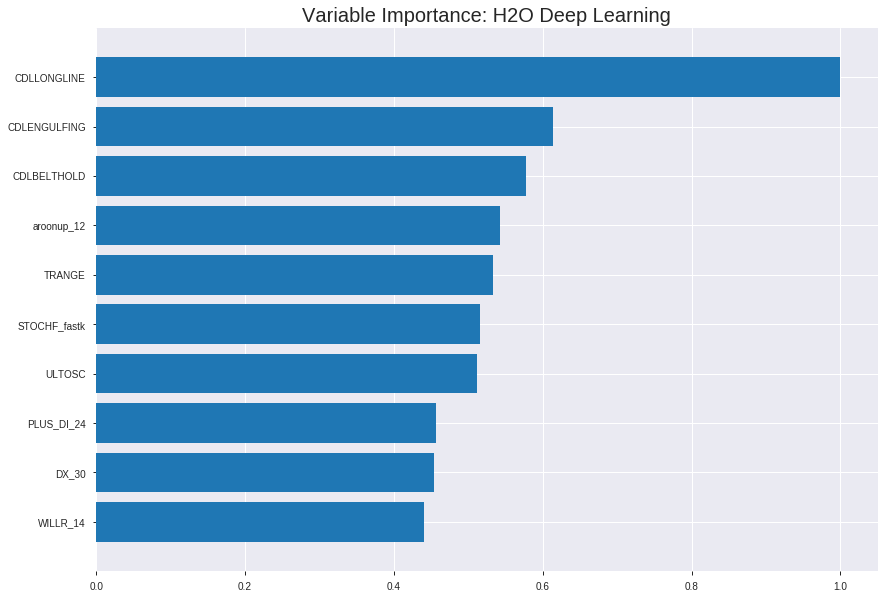

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_045655_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20037257677237807
RMSE: 0.447629955177687
LogLoss: 0.5846642927238582
Mean Per-Class Error: 0.3133656766165469
AUC: 0.7608439260909448
pr_auc: 0.7652883074122303
Gini: 0.5216878521818895
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40880791672230965: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      267  331  0.5535   (331.0/598.0)
1      70   517  0.1193   (70.0/587.0)
Total  337  848  0.3384   (401.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408808     0.720557  257
max f2                       0.305499     0.842326  312
max f0point5                 0.490773     0.69013   187
max accuracy                 0.477352     0.68692   197
max precision                0.931128     1         0
max recall                   0.121199     1         395
max specificity              0.931128     1         0
max absolute_mcc             0.477352     0.374043  197
max min_per_class_accuracy   0.468329     0.678024  204
max mean_per_class_accuracy  0.477352     0.686634  197

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 47.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.87099            2.01874   2.01874            1                0.890043  1                           0.890043            0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.849625           2.01874   2.01874            1                0.860813  1                           0.875428            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.835927           1.85051   1.96266            0.916667         0.841813  0.972222                    0.864223            0.0187394       0.0596252                  85.0511   96.2663
    4        0.0405063                   0.825936           2.01874   1.97668            1                0.83042   0.979167                    0.855772            0.0204429       0.0800681                  101.874   97.6682
    5        0.0506329                   0.811581           1.85051   1.95145            0.916667         0.81701   0.966667                    0.84802             0.0187394       0.0988075                  85.0511   95.1448
    6        0.100422                    0.742826           1.67658   1.81517            0.830508         0.771237  0.89916                     0.809951            0.0834753       0.182283                   67.658    81.5169
    7        0.150211                    0.681661           1.81344   1.8146             0.898305         0.713773  0.898876                    0.778072            0.0902896       0.272572                   81.3444   81.4597
    8        0.2                         0.631141           1.40285   1.7121             0.694915         0.65388   0.848101                    0.747155            0.0698467       0.342419                   40.2853   71.2095
    9        0.300422                    0.530201           1.18749   1.53674            0.588235         0.574672  0.761236                    0.689499            0.11925         0.46167                    18.7494   53.6737
    10       0.4                         0.493295           1.19756   1.4523             0.59322          0.509011  0.719409                    0.644568            0.11925         0.58092                    19.7557   45.23
    11       0.500422                    0.467081           1.01785   1.36512            0.504202         0.480689  0.676223                    0.611681            0.102215        0.683135                   1.78518   36.5117
    12       0.6                         0.447184           0.958046  1.29756            0.474576         0.457684  0.642757                    0.586123            0.0954003       0.778535                   -4.19542  29.7558
    13       0.699578                    0.414842           0.83829   1.23219            0.415254         0.432956  0.610374                    0.564321            0.0834753       0.86201                    -16.171   23.2186
    14       0.8                         0.341987           0.695532  1.16482            0.344538         0.387263  0.577004                    0.542096            0.0698467       0.931857                   -30.4468  16.4821
    15       0.899578                    0.226929           0.410591  1.08133            0.20339          0.282921  0.535647                    0.513407            0.0408859       0.972743                   -58.9409  8.13322
    16       1                           0.10086            0.271427  1                  0.134454         0.174409  0.495359                    0.479364           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2239737855707728
RMSE: 0.4732586877921765
LogLoss: 0.6382825877390224
Mean Per-Class Error: 0.31189192972632473
AUC: 0.7098061174494296
pr_auc: 0.6306442451819874
Gini: 0.4196122348988591
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4725886452963307: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  66   0.3626   (66.0/182.0)
1      41   116  0.2611   (41.0/157.0)
Total  157  182  0.3156   (107.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472589     0.684366  181
max f2                       0.35693      0.825243  298
max f0point5                 0.475752     0.656506  173
max accuracy                 0.475752     0.684366  173
max precision                0.815622     1         0
max recall                   0.202496     1         330
max specificity              0.815622     1         0
max absolute_mcc             0.472589     0.376216  181
max min_per_class_accuracy   0.479026     0.675159  164
max mean_per_class_accuracy  0.472589     0.688108  181

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 47.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.761331           1.61943   1.61943            0.75             0.793306  0.75                        0.793306            0.0191083       0.0191083                  61.9427   61.9427
    2        0.020649                    0.754345           0.719745  1.23385            0.333333         0.755662  0.571429                    0.777173            0.00636943      0.0254777                  -28.0255  23.3849
    3        0.0324484                   0.722184           1.61943   1.37406            0.75             0.740509  0.636364                    0.76384             0.0191083       0.044586                   61.9427   37.4059
    4        0.0412979                   0.704981           1.43949   1.38808            0.666667         0.711533  0.642857                    0.752632            0.0127389       0.0573248                  43.949    38.808
    5        0.0501475                   0.686168           1.43949   1.39715            0.666667         0.697483  0.647059                    0.7429              0.0127389       0.0700637                  43.949    39.7152
    6        0.100295                    0.57677            1.65118   1.52417            0.764706         0.62765   0.705882                    0.685275            0.0828025       0.152866                   65.118    52.4166
    7        0.150442                    0.544779           1.52417   1.52417            0.705882         0.554032  0.705882                    0.641527            0.0764331       0.229299                   52.4166   52.4166
    8        0.20059                     0.52503            1.27014   1.46066            0.588235         0.533827  0.676471                    0.614602            0.0636943       0.292994                   27.0139   46.0659
    9        0.300885                    0.505595           1.07962   1.33365            0.5              0.513959  0.617647                    0.581054            0.10828         0.401274                   7.96178   33.3646
    10       0.40118                     0.492652           1.58767   1.39715            0.735294         0.49853   0.647059                    0.560423            0.159236        0.56051                    58.7673   39.7152
    11       0.501475                    0.47748            1.27014   1.37175            0.588235         0.483844  0.635294                    0.545107            0.127389        0.687898                   27.0139   37.175
    12       0.59882                     0.461796           0.785177  1.2764             0.363636         0.469985  0.591133                    0.532895            0.0764331       0.764331                   -21.4823  27.6395
    13       0.699115                    0.445331           0.889097  1.22083            0.411765         0.454433  0.565401                    0.521639            0.089172        0.853503                   -11.0903  22.0834
    14       0.79941                     0.410096           0.635069  1.14734            0.294118         0.43166   0.531365                    0.51035             0.0636943       0.917197                   -36.4931  14.7343
    15       0.899705                    0.331775           0.571562  1.08316            0.264706         0.376289  0.501639                    0.495406            0.0573248       0.974522                   -42.8438  8.31576
    16       1                           0.112198           0.254028  1                  0.117647         0.242328  0.463127                    0.470023           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:03:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 05:03:22  2 min 14.565 sec  538 obs/sec       1         1             1185       0.606361         1.09396             -0.470823      0.706043        0.697886           2.01874          0.412658                         0.593539           1.03807               -0.41686         0.683838          0.611349             2.15924            0.368732
    2019-07-25 05:03:31  2 min 23.656 sec  793 obs/sec       7         7             8295       0.464374         0.620157            0.137355       0.735104        0.733597           2.01874          0.400844                         0.476393           0.645031              0.0872353        0.711101          0.644524             2.15924            0.410029
    2019-07-25 05:03:40  2 min 32.443 sec  903 obs/sec       14        14            16590      0.455934         0.600516            0.168424       0.747701        0.747142           2.01874          0.34346                          0.47515            0.640462              0.0919914        0.685028          0.620479             2.15924            0.371681
    2019-07-25 05:03:49  2 min 41.435 sec  983 obs/sec       22        22            26070      0.464047         0.618491            0.138568       0.733236        0.741408           2.01874          0.388186                         0.487911           0.66809               0.0425636        0.635788          0.600976             2.15924            0.483776
    2019-07-25 05:03:58  2 min 49.970 sec  1040 obs/sec      30        30            35550      0.44763          0.584664            0.198441       0.760844        0.765288           2.01874          0.338397                         0.473259           0.638283              0.0992059        0.709806          0.630644             1.61943            0.315634
    2019-07-25 05:04:07  2 min 58.793 sec  1096 obs/sec      39        39            46215      0.442176         0.571341            0.217853       0.777535        0.780724           2.01874          0.319831                         0.476726           0.643059              0.0859575        0.676052          0.613605             2.15924            0.40708
    2019-07-25 05:04:16  3 min  7.962 sec  1150 obs/sec      49        49            58065      0.437514         0.562158            0.234261       0.788182        0.791085           2.01874          0.324051                         0.477672           0.646684              0.0823259        0.695387          0.628076             1.61943            0.356932
    2019-07-25 05:04:17  3 min  8.859 sec  1150 obs/sec      49        49            58065      0.44763          0.584664            0.198441       0.760844        0.765288           2.01874          0.338397                         0.473259           0.638283              0.0992059        0.709806          0.630644             1.61943            0.315634

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLLONGLINE        1.0                    1.0                  0.04743262651030326
CDLENGULFING       0.6133919358253479     0.6133919358253479   0.029094790596435632
CDLBELTHOLD        0.5780985355377197     0.5780985355377197   0.027420731922313934
aroonup_12         0.542047917842865      0.542047917842865    0.02571075643772816
TRANGE             0.5328911542892456     0.5328911542892456   0.025276427092046173
---                ---                    ---                  ---
WILLR_20           0.3277775049209595     0.3277775049209595   0.01554734796939496
ROCR_14            0.3229488432407379     0.3229488432407379   0.015318311863372397
CCI_12             0.320128470659256      0.320128470659256    0.015184534184095063
LINEARREG_SLOPE_8  0.31793007254600525    0.31793007254600525  0.015080258387468288
ROCP_14            0.311219185590744      0.311219185590744    0.014761943392966515


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6411764705882353)

('F1', 0.6334841628959276)

('auc', 0.623298245614035)

('logloss', 0.6763099011389635)

('mean_per_class_error', 0.3687719298245614)

('rmse', 0.490884332860014)

('mse', 0.24096742824742098)

deeplearning prediction progress: |███████████████████████████████████████| 100%


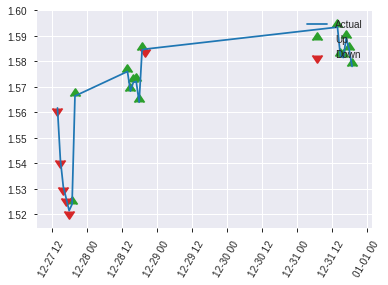


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24096742824742098
RMSE: 0.490884332860014
LogLoss: 0.6763099011389635
Mean Per-Class Error: 0.3687719298245614
AUC: 0.623298245614035
pr_auc: 0.5487313751724421
Gini: 0.24659649122807004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24464590266772593: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      19   76   0.8      (76.0/95.0)
1      5    70   0.0667   (5.0/75.0)
Total  24   146  0.4765   (81.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244646     0.633484  145
max f2                       0.141167     0.80819   163
max f0point5                 0.500184     0.590778  67
max accuracy                 0.500476     0.641176  65
max precision                0.785275     0.833333  5
max recall                   0.141167     1         163
max specificity              0.845656     0.989474  0
max absolute_mcc             0.500184     0.266008  67
max min_per_class_accuracy   0.487654     0.573333  78
max mean_per_class_accuracy  0.500184     0.631228  67

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 46.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.826323           1.13333   1.13333            0.5              0.842541  0.5                         0.842541            0.0133333       0.0133333                  13.3333   13.3333
    2        0.0235294                   0.799708           2.26667   1.7                1                0.810459  0.75                        0.8265              0.0266667       0.04                       126.667   70
    3        0.0352941                   0.78427            2.26667   1.88889            1                0.791858  0.833333                    0.814953            0.0266667       0.0666667                  126.667   88.8889
    4        0.0411765                   0.76684            0         1.61905            0                0.770916  0.714286                    0.808662            0               0.0666667                  -100      61.9048
    5        0.0529412                   0.729463           1.13333   1.51111            0.5              0.751484  0.666667                    0.795956            0.0133333       0.08                       13.3333   51.1111
    6        0.1                         0.690769           1.41667   1.46667            0.625            0.706867  0.647059                    0.754032            0.0666667       0.146667                   41.6667   46.6667
    7        0.152941                    0.62945            1.00741   1.30769            0.444444         0.656156  0.576923                    0.720152            0.0533333       0.2                        0.740741  30.7692
    8        0.2                         0.604705           1.13333   1.26667            0.5              0.620863  0.558824                    0.69679             0.0533333       0.253333                   13.3333   26.6667
    9        0.3                         0.535017           1.46667   1.33333            0.647059         0.566079  0.588235                    0.653219            0.146667        0.4                        46.6667   33.3333
    10       0.4                         0.498649           1.46667   1.36667            0.647059         0.511432  0.602941                    0.617773            0.146667        0.546667                   46.6667   36.6667
    11       0.5                         0.47838            0.266667  1.14667            0.117647         0.489017  0.505882                    0.592021            0.0266667       0.573333                   -73.3333  14.6667
    12       0.6                         0.456477           1.06667   1.13333            0.470588         0.468751  0.5                         0.571476            0.106667        0.68                       6.66667   13.3333
    13       0.7                         0.395979           1.06667   1.12381            0.470588         0.430026  0.495798                    0.551269            0.106667        0.786667                   6.66667   12.381
    14       0.8                         0.304278           0.666667  1.06667            0.294118         0.347853  0.470588                    0.525842            0.0666667       0.853333                   -33.3333  6.66667
    15       0.9                         0.206752           0.933333  1.05185            0.411765         0.247347  0.464052                    0.494898            0.0933333       0.946667                   -6.66667  5.18519
    16       1                           0.0982217          0.533333  1                  0.235294         0.150229  0.441176                    0.460431            0.0

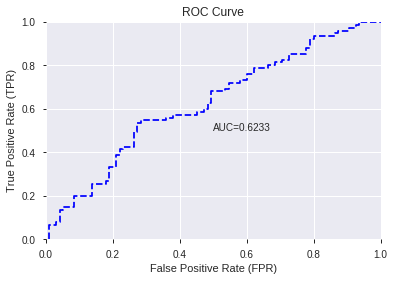

This function is available for GLM models only


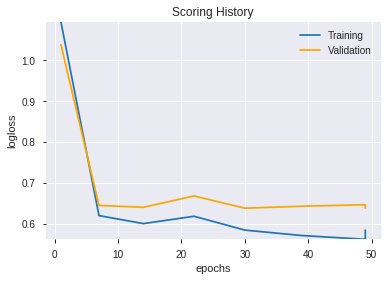

--2019-07-25 05:04:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_045655_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_045655_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLLONGLINE',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'aroonup_12',
 'TRANGE',
 'STOCHF_fastk',
 'ULTOSC',
 'PLUS_DI_24',
 'DX_30',
 'WILLR_14',
 'ADX_8',
 'HT_DCPERIOD',
 'CDLDOJI',
 'LINEARREG_ANGLE_12',
 'CORREL_12',
 'MAVP_30_6',
 'HT_PHASOR_quadrature',
 'BBANDS_middleband_20_2_4',
 'WILLR_30',
 'PLUS_DM_30',
 'BBANDS_upperband_24_7_2',
 'BETA_8',
 'PLUS_DI_14',
 'aroonup_14',
 'aroonup_30',
 'BBANDS_middleband_20_5_4',
 'BETA_12',
 'MEDPRICE',
 'ATR_12',
 'VAR_8',
 'PLUS_DM_20',
 'DX_8',
 'STOCH_slowd',
 'CCI_30',
 'CDLSPINNINGTOP',
 'ROCP_12',
 'MOM_24',
 'STOCHF_fastd',
 'PLUS_DM_12',
 'MACDFIX_24',
 'CCI_8',
 'aroondown_14',
 'BETA_14',
 'MACD_hist',
 'MFI_12',
 'APO',
 'MACDEXT',
 'MFI_30',
 'WILLR_20',
 'ROCR_14',
 'CCI_12',
 'LINEARREG_SLOPE_8',
 'ROCP_14']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_050430_model_1  0.636912  0.664953              0.443509  0.485741  0.235945

variable  relative_importance  scaled_importance  percentage
0                CDLLONGLINE             0.259034           1.000000    0.098861
1               STOCHF_fastk             0.223513           0.862870    0.085304
2                   WILLR_14             0.134117           0.517757    0.051186
3               CDLENGULFING             0.132436           0.511268    0.050544
4                     ULTOSC             0.131419           0.507343    0.050156
5                CDLBELTHOLD             0.109609           0.423145    0.041833
6                     TRANGE             0.102010           0.393810    0.038932
7                 aroonup_12             0.093925           0.362595    0.035846
8                   WILLR_30             0.091814           0.354445    0.035041
9         LINEARREG_ANGLE_12             0.087251           0.336832    0.033300
10                  WILLR_20             0.076925           0.296970    0.029359
11                      DX_8             0.071330           0.275368    0.027223
12                    BETA_8             0.068686           0.265161    0.026214
13                     DX_30             0.064426           0.248716    0.024588
14                aroonup_14             0.063708           0.245945    0.024314
15                PLUS_DI_14             0.063340           0.244524    0.024174
16               HT_DCPERIOD             0.057757           0.222972    0.022043
17                PLUS_DI_24             0.056575           0.218408    0.021592
18                 MACD_hist             0.054567           0.210654    0.020825
19                    ATR_12             0.052655           0.203274    0.020096
20                   BETA_14             0.051180           0.197581    0.019533
21                   ROCP_12             0.049162           0.189789    0.018763
22      HT_PHASOR_quadrature             0.044939           0.173486    0.017151
23                    MFI_12             0.044766           0.172820    0.017085
24                PLUS_DM_30             0.036427           0.140625    0.013902
25              STOCHF_fastd             0.030446           0.117537    0.011620
26            CDLSPINNINGTOP             0.029276           0.113019    0.011173
27                    CCI_30             0.029261           0.112960    0.011167
28                    MFI_30             0.029078           0.112254    0.011098
29                aroonup_30             0.027002           0.104242    0.010305
30                     ADX_8             0.024599           0.094965    0.009388
31                    MOM_24             0.023852           0.092080    0.009103
32                     CCI_8             0.019302           0.074515    0.007367
33                PLUS_DM_20             0.019106           0.073758    0.007292
34   BBANDS_upperband_24_7_2             0.018851           0.072773    0.007194
35                PLUS_DM_12             0.014711           0.056791    0.005614
36              aroondown_14             0.013154           0.050782    0.005020
37  BBANDS_middleband_20_5_4             0.012699           0.049023    0.004846
38               STOCH_slowd             0.012492           0.048227    0.004768
39                     VAR_8             0.012055           0.046538    0.004601
40                 CORREL_12             0.011730           0.045285    0.004477
41                MACDFIX_24             0.010950           0.042273    0.004179
42                   CDLDOJI             0.010687           0.041255    0.004079
43  BBANDS_middleband_20_2_4             0.009605           0.037080    0.003666
44                 MAVP_30_6             0.009089           0.035088    0.003469
45                   BETA_12             0.007382           0.028498    0.002817
46         LINEARREG_SLOPE_8             0.005289           0.020420    0.002019
47                       APO             0.005284           0.020398    0.002017
48                   MACDEXT             0.005244  

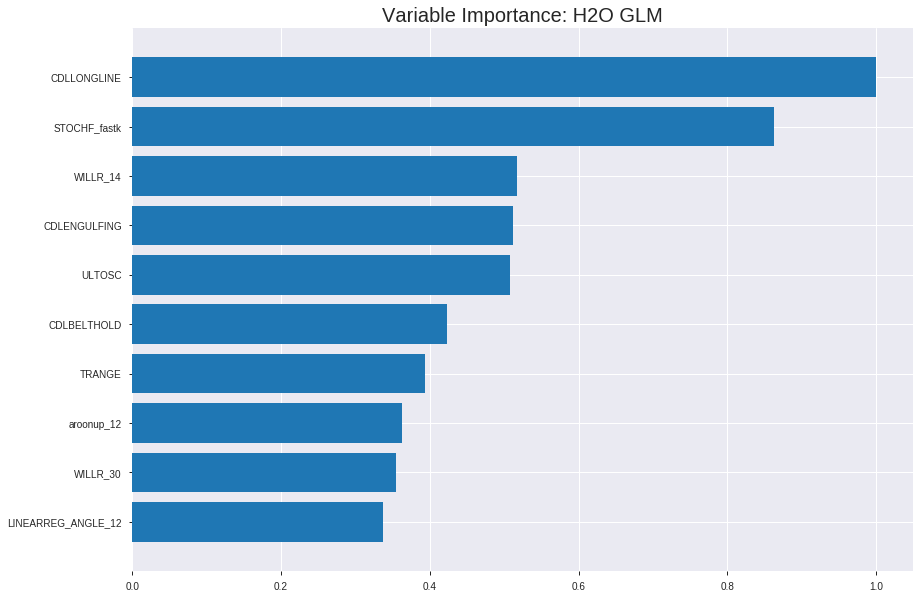

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_050430_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2104877260650868
RMSE: 0.45878941363667797
LogLoss: 0.609061427221837
Null degrees of freedom: 1184
Residual degrees of freedom: 1131
Null deviance: 1642.6567067559345
Residual deviance: 1443.4755825157536
AIC: 1551.4755825157536
AUC: 0.737324300764046
pr_auc: 0.7311718645807456
Gini: 0.47464860152809196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39485087408279007: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      237  361  0.6037   (361.0/598.0)
1      61   526  0.1039   (61.0/587.0)
Total  298  887  0.3561   (422.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394851     0.713704  269
max f2                       0.307821     0.835544  325
max f0point5                 0.518652     0.675136  180
max accuracy                 0.508005     0.675949  188
max precision                0.872853     1         0
max recall                   0.121676     1         396
max specificity              0.872853     1         0
max absolute_mcc             0.508005     0.351794  188
max min_per_class_accuracy   0.505068     0.668896  190
max mean_per_class_accuracy  0.508005     0.675859  188

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.817244           2.01874   2.01874            1                0.83951   1                           0.83951             0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.802973           2.01874   2.01874            1                0.809917  1                           0.824713            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.786756           1.68228   1.90659            0.833333         0.795359  0.944444                    0.814929            0.0170358       0.0579216                  68.2283   90.6587
    4        0.0405063                   0.773918           1.34583   1.7664             0.666667         0.781539  0.875                       0.806581            0.0136286       0.0715503                  34.5826   76.6397
    5        0.0506329                   0.756592           1.85051   1.78322            0.916667         0.766462  0.883333                    0.798557            0.0187394       0.0902896                  85.0511   78.322
    6        0.100422                    0.695721           1.60815   1.69642            0.79661          0.722785  0.840336                    0.76099             0.0800681       0.170358                   60.8148   69.642
    7        0.150211                    0.636714           1.67658   1.68984            0.830508         0.662059  0.837079                    0.728198            0.0834753       0.253833                   67.658    68.9844
    8        0.2                         0.613896           1.36864   1.60988            0.677966         0.62426   0.797468                    0.702323            0.0681431       0.321976                   36.8637   60.9881
    9        0.300422                    0.574699           1.28928   1.50271            0.638655         0.593391  0.744382                    0.66591             0.129472        0.451448                   28.9279   50.2713
    10       0.4                         0.543236           1.09491   1.40119            0.542373         0.558171  0.694093                    0.639089            0.109029        0.560477                   9.49095   40.1193
    11       0.500422                    0.503258           1.10267   1.34129            0.546218         0.522754  0.664418                    0.615744            0.110733        0.67121                    10.2673   34.1287
    12       0.6                         0.466801           0.872506  1.26349            0.432203         0.486131  0.625879                    0.594233            0.0868825       0.758092                   -12.7494  26.3487
    13       0.699578                    0.422001           0.940938  1.21758            0.466102         0.445299  0.603136                    0.573033            0.0936968       0.851789                   -5.90622  21.7575
    14       0.8                         0.364291           0.695532  1.15204            0.344538         0.393724  0.570675                    0.550525            0.0698467       0.921635                   -30.4468  15.2044
    15       0.899578                    0.289987           0.479023  1.07754            0.237288         0.332767  0.533771                    0.526421            0.0477002       0.969336                   -52.0977  7.75447
    16       1                           0.0793247          0.305356  1                  0.151261         0.217108  0.495359                    0.495359           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.22252531961567043
RMSE: 0.4717258945782714
LogLoss: 0.6353942964168547
Null degrees of freedom: 338
Residual degrees of freedom: 285
Null deviance: 469.5188524558861
Residual deviance: 430.7973329706275
AIC: 538.7973329706275
AUC: 0.6945824875761182
pr_auc: 0.6237565447499563
Gini: 0.38916497515223636
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40613151337164166: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      63   119  0.6538   (119.0/182.0)
1      11   146  0.0701   (11.0/157.0)
Total  74   265  0.3835   (130.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406132     0.691943  264
max f2                       0.356363     0.823337  288
max f0point5                 0.502343     0.629478  204
max accuracy                 0.502343     0.657817  204
max precision                0.864949     1         0
max recall                   0.215259     1         330
max specificity              0.864949     1         0
max absolute_mcc             0.502343     0.339513  204
max min_per_class_accuracy   0.537071     0.636943  165
max mean_per_class_accuracy  0.502343     0.666445  204

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 51.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.820426           2.15924   2.15924            1                0.849337  1                           0.849337            0.0254777       0.0254777                  115.924   115.924
    2        0.020649                    0.802646           1.43949   1.85077            0.666667         0.810623  0.857143                    0.832745            0.0127389       0.0382166                  43.949    85.0773
    3        0.0324484                   0.789912           1.61943   1.76665            0.75             0.793155  0.818182                    0.818349            0.0191083       0.0573248                  61.9427   76.6647
    4        0.0412979                   0.778567           1.43949   1.69654            0.666667         0.786759  0.785714                    0.81158             0.0127389       0.0700637                  43.949    69.6542
    5        0.0501475                   0.766403           0.719745  1.52417            0.333333         0.774782  0.705882                    0.805086            0.00636943      0.0764331                  -28.0255  52.4166
    6        0.100295                    0.693701           1.39715   1.46066            0.647059         0.731087  0.676471                    0.768086            0.0700637       0.146497                   39.7152   46.0659
    7        0.150442                    0.651573           1.39715   1.43949            0.647059         0.667943  0.666667                    0.734705            0.0700637       0.216561                   39.7152   43.949
    8        0.20059                     0.630124           1.01611   1.33365            0.470588         0.639593  0.617647                    0.710927            0.0509554       0.267516                   1.61109   33.3646
    9        0.300885                    0.593014           1.52417   1.39715            0.705882         0.609422  0.647059                    0.677092            0.152866        0.420382                   52.4166   39.7152
    10       0.40118                     0.565147           1.07962   1.31777            0.5              0.57714   0.610294                    0.652104            0.10828         0.528662                   7.96178   31.7769
    11       0.501475                    0.531038           1.14312   1.28284            0.529412         0.548421  0.594118                    0.631367            0.11465         0.643312                   14.3125   28.284
    12       0.59882                     0.503605           1.30863   1.28703            0.606061         0.516539  0.596059                    0.612701            0.127389        0.770701                   30.8628   28.7032
    13       0.699115                    0.449894           0.82559   1.22083            0.382353         0.480943  0.565401                    0.593799            0.0828025       0.853503                   -17.441   22.0834
    14       0.79941                     0.391527           0.762083  1.16328            0.352941         0.423163  0.538745                    0.572391            0.0764331       0.929936                   -23.7917  16.3278
    15       0.899705                    0.300152           0.444549  1.08316            0.205882         0.349799  0.501639                    0.547577            0.044586        0.974522                   -55.5451  8.31576
    16       1                           0.143356           0.254028  1                  0.117647         0.239256  0.463127                    0.516654           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 05:04:30  0.000 sec   2            15        54            1.36952           1.37267
    2019-07-25 05:04:30  0.010 sec   4            9.4       54            1.36216           1.36713
    2019-07-25 05:04:30  0.019 sec   6            5.8       54            1.35261           1.35976
    2019-07-25 05:04:30  0.033 sec   8            3.6       54            1.3406            1.35025
    2019-07-25 05:04:30  0.043 sec   10           2.3       54            1.326             1.33842
    2019-07-25 05:04:30  0.051 sec   12           1.4       54            1.30895           1.32452
    2019-07-25 05:04:30  0.060 sec   14           0.87      54            1.29015           1.30953
    2019-07-25 05:04:30  0.068 sec   16           0.54      54            1.27069           1.29507
    2019-07-25 05:04:30  0.076 sec   18           0.34      54            1.25171           1.28292
    2019-07-25 05:04:30  0.084 sec   20           0.21      54            1.23404           1.27453
    2019-07-25 05:04:30  0.094 sec   22           0.13      54            1.21812           1.27079
    2019-07-25 05:04:30  0.102 sec   24           0.08      54            1.20414           1.27181
    2019-07-25 05:04:30  0.111 sec   26           0.05      54            1.19211           1.27697
    2019-07-25 05:04:30  0.119 sec   28           0.031     54            1.18182           1.28502
    2019-07-25 05:04:30  0.131 sec   30           0.019     54            1.17297           1.29461
    2019-07-25 05:04:30  0.142 sec   32           0.012     54            1.16524           1.30515

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6529411764705882)

('F1', 0.6379310344827586)

('auc', 0.6369122807017544)

('logloss', 0.6649526124020525)

('mean_per_class_error', 0.35684210526315785)

('rmse', 0.48574143899788347)

('mse', 0.23594474555973452)

glm prediction progress: |████████████████████████████████████████████████| 100%


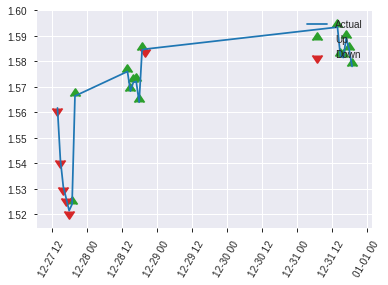


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23594474555973452
RMSE: 0.48574143899788347
LogLoss: 0.6649526124020525
Null degrees of freedom: 169
Residual degrees of freedom: 116
Null deviance: 235.31337198870415
Residual deviance: 226.08388821669783
AIC: 334.0838882166978
AUC: 0.6369122807017544
pr_auc: 0.5477281334083737
Gini: 0.27382456140350886
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20480811934061777: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      12   83   0.8737   (83.0/95.0)
1      1    74   0.0133   (1.0/75.0)
Total  13   157  0.4941   (84.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.204808     0.637931  156
max f2                       0.204808     0.809628  156
max f0point5                 0.497584     0.605187  67
max accuracy                 0.497584     0.652941  67
max precision                0.80507      1         0
max recall                   0.143648     1         167
max specificity              0.80507      1         0
max absolute_mcc             0.497584     0.290191  67
max min_per_class_accuracy   0.46486      0.586667  82
max mean_per_class_accuracy  0.497584     0.643158  67

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 44.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.774351           1.13333   1.13333            0.5              0.795383  0.5                         0.795383            0.0133333       0.0133333                  13.3333   13.3333
    2        0.0235294                   0.750163           1.13333   1.13333            0.5              0.759814  0.5                         0.777598            0.0133333       0.0266667                  13.3333   13.3333
    3        0.0352941                   0.748844           1.13333   1.13333            0.5              0.749467  0.5                         0.768221            0.0133333       0.04                       13.3333   13.3333
    4        0.0411765                   0.729025           2.26667   1.29524            1                0.745261  0.571429                    0.764941            0.0133333       0.0533333                  126.667   29.5238
    5        0.0529412                   0.706083           2.26667   1.51111            1                0.723237  0.666667                    0.755674            0.0266667       0.08                       126.667   51.1111
    6        0.1                         0.630622           1.13333   1.33333            0.5              0.657289  0.588235                    0.709375            0.0533333       0.133333                   13.3333   33.3333
    7        0.152941                    0.590492           1.51111   1.39487            0.666667         0.608743  0.615385                    0.674541            0.08            0.213333                   51.1111   39.4872
    8        0.2                         0.566133           1.13333   1.33333            0.5              0.580169  0.588235                    0.652336            0.0533333       0.266667                   13.3333   33.3333
    9        0.3                         0.535312           1.46667   1.37778            0.647059         0.551217  0.607843                    0.61863             0.146667        0.413333                   46.6667   37.7778
    10       0.4                         0.497436           1.46667   1.4                0.647059         0.516429  0.617647                    0.593079            0.146667        0.56                       46.6667   40
    11       0.5                         0.456964           0.266667  1.17333            0.117647         0.476077  0.517647                    0.569679            0.0266667       0.586667                   -73.3333  17.3333
    12       0.6                         0.410339           0.933333  1.13333            0.411765         0.432369  0.5                         0.546794            0.0933333       0.68                       -6.66667  13.3333
    13       0.7                         0.372424           1.2       1.14286            0.529412         0.39287   0.504202                    0.524805            0.12            0.8                        20        14.2857
    14       0.8                         0.30424            0.533333  1.06667            0.235294         0.345163  0.470588                    0.50235             0.0533333       0.853333                   -46.6667  6.66667
    15       0.9                         0.221243           1.06667   1.06667            0.470588         0.25064   0.470588                    0.474382            0.106667        0.96                       6.66667   6.66667
    16       1                           0.12943            0.4       1                  0.176471         0.176202  0.441176                    0.444564            0.

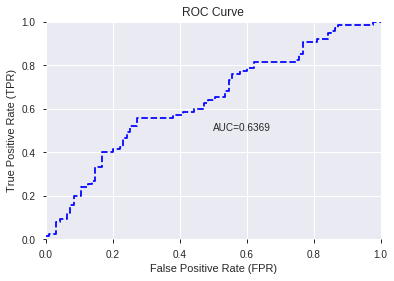

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


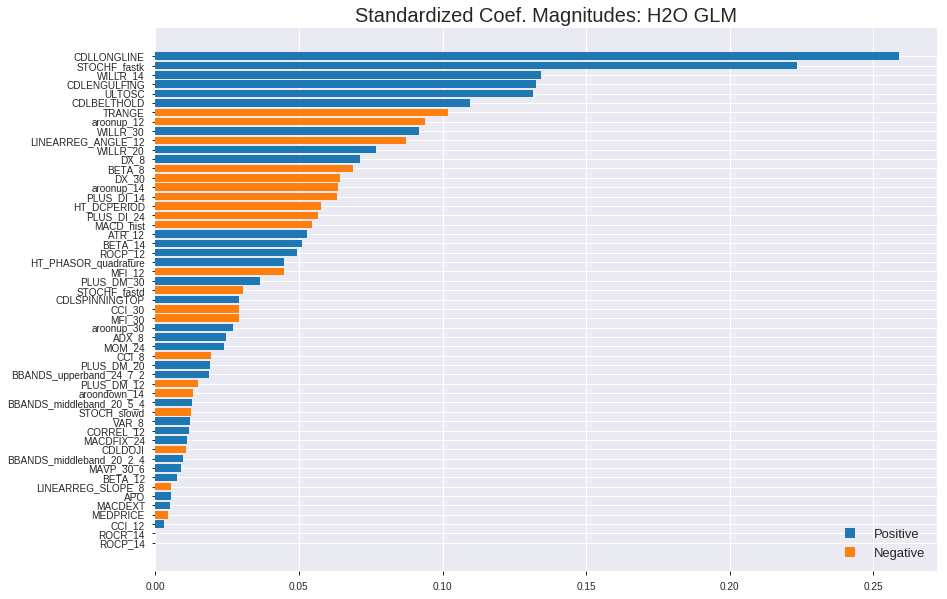

'log_likelihood'
--2019-07-25 05:04:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_050430_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_050430_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLLONGLINE',
 'STOCHF_fastk',
 'WILLR_14',
 'CDLENGULFING',
 'ULTOSC',
 'CDLBELTHOLD',
 'TRANGE',
 'aroonup_12',
 'WILLR_30',
 'LINEARREG_ANGLE_12',
 'WILLR_20',
 'DX_8',
 'BETA_8',
 'DX_30',
 'aroonup_14',
 'PLUS_DI_14',
 'HT_DCPERIOD',
 'PLUS_DI_24',
 'MACD_hist',
 'ATR_12',
 'BETA_14',
 'ROCP_12',
 'HT_PHASOR_quadrature',
 'MFI_12',
 'PLUS_DM_30',
 'STOCHF_fastd',
 'CDLSPINNINGTOP',
 'CCI_30',
 'MFI_30',
 'aroonup_30',
 'ADX_8',
 'MOM_24',
 'CCI_8',
 'PLUS_DM_20',
 'BBANDS_upperband_24_7_2',
 'PLUS_DM_12',
 'aroondown_14',
 'BBANDS_middleband_20_5_4',
 'STOCH_slowd',
 'VAR_8',
 'CORREL_12',
 'MACDFIX_24',
 'CDLDOJI',
 'BBANDS_middleband_20_2_4',
 'MAVP_30_6',
 'BETA_12',
 'LINEARREG_SLOPE_8',
 'APO',
 'MACDEXT',
 'MEDPRICE',
 'CCI_12',
 'ROCR_14',
 'ROCP_14']

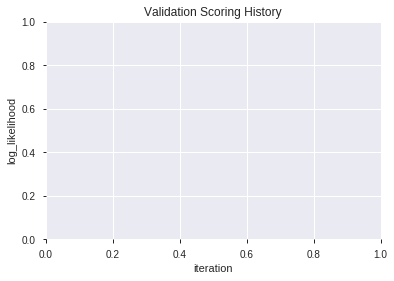

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_050445_model_4  0.633263  0.664499              0.446316  0.484758  0.234990
1               XGBoost_2_AutoML_20190725_050445  0.627368  0.686264              0.424211  0.492912  0.242962
2  XGBoost_grid_1_AutoML_20190725_050445_model_1  0.625965  0.694316              0.411228  0.494168  0.244202
3               XGBoost_3_AutoML_20190725_050445  0.616421  0.697187              0.438596  0.496602  0.246613
4               XGBoost_1_AutoML_20190725_050445  0.614035  0.695617              0.437193  0.497678  0.247683
5  XGBoost_grid_1_AutoML_20190725_050445_model_6  0.611649  0.694248              0.435789  0.496459  0.246472
6  XGBoost_grid_1_AutoML_20190725_050445_model_5  0.610526  0.727216              0.446316  0.506110  0.256148
7  XGBoost_grid_1_AutoML_20190725_050445_model_2  0.605474  0.691805              0.414035  0.496789  0.246799
8  XGBoost_grid_1_AutoML_20190725_050445_model_3  0.603789  0.703887              0.457895  0.499207  0.249208
9  XGBoost_grid_1_AutoML_20190725_050445_model_7  0.587228  0.721156              0.464561  0.507089  0.257140

variable  relative_importance  scaled_importance  percentage
0               STOCHF_fastk          1153.169556           1.000000    0.381197
1                      CCI_8           145.084610           0.125814    0.047960
2                     TRANGE           126.723038           0.109891    0.041890
3                   WILLR_14           112.545525           0.097597    0.037204
4               STOCHF_fastd           103.610596           0.089849    0.034250
5                   WILLR_30           102.741142           0.089095    0.033963
6       HT_PHASOR_quadrature            93.791870           0.081334    0.031004
7                     ULTOSC            92.708031           0.080394    0.030646
8                HT_DCPERIOD            87.715652           0.076065    0.028996
9                 aroonup_12            84.591927           0.073356    0.027963
10                    CCI_12            79.265999           0.068738    0.026203
11        LINEARREG_ANGLE_12            69.889145           0.060606    0.023103
12                    BETA_8            65.866577           0.057118    0.021773
13                     DX_30            65.033310           0.056395    0.021498
14                    MFI_12            55.790035           0.048380    0.018442
15                      DX_8            49.567924           0.042984    0.016385
16                PLUS_DM_30            38.886734           0.033722    0.012855
17                  WILLR_20            38.044533           0.032991    0.012576
18                 CORREL_12            37.822609           0.032799    0.012503
19               STOCH_slowd            34.237617           0.029690    0.011318
20                aroonup_14            32.693115           0.028351    0.010807
21                   BETA_12            32.129005           0.027861    0.010621
22                PLUS_DI_24            27.537167           0.023880    0.009103
23                    ATR_12            27.398037           0.023759    0.009057
24                     ADX_8            27.015522           0.023427    0.008930
25                   ROCP_12            25.746094           0.022326    0.008511
26                 MACD_hist            24.702604           0.021421    0.008166
27   BBANDS_upperband_24_7_2            21.717808           0.018833    0.007179
28  BBANDS_middleband_20_5_4            19.604218           0.017000    0.006480
29              aroondown_14            17.935139           0.015553    0.005929
30                   ROCP_14            17.070795           0.014803    0.005643
31                PLUS_DI_14            15.209191           0.013189    0.005028
32                       APO            13.726103           0.011903    0.004537
33                MACDFIX_24            13.203539           0.011450    0.004365
34                aroonup_30            12.284900           0.010653    0.004061
35                    MOM_24            11.819513           0.010250    0.003907
36                    CCI_30            11.712877           0.010157    0.003872
37         LINEARREG_SLOPE_8             8.947116           0.007759    0.002958
38                     VAR_8             8.106989           0.007030    0.002680
39                  MEDPRICE             7.871483           0.006826    0.002602
40                PLUS_DM_20             6.604176           0.005727    0.002183
41                    MFI_30             5.006227           0.004341    0.001655

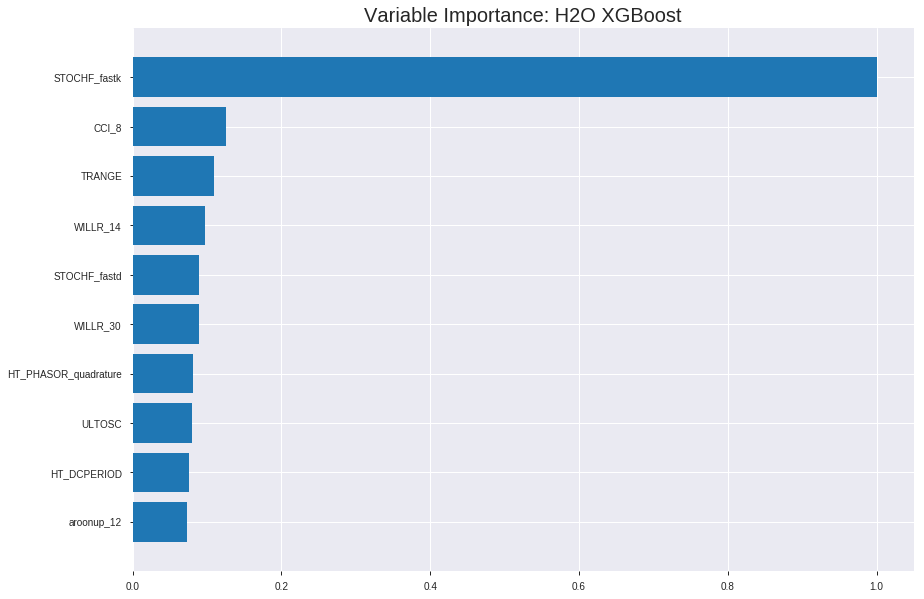

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_050445_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18883549829553986
RMSE: 0.434552066265413
LogLoss: 0.5623825203253346
Mean Per-Class Error: 0.2562274589346658
AUC: 0.8135935799627378
pr_auc: 0.8069765342890816
Gini: 0.6271871599254757
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39815017580986023: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      309  289  0.4833   (289.0/598.0)
1      56   531  0.0954   (56.0/587.0)
Total  365  820  0.2911   (345.0/1185.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39815      0.754797  273
max f2                       0.359578     0.85126   300
max f0point5                 0.508759     0.753271  193
max accuracy                 0.508759     0.744304  193
max precision                0.855527     1         0
max recall                   0.205599     1         392
max specificity              0.855527     1         0
max absolute_mcc             0.508759     0.491012  193
max min_per_class_accuracy   0.483493     0.730769  213
max mean_per_class_accuracy  0.508759     0.743773  193

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 49.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101266                   0.832571           2.01874   2.01874            1                0.84316   1                           0.84316             0.0204429       0.0204429                  101.874   101.874
    2        0.0202532                   0.81982            2.01874   2.01874            1                0.824762  1                           0.833961            0.0204429       0.0408859                  101.874   101.874
    3        0.0303797                   0.814834           2.01874   2.01874            1                0.81782   1                           0.828581            0.0204429       0.0613288                  101.874   101.874
    4        0.0405063                   0.806945           2.01874   2.01874            1                0.810612  1                           0.824088            0.0204429       0.0817717                  101.874   101.874
    5        0.0506329                   0.797967           1.85051   1.98509            0.916667         0.802315  0.983333                    0.819734            0.0187394       0.100511                   85.0511   98.5094
    6        0.100422                    0.761432           1.77923   1.88303            0.881356         0.784236  0.932773                    0.802134            0.088586        0.189097                   77.9228   88.3026
    7        0.150211                    0.69927            1.5055    1.75789            0.745763         0.739275  0.870787                    0.781299            0.0749574       0.264055                   50.5501   75.7891
    8        0.2                         0.645155           1.67658   1.73765            0.830508         0.671079  0.860759                    0.75386             0.0834753       0.34753                    67.658    73.7649
    9        0.300422                    0.573095           1.49285   1.65582            0.739496         0.604016  0.820225                    0.703772            0.149915        0.497445                   49.2849   65.582
    10       0.4                         0.522855           1.36864   1.58433            0.677966         0.545482  0.78481                     0.664366            0.136286        0.633731                   36.8637   58.4327
    11       0.500422                    0.482128           0.983923  1.46384            0.487395         0.503546  0.725126                    0.632094            0.0988075       0.732538                   -1.60766  46.3841
    12       0.6                         0.444168           0.958046  1.3799             0.474576         0.462996  0.683544                    0.60403             0.0954003       0.827939                   -4.19542  37.9898
    13       0.699578                    0.392064           0.804074  1.29793            0.398305         0.420188  0.642943                    0.577862            0.0800681       0.908007                   -19.5926  29.7935
    14       0.8                         0.341471           0.458033  1.1925             0.226891         0.366555  0.590717                    0.551337            0.0459966       0.954003                   -54.1967  19.2504
    15       0.899578                    0.284286           0.325051  1.09648            0.161017         0.310444  0.543152                    0.524671            0.032368        0.986371                   -67.4949  9.64823
    16       1                           0.177003           0.135714  1                  0.0672269        0.244991  0.495359                    0.496585          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21980978184960767
RMSE: 0.46883875890289584
LogLoss: 0.628479332775177
Mean Per-Class Error: 0.3491110800027998
AUC: 0.6906278434940856
pr_auc: 0.659646886568697
Gini: 0.38125568698817114
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3237914741039276: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      54   128  0.7033   (128.0/182.0)
1      13   144  0.0828   (13.0/157.0)
Total  67   272  0.4159   (141.0/339.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323791     0.671329  271
max f2                       0.268351     0.821772  308
max f0point5                 0.48765      0.62422   160
max accuracy                 0.48765      0.651917  160
max precision                0.83579      1         0
max recall                   0.233879     1         327
max specificity              0.83579      1         0
max absolute_mcc             0.48765      0.301335  160
max min_per_class_accuracy   0.486479     0.643312  164
max mean_per_class_accuracy  0.48765      0.650889  160

Gains/Lift Table: Avg response rate: 46.31 %, avg score: 46.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117994                   0.820814           1.61943   1.61943            0.75             0.828483  0.75                        0.828483            0.0191083       0.0191083                  61.9427   61.9427
    2        0.020649                    0.806113           2.15924   1.85077            1                0.817327  0.857143                    0.823702            0.0191083       0.0382166                  115.924   85.0773
    3        0.0324484                   0.796544           2.15924   1.96294            1                0.800283  0.909091                    0.815186            0.0254777       0.0636943                  115.924   96.2942
    4        0.0412979                   0.78329            2.15924   2.005              1                0.787486  0.928571                    0.80925             0.0191083       0.0828025                  115.924   100.5
    5        0.0501475                   0.74965            2.15924   2.03222            1                0.779022  0.941176                    0.803916            0.0191083       0.101911                   115.924   103.222
    6        0.100295                    0.640092           1.52417   1.77819            0.705882         0.68932   0.823529                    0.746618            0.0764331       0.178344                   52.4166   77.8194
    7        0.150442                    0.602159           1.27014   1.60884            0.588235         0.618675  0.745098                    0.70397             0.0636943       0.242038                   27.0139   60.8842
    8        0.20059                     0.567955           1.01611   1.46066            0.470588         0.58449   0.676471                    0.6741              0.0509554       0.292994                   1.61109   46.0659
    9        0.300885                    0.533459           1.46066   1.46066            0.676471         0.547793  0.676471                    0.631998            0.146497        0.43949                    46.0659   46.0659
    10       0.40118                     0.509727           1.01611   1.34952            0.470588         0.521464  0.625                       0.604364            0.101911        0.541401                   1.61109   34.9522
    11       0.501475                    0.482101           1.14312   1.30824            0.529412         0.495548  0.605882                    0.582601            0.11465         0.656051                   14.3125   30.8243
    12       0.59882                     0.436337           0.654314  1.20194            0.30303          0.459995  0.55665                     0.56267             0.0636943       0.719745                   -34.5686  20.1939
    13       0.699115                    0.381064           0.82559   1.14795            0.382353         0.403639  0.531646                    0.539855            0.0828025       0.802548                   -17.441   14.7948
    14       0.79941                     0.324014           1.07962   1.13938            0.5              0.347453  0.527675                    0.515716            0.10828         0.910828                   7.96178   13.9375
    15       0.899705                    0.272023           0.635069  1.08316            0.294118         0.29882   0.501639                    0.491538            0.0636943       0.974522                   -36.4931  8.31576
    16       1                           0.185603           0.254028  1                  0.117647         0.243432  0.463127                    0.466654           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:04:50  1.885 sec   0                  0.5              0.693147            0.5             0                  1                0.504641                         0.5                0.693147              0.5               0                    1                  0.536873
    2019-07-25 05:04:50  1.951 sec   5                  0.485033         0.663522            0.75191         0.6388             1.90501          0.356118                         0.488882           0.671047              0.675387          0.576645             2.005              0.418879
    2019-07-25 05:04:50  1.982 sec   10                 0.474019         0.641796            0.759009        0.696631           1.96418          0.306329                         0.481398           0.656053              0.683663          0.656454             2.005              0.40118
    2019-07-25 05:04:50  2.028 sec   15                 0.466357         0.626507            0.763782        0.701164           1.96418          0.324895                         0.476463           0.645908              0.684626          0.655268             2.005              0.39233
    2019-07-25 05:04:50  2.063 sec   20                 0.459801         0.613442            0.776629        0.752336           1.92698          0.310549                         0.473308           0.639195              0.687758          0.654814             1.72739            0.39823
    2019-07-25 05:04:50  2.097 sec   25                 0.455067         0.603985            0.783428        0.763233           2.01874          0.323207                         0.472669           0.637629              0.688143          0.652347             1.61943            0.410029
    2019-07-25 05:04:50  2.134 sec   30                 0.450524         0.594726            0.786661        0.768741           2.01874          0.312236                         0.470493           0.632864              0.690995          0.65714              1.61943            0.427729
    2019-07-25 05:04:50  2.176 sec   35                 0.447122         0.587781            0.792735        0.782794           2.01874          0.285232                         0.469744           0.631066              0.692833          0.658051             1.61943            0.421829
    2019-07-25 05:04:50  2.216 sec   40                 0.443948         0.581463            0.799005        0.788018           2.01874          0.299578                         0.470484           0.632307              0.687268          0.65475              1.61943            0.415929
    2019-07-25 05:04:51  2.260 sec   45                 0.440706         0.57494             0.803361        0.795523           2.01874          0.291983                         0.469092           0.629281              0.691153          0.663351             2.15924            0.410029
    2019-07-25 05:04:51  2.299 sec   50                 0.43747          0.568356            0.808047        0.797995           2.01874          0.290295                         0.469405           0.629663              0.688843          0.6583               1.61943            0.421829
    2019-07-25 05:04:51  2.340 sec   55                 0.434552         0.562383            0.813594        0.806977           2.01874          0.291139                         0.468839           0.628479              0.690628          0.65

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
STOCHF_fastk       1153.1695556640625     1.0                    0.3811969402848615
CCI_8              145.08460998535156     0.12581377064000215    0.047959824413670166
TRANGE             126.72303771972656     0.10989107117621746    0.04189014009700003
WILLR_14           112.54552459716797     0.09759668389125802    0.03720355728129639
STOCHF_fastd       103.610595703125       0.08984853545102477    0.03424998680300655
---                ---                    ---                    ---
LINEARREG_SLOPE_8  8.947115898132324      0.007758716707518394   0.0029575990694430464
VAR_8              8.106988906860352      0.007030179445026949   0.0026798828940977986
MEDPRICE           7.871482849121094      0.006825954440488358   0.0026020329472380256
PLUS_DM_20         6.604176044464111      0.005726977452731173   0.0021831062820615132
MFI_30             5.006227493286133      0.0043412761537944475  0.0016548811867580751


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6411764705882353)

('F1', 0.631578947368421)

('auc', 0.6332631578947369)

('logloss', 0.6644994635743517)

('mean_per_class_error', 0.376140350877193)

('rmse', 0.48475797769335377)

('mse', 0.23499029693735005)

xgboost prediction progress: |████████████████████████████████████████████| 100%


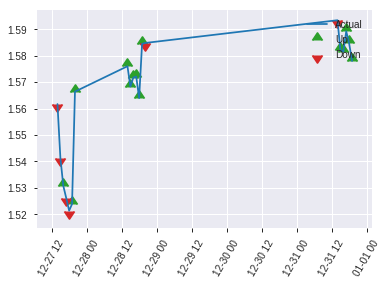


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23499029693735005
RMSE: 0.48475797769335377
LogLoss: 0.6644994635743517
Mean Per-Class Error: 0.376140350877193
AUC: 0.6332631578947369
pr_auc: 0.5588277355687682
Gini: 0.2665263157894737
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2654697000980377: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      14   81   0.8526   (81.0/95.0)
1      3    72   0.04     (3.0/75.0)
Total  17   153  0.4941   (84.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.26547      0.631579  152
max f2                       0.215822     0.799574  168
max f0point5                 0.448092     0.579515  73
max accuracy                 0.557511     0.641176  33
max precision                0.799937     0.75      3
max recall                   0.215822     1         168
max specificity              0.821685     0.989474  0
max absolute_mcc             0.557511     0.266557  33
max min_per_class_accuracy   0.426162     0.621053  82
max mean_per_class_accuracy  0.426162     0.62386   82

Gains/Lift Table: Avg response rate: 44.12 %, avg score: 44.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.808579           1.13333   1.13333            0.5              0.819124  0.5                         0.819124            0.0133333       0.0133333                  13.3333   13.3333
    2        0.0235294                   0.793436           2.26667   1.7                1                0.802464  0.75                        0.810794            0.0266667       0.04                       126.667   70
    3        0.0352941                   0.77923            1.13333   1.51111            0.5              0.781143  0.666667                    0.800911            0.0133333       0.0533333                  13.3333   51.1111
    4        0.0411765                   0.775328           0         1.29524            0                0.776201  0.571429                    0.797381            0               0.0533333                  -100      29.5238
    5        0.0529412                   0.77256            1.13333   1.25926            0.5              0.774533  0.555556                    0.792303            0.0133333       0.0666667                  13.3333   25.9259
    6        0.1                         0.682239           1.7       1.46667            0.75             0.742891  0.647059                    0.76905             0.08            0.146667                   70        46.6667
    7        0.152941                    0.596616           1.76296   1.56923            0.777778         0.636993  0.692308                    0.723338            0.0933333       0.24                       76.2963   56.9231
    8        0.2                         0.555792           1.7       1.6                0.75             0.573927  0.705882                    0.688183            0.08            0.32                       70        60
    9        0.3                         0.513713           0.666667  1.28889            0.294118         0.53061   0.568627                    0.635659            0.0666667       0.386667                   -33.3333  28.8889
    10       0.4                         0.471083           1.33333   1.3                0.588235         0.494218  0.573529                    0.600299            0.133333        0.52                       33.3333   30
    11       0.5                         0.421234           1.06667   1.25333            0.470588         0.443954  0.552941                    0.56903             0.106667        0.626667                   6.66667   25.3333
    12       0.6                         0.379313           0.666667  1.15556            0.294118         0.398564  0.509804                    0.540619            0.0666667       0.693333                   -33.3333  15.5556
    13       0.7                         0.337092           0.933333  1.12381            0.411765         0.360288  0.495798                    0.514857            0.0933333       0.786667                   -6.66667  12.381
    14       0.8                         0.294528           0.533333  1.05               0.235294         0.312047  0.463235                    0.489506            0.0533333       0.84                       -46.6667  5
    15       0.9                         0.265392           1.2       1.06667            0.529412         0.279929  0.470588                    0.466219            0.12            0.96                       20        6.66667
    16       1                           0.21023            0.4       1                  0.176471         0.2406    0.441176                    0.443658            0.04            1  

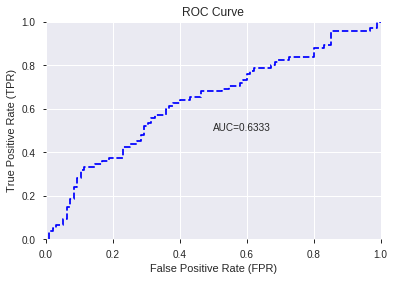

This function is available for GLM models only


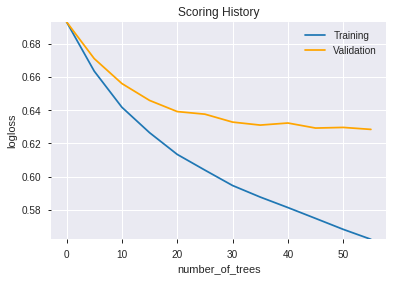

--2019-07-25 05:04:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.111.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.111.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_050445_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_050445_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a9a0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['STOCHF_fastk',
 'CCI_8',
 'TRANGE',
 'WILLR_14',
 'STOCHF_fastd',
 'WILLR_30',
 'HT_PHASOR_quadrature',
 'ULTOSC',
 'HT_DCPERIOD',
 'aroonup_12',
 'CCI_12',
 'LINEARREG_ANGLE_12',
 'BETA_8',
 'DX_30',
 'MFI_12',
 'DX_8',
 'PLUS_DM_30',
 'WILLR_20',
 'CORREL_12',
 'STOCH_slowd',
 'aroonup_14',
 'BETA_12',
 'PLUS_DI_24',
 'ATR_12',
 'ADX_8',
 'ROCP_12',
 'MACD_hist',
 'BBANDS_upperband_24_7_2',
 'BBANDS_middleband_20_5_4',
 'aroondown_14',
 'ROCP_14',
 'PLUS_DI_14',
 'APO',
 'MACDFIX_24',
 'aroonup_30',
 'MOM_24',
 'CCI_30',
 'LINEARREG_SLOPE_8',
 'VAR_8',
 'MEDPRICE',
 'PLUS_DM_20',
 'MFI_30']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.676
GLM             0.688
XGBoost         0.694
dtype: float64

DeepLearning    GLM  XGBoost
All          0.659  0.688    0.671
DLF          0.647  0.671    0.694
Fwe          0.676  0.659    0.671
RFE          0.641  0.653    0.641
XGBF         0.659  0.671    0.694





F1


DeepLearning    0.655
GLM             0.648
XGBoost         0.660
dtype: float64

DeepLearning    GLM  XGBoost
All          0.634  0.641    0.655
DLF          0.642  0.633    0.660
Fwe          0.655  0.648    0.639
RFE          0.633  0.638    0.632
XGBF         0.633  0.633    0.660





auc


DeepLearning    0.683
GLM             0.660
XGBoost         0.701
dtype: float64

DeepLearning    GLM  XGBoost
All          0.653  0.659    0.692
DLF          0.644  0.648    0.701
Fwe          0.683  0.660    0.672
RFE          0.623  0.637    0.633
XGBF         0.653  0.648    0.701





logloss


DeepLearning    0.676
GLM             0.684
XGBoost         0.664
dtype: float64

DeepLearning    GLM  XGBoost
All          0.666  0.663    0.644
DLF          0.673  0.666    0.644
Fwe          0.658  0.684    0.648
RFE          0.676  0.665    0.664
XGBF         0.654  0.666    0.644





mean_per_class_error


DeepLearning    0.369
GLM             0.357
XGBoost         0.376
dtype: float64

DeepLearning    GLM  XGBoost
All          0.360  0.327    0.326
DLF          0.361  0.348    0.309
Fwe          0.335  0.343    0.337
RFE          0.369  0.357    0.376
XGBF         0.354  0.348    0.309





rmse


DeepLearning    0.491
GLM             0.487
XGBoost         0.485
dtype: float64

DeepLearning    GLM  XGBoost
All          0.486  0.484    0.473
DLF          0.488  0.484    0.473
Fwe          0.479  0.487    0.477
RFE          0.491  0.486    0.485
XGBF         0.480  0.484    0.473





mse


DeepLearning    0.241
GLM             0.237
XGBoost         0.235
dtype: float64

DeepLearning    GLM  XGBoost
All          0.236  0.234    0.224
DLF          0.238  0.235    0.223
Fwe          0.230  0.237    0.227
RFE          0.241  0.236    0.235
XGBF         0.231  0.235    0.223

{'F1':       DeepLearning    GLM  XGBoost
 All          0.634    NaN      NaN
 DLF          0.642    NaN      NaN
 DLF            NaN  0.633      NaN
 DLF            NaN    NaN    0.660
 All            NaN  0.641      NaN
 All            NaN    NaN    0.655
 XGBF         0.633    NaN      NaN
 XGBF           NaN  0.633      NaN
 XGBF           NaN    NaN    0.660
 Fwe          0.655    NaN      NaN
 Fwe            NaN  0.648      NaN
 Fwe            NaN    NaN    0.639
 RFE          0.633    NaN      NaN
 RFE            NaN  0.638      NaN
 RFE            NaN    NaN    0.632,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.659    NaN      NaN
 DLF          0.647    NaN      NaN
 DLF            NaN  0.671      NaN
 DLF            NaN    NaN    0.694
 All            NaN  0.688      NaN
 All            NaN    NaN    0.671
 XGBF         0.659    NaN      NaN
 XGBF           NaN  0.671      NaN
 XGBF           NaN    NaN    0.694
 Fwe          0.676    NaN      NaN
 Fwe     